# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.466779698324851 -2.606996774785296
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [167]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [168]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [169]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    return states, actions, targetQs, reward

In [191]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [192]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [193]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [194]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [195]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    rewards = reward * tf.ones_like(targetQs)
    Qs_labels = rewards[:-1] + (0.99*targetQs[1:])
    #Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.reshape(rewards[-1], [1])])
    Qs_labels = tf.concat(axis=0, values=[Qs_labels, tf.zeros([1])])
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs_labels)
    
    # D
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_lossR = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=rewards))
    d_lossQ = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=tf.reshape(Qs_logits, [-1]),
                                                                     labels=tf.nn.sigmoid(Qs_labels)))
    d_loss = d_lossR + d_lossQ

    return actions_logits, Qs_logits, g_loss, d_loss, d_lossR, d_lossQ

In [196]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [197]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.d_lossR, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, # model input
            targetQs=self.targetQs, reward=self.reward) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [198]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(500, 4) actions:(500,)
action size:2


In [199]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [200]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [201]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [ ]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []
rates_list, d_lossR_list, d_lossQ_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(111111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits, Q_logits = sess.run(fetches=[model.actions_logits, model.Qs_logits], 
                                               feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            batch.append([state, action, Q_logits])
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # stopping criteria
                rate = total_reward/ 500 # success is 500 points: 0-1
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, d_lossR, d_lossQ, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                           model.d_lossR, model.d_lossQ, 
                                                           model.g_opt, model.d_opt],
                                                          feed_dict = {model.states: states, 
                                                                       model.actions: actions,
                                                                       model.reward: rate,
                                                                       model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss),
              'dlossR:{:.4f}'.format(d_lossR),
              'dlossQ:{:.4f}'.format(d_lossQ))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        rates_list.append([ep, rate])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        d_lossR_list.append([ep, d_lossR])
        d_lossQ_list.append([ep, d_lossQ])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:65.0000 rate:0.1300 gloss:0.0662 dloss:1.3770 dlossR:0.6831 dlossQ:0.6939
Episode:1 meanR:36.5000 rate:0.0160 gloss:-0.0025 dloss:1.3762 dlossR:0.6830 dlossQ:0.6932
Episode:2 meanR:27.6667 rate:0.0200 gloss:-0.0256 dloss:1.3545 dlossR:0.6616 dlossQ:0.6929
Episode:3 meanR:23.0000 rate:0.0180 gloss:-0.0748 dloss:1.3154 dlossR:0.6240 dlossQ:0.6914
Episode:4 meanR:20.6000 rate:0.0220 gloss:-0.1157 dloss:1.2827 dlossR:0.5941 dlossQ:0.6886
Episode:5 meanR:18.8333 rate:0.0200 gloss:-0.1701 dloss:1.2487 dlossR:0.5637 dlossQ:0.6850
Episode:6 meanR:25.0000 rate:0.1240 gloss:-0.0123 dloss:1.3375 dlossR:0.6435 dlossQ:0.6940
Episode:7 meanR:27.7500 rate:0.0940 gloss:-0.0657 dloss:1.3140 dlossR:0.6233 dlossQ:0.6907
Episode:8 meanR:30.6667 rate:0.1080 gloss:-0.0658 dloss:1.3120 dlossR:0.6219 dlossQ:0.6901
Episode:9 meanR:43.2000 rate:0.3120 gloss:0.0582 dloss:1.3619 dlossR:0.6578 dlossQ:0.7041
Episode:10 meanR:42.5455 rate:0.0720 gloss:-0.0446 dloss:1.3280 dlossR:0.6347 dlossQ:0.6933


Episode:91 meanR:44.9130 rate:0.1380 gloss:-1.2338 dloss:0.8198 dlossR:0.4032 dlossQ:0.4166
Episode:92 meanR:45.2366 rate:0.1500 gloss:-1.2116 dloss:0.8505 dlossR:0.4262 dlossQ:0.4242
Episode:93 meanR:45.2553 rate:0.0940 gloss:-1.4051 dloss:0.7276 dlossR:0.3238 dlossQ:0.4038
Episode:94 meanR:45.2842 rate:0.0960 gloss:-1.2541 dloss:0.7331 dlossR:0.3205 dlossQ:0.4127
Episode:95 meanR:45.2604 rate:0.0860 gloss:-1.2617 dloss:0.7135 dlossR:0.3008 dlossQ:0.4127
Episode:96 meanR:45.1340 rate:0.0660 gloss:-1.2979 dloss:0.6691 dlossR:0.2590 dlossQ:0.4101
Episode:97 meanR:44.9082 rate:0.0460 gloss:-1.3587 dloss:0.6067 dlossR:0.2123 dlossQ:0.3944
Episode:98 meanR:44.7172 rate:0.0520 gloss:-1.3750 dloss:0.6078 dlossR:0.2241 dlossQ:0.3837
Episode:99 meanR:44.4700 rate:0.0400 gloss:-1.4039 dloss:0.5856 dlossR:0.1950 dlossQ:0.3906
Episode:100 meanR:44.0400 rate:0.0440 gloss:-1.4862 dloss:0.5583 dlossR:0.1980 dlossQ:0.3602
Episode:101 meanR:44.1700 rate:0.0420 gloss:-1.5529 dloss:0.5402 dlossR:0.1890 

Episode:180 meanR:38.2000 rate:0.0220 gloss:-1.7339 dloss:0.4713 dlossR:0.1261 dlossQ:0.3452
Episode:181 meanR:38.2600 rate:0.0520 gloss:-1.9269 dloss:0.5433 dlossR:0.2193 dlossQ:0.3239
Episode:182 meanR:38.4500 rate:0.1100 gloss:-1.4742 dloss:0.7056 dlossR:0.3503 dlossQ:0.3554
Episode:183 meanR:38.9800 rate:0.1540 gloss:-1.4025 dloss:0.8178 dlossR:0.4462 dlossQ:0.3716
Episode:184 meanR:39.4300 rate:0.1320 gloss:-1.4086 dloss:0.7625 dlossR:0.3965 dlossQ:0.3660
Episode:185 meanR:39.9000 rate:0.1420 gloss:-1.5915 dloss:0.7585 dlossR:0.4385 dlossQ:0.3199
Episode:186 meanR:39.2300 rate:0.1520 gloss:-1.5671 dloss:0.7876 dlossR:0.4615 dlossQ:0.3261
Episode:187 meanR:39.3500 rate:0.0640 gloss:-1.4367 dloss:0.6082 dlossR:0.2449 dlossQ:0.3633
Episode:188 meanR:40.6400 rate:0.3120 gloss:-1.2879 dloss:1.1969 dlossR:0.7947 dlossQ:0.4022
Episode:189 meanR:39.4200 rate:0.0700 gloss:-1.4089 dloss:0.6294 dlossR:0.2595 dlossQ:0.3700
Episode:190 meanR:38.9600 rate:0.0780 gloss:-1.3965 dloss:0.6494 dloss

Episode:275 meanR:31.2400 rate:0.0240 gloss:-1.5489 dloss:0.5083 dlossR:0.1412 dlossQ:0.3672
Episode:276 meanR:31.2400 rate:0.0200 gloss:-1.5540 dloss:0.5195 dlossR:0.1294 dlossQ:0.3901
Episode:277 meanR:31.2400 rate:0.0220 gloss:-1.5917 dloss:0.5122 dlossR:0.1331 dlossQ:0.3792
Episode:278 meanR:31.4500 rate:0.0620 gloss:-1.4428 dloss:0.6014 dlossR:0.2403 dlossQ:0.3612
Episode:279 meanR:31.7100 rate:0.0680 gloss:-1.4382 dloss:0.6197 dlossR:0.2539 dlossQ:0.3658
Episode:280 meanR:32.4100 rate:0.1620 gloss:-1.4014 dloss:0.8306 dlossR:0.4638 dlossQ:0.3669
Episode:281 meanR:32.4700 rate:0.0640 gloss:-1.4732 dloss:0.5983 dlossR:0.2432 dlossQ:0.3550
Episode:282 meanR:32.2200 rate:0.0600 gloss:-1.4831 dloss:0.5868 dlossR:0.2336 dlossQ:0.3532
Episode:283 meanR:31.6000 rate:0.0300 gloss:-1.4410 dloss:0.5473 dlossR:0.1656 dlossQ:0.3817
Episode:284 meanR:31.1100 rate:0.0340 gloss:-1.4657 dloss:0.5452 dlossR:0.1735 dlossQ:0.3717
Episode:285 meanR:30.6500 rate:0.0500 gloss:-1.4784 dloss:0.5687 dloss

Episode:372 meanR:34.5100 rate:0.1240 gloss:-1.5597 dloss:0.7104 dlossR:0.3861 dlossQ:0.3243
Episode:373 meanR:36.0300 rate:0.3340 gloss:-1.4413 dloss:1.2587 dlossR:0.9020 dlossQ:0.3566
Episode:374 meanR:36.1200 rate:0.0480 gloss:-1.6850 dloss:0.5111 dlossR:0.1967 dlossQ:0.3144
Episode:375 meanR:36.2400 rate:0.0480 gloss:-1.6658 dloss:0.5114 dlossR:0.1971 dlossQ:0.3143
Episode:376 meanR:36.2400 rate:0.0200 gloss:-1.5970 dloss:0.4960 dlossR:0.1251 dlossQ:0.3709
Episode:377 meanR:36.3600 rate:0.0460 gloss:-1.6167 dloss:0.5196 dlossR:0.1940 dlossQ:0.3256
Episode:378 meanR:36.1400 rate:0.0180 gloss:-1.5882 dloss:0.5199 dlossR:0.1201 dlossQ:0.3998
Episode:379 meanR:36.1000 rate:0.0600 gloss:-1.5314 dloss:0.5805 dlossR:0.2324 dlossQ:0.3482
Episode:380 meanR:36.5600 rate:0.2540 gloss:-1.2742 dloss:1.0605 dlossR:0.6547 dlossQ:0.4058
Episode:381 meanR:36.7300 rate:0.0980 gloss:-1.2774 dloss:0.7280 dlossR:0.3241 dlossQ:0.4038
Episode:382 meanR:36.8800 rate:0.0900 gloss:-1.2393 dloss:0.7259 dloss

Episode:462 meanR:37.2000 rate:0.2600 gloss:-1.0385 dloss:1.1020 dlossR:0.6212 dlossQ:0.4808
Episode:463 meanR:37.5100 rate:0.0920 gloss:-1.1870 dloss:0.7496 dlossR:0.3157 dlossQ:0.4339
Episode:464 meanR:37.7100 rate:0.0700 gloss:-1.1705 dloss:0.7179 dlossR:0.2771 dlossQ:0.4408
Episode:465 meanR:38.3000 rate:0.1600 gloss:-1.1064 dloss:0.8993 dlossR:0.4409 dlossQ:0.4583
Episode:466 meanR:38.4400 rate:0.0540 gloss:-1.1357 dloss:0.7045 dlossR:0.2525 dlossQ:0.4520
Episode:467 meanR:38.6100 rate:0.0660 gloss:-1.1144 dloss:0.7336 dlossR:0.2763 dlossQ:0.4573
Episode:468 meanR:38.6900 rate:0.0600 gloss:-1.1074 dloss:0.7276 dlossR:0.2669 dlossQ:0.4607
Episode:469 meanR:38.3600 rate:0.0800 gloss:-1.0973 dloss:0.7645 dlossR:0.3022 dlossQ:0.4623
Episode:470 meanR:38.5600 rate:0.0660 gloss:-1.0870 dloss:0.7462 dlossR:0.2799 dlossQ:0.4662
Episode:471 meanR:38.4700 rate:0.0460 gloss:-1.0743 dloss:0.7210 dlossR:0.2477 dlossQ:0.4734
Episode:472 meanR:38.1400 rate:0.0580 gloss:-1.1082 dloss:0.7242 dloss

Episode:554 meanR:31.3900 rate:0.1060 gloss:-1.4824 dloss:0.6848 dlossR:0.3406 dlossQ:0.3443
Episode:555 meanR:31.0600 rate:0.0980 gloss:-1.4796 dloss:0.6675 dlossR:0.3220 dlossQ:0.3454
Episode:556 meanR:30.9700 rate:0.0600 gloss:-1.4498 dloss:0.5938 dlossR:0.2363 dlossQ:0.3575
Episode:557 meanR:30.8100 rate:0.0860 gloss:-1.5104 dloss:0.6317 dlossR:0.2944 dlossQ:0.3374
Episode:558 meanR:30.7400 rate:0.1140 gloss:-1.5078 dloss:0.6969 dlossR:0.3601 dlossQ:0.3368
Episode:559 meanR:29.9500 rate:0.0500 gloss:-1.4821 dloss:0.5625 dlossR:0.2108 dlossQ:0.3517
Episode:560 meanR:29.4700 rate:0.0660 gloss:-1.4975 dloss:0.5910 dlossR:0.2475 dlossQ:0.3435
Episode:561 meanR:29.3200 rate:0.0980 gloss:-1.3838 dloss:0.6963 dlossR:0.3245 dlossQ:0.3718
Episode:562 meanR:28.2100 rate:0.0380 gloss:-1.4697 dloss:0.5436 dlossR:0.1830 dlossQ:0.3606
Episode:563 meanR:28.2500 rate:0.1000 gloss:-1.3210 dloss:0.7204 dlossR:0.3302 dlossQ:0.3902
Episode:564 meanR:28.4300 rate:0.1060 gloss:-1.3524 dloss:0.7232 dloss

Episode:644 meanR:33.7300 rate:0.1680 gloss:-1.0995 dloss:0.9184 dlossR:0.4593 dlossQ:0.4592
Episode:645 meanR:34.6700 rate:0.2080 gloss:-1.1108 dloss:0.9918 dlossR:0.5342 dlossQ:0.4576
Episode:646 meanR:35.4700 rate:0.1820 gloss:-1.0815 dloss:0.9503 dlossR:0.4841 dlossQ:0.4663
Episode:647 meanR:36.2500 rate:0.1920 gloss:-1.0377 dloss:0.9797 dlossR:0.4995 dlossQ:0.4801
Episode:648 meanR:37.3600 rate:0.2420 gloss:-1.0116 dloss:1.0774 dlossR:0.5884 dlossQ:0.4890
Episode:649 meanR:37.7400 rate:0.0960 gloss:-1.0663 dloss:0.8036 dlossR:0.3332 dlossQ:0.4704
Episode:650 meanR:38.2300 rate:0.1180 gloss:-1.0922 dloss:0.8312 dlossR:0.3694 dlossQ:0.4618
Episode:651 meanR:38.5600 rate:0.1240 gloss:-0.8985 dloss:0.9166 dlossR:0.3973 dlossQ:0.5193
Episode:652 meanR:38.1700 rate:0.1220 gloss:-0.8440 dloss:0.9367 dlossR:0.4014 dlossQ:0.5353
Episode:653 meanR:38.3400 rate:0.1360 gloss:-0.8969 dloss:0.9360 dlossR:0.4167 dlossQ:0.5194
Episode:654 meanR:38.4600 rate:0.1300 gloss:-0.8376 dloss:0.9506 dloss

Episode:740 meanR:42.4500 rate:0.2020 gloss:-1.2494 dloss:0.9486 dlossR:0.5359 dlossQ:0.4127
Episode:741 meanR:43.2400 rate:0.1760 gloss:-1.2460 dloss:0.8945 dlossR:0.4809 dlossQ:0.4136
Episode:742 meanR:44.5100 rate:0.3920 gloss:-1.1564 dloss:1.3855 dlossR:0.9369 dlossQ:0.4486
Episode:743 meanR:45.3600 rate:0.3320 gloss:-1.1570 dloss:1.2447 dlossR:0.7989 dlossQ:0.4459
Episode:744 meanR:45.6800 rate:0.2320 gloss:-1.1699 dloss:1.0253 dlossR:0.5870 dlossQ:0.4383
Episode:745 meanR:45.4000 rate:0.1520 gloss:-1.3251 dloss:0.8257 dlossR:0.4353 dlossQ:0.3904
Episode:746 meanR:45.3800 rate:0.1780 gloss:-1.0948 dloss:0.9354 dlossR:0.4746 dlossQ:0.4608
Episode:747 meanR:45.8600 rate:0.2880 gloss:-1.0299 dloss:1.1583 dlossR:0.6731 dlossQ:0.4852
Episode:748 meanR:45.8900 rate:0.2480 gloss:-1.0079 dloss:1.0846 dlossR:0.5939 dlossQ:0.4908
Episode:749 meanR:46.2800 rate:0.1740 gloss:-1.1627 dloss:0.9099 dlossR:0.4697 dlossQ:0.4402
Episode:750 meanR:46.7800 rate:0.2180 gloss:-0.9160 dloss:1.0518 dloss

Episode:832 meanR:54.9100 rate:0.0620 gloss:-1.3003 dloss:0.6519 dlossR:0.2503 dlossQ:0.4016
Episode:833 meanR:55.0300 rate:0.0460 gloss:-1.3229 dloss:0.6139 dlossR:0.2152 dlossQ:0.3987
Episode:834 meanR:55.1000 rate:0.0340 gloss:-1.3411 dloss:0.5861 dlossR:0.1869 dlossQ:0.3992
Episode:835 meanR:55.1600 rate:0.0360 gloss:-1.3851 dloss:0.5746 dlossR:0.1870 dlossQ:0.3876
Episode:836 meanR:55.1800 rate:0.0380 gloss:-1.4310 dloss:0.5597 dlossR:0.1873 dlossQ:0.3724
Episode:837 meanR:55.2100 rate:0.0260 gloss:-1.4588 dloss:0.5364 dlossR:0.1551 dlossQ:0.3813
Episode:838 meanR:54.8900 rate:0.0240 gloss:-1.4325 dloss:0.5417 dlossR:0.1522 dlossQ:0.3895
Episode:839 meanR:54.3500 rate:0.0180 gloss:-1.3852 dloss:0.5568 dlossR:0.1396 dlossQ:0.4171
Episode:840 meanR:53.6000 rate:0.0520 gloss:-1.4223 dloss:0.5897 dlossR:0.2198 dlossQ:0.3700
Episode:841 meanR:53.0800 rate:0.0720 gloss:-1.3506 dloss:0.6530 dlossR:0.2671 dlossQ:0.3859
Episode:842 meanR:51.9600 rate:0.1680 gloss:-1.3157 dloss:0.8624 dloss

Episode:929 meanR:51.3300 rate:0.0660 gloss:-1.0051 dloss:0.7860 dlossR:0.2925 dlossQ:0.4934
Episode:930 meanR:51.5900 rate:0.2120 gloss:-1.1319 dloss:0.9998 dlossR:0.5466 dlossQ:0.4531
Episode:931 meanR:51.5400 rate:0.0680 gloss:-1.0317 dloss:0.7780 dlossR:0.2918 dlossQ:0.4862
Episode:932 meanR:52.0000 rate:0.1540 gloss:-0.9597 dloss:0.9382 dlossR:0.4313 dlossQ:0.5070
Episode:933 meanR:52.7600 rate:0.1980 gloss:-0.8605 dloss:1.0354 dlossR:0.4985 dlossQ:0.5369
Episode:934 meanR:53.1700 rate:0.1160 gloss:-1.0479 dloss:0.8475 dlossR:0.3675 dlossQ:0.4800
Episode:935 meanR:53.3100 rate:0.0640 gloss:-0.9417 dloss:0.8100 dlossR:0.2997 dlossQ:0.5103
Episode:936 meanR:53.5700 rate:0.0900 gloss:-0.9782 dloss:0.8304 dlossR:0.3323 dlossQ:0.4981
Episode:937 meanR:53.6800 rate:0.0480 gloss:-0.9676 dloss:0.7746 dlossR:0.2706 dlossQ:0.5039
Episode:938 meanR:53.9500 rate:0.0780 gloss:-1.0122 dloss:0.7974 dlossR:0.3095 dlossQ:0.4878
Episode:939 meanR:54.0900 rate:0.0460 gloss:-1.0116 dloss:0.7495 dloss

Episode:1020 meanR:45.8700 rate:0.1860 gloss:-0.7901 dloss:1.0409 dlossR:0.4832 dlossQ:0.5576
Episode:1021 meanR:46.0300 rate:0.1960 gloss:-0.7423 dloss:1.0700 dlossR:0.4991 dlossQ:0.5709
Episode:1022 meanR:46.7300 rate:0.1900 gloss:-0.8023 dloss:1.0425 dlossR:0.4886 dlossQ:0.5539
Episode:1023 meanR:47.5100 rate:0.1940 gloss:-0.7538 dloss:1.0636 dlossR:0.4965 dlossQ:0.5672
Episode:1024 meanR:47.4700 rate:0.0220 gloss:-0.9366 dloss:0.7490 dlossR:0.2319 dlossQ:0.5171
Episode:1025 meanR:47.5000 rate:0.0280 gloss:-0.9951 dloss:0.7289 dlossR:0.2318 dlossQ:0.4971
Episode:1026 meanR:48.1700 rate:0.1700 gloss:-0.7911 dloss:1.0184 dlossR:0.4623 dlossQ:0.5560
Episode:1027 meanR:48.8400 rate:0.1720 gloss:-0.8088 dloss:1.0151 dlossR:0.4637 dlossQ:0.5514
Episode:1028 meanR:49.8200 rate:0.2340 gloss:-0.7775 dloss:1.1117 dlossR:0.5489 dlossQ:0.5629
Episode:1029 meanR:50.8000 rate:0.2620 gloss:-0.7560 dloss:1.1577 dlossR:0.5870 dlossQ:0.5707
Episode:1030 meanR:52.5600 rate:0.5640 gloss:-0.5865 dloss:1

Episode:1110 meanR:67.0800 rate:0.0860 gloss:-1.2002 dloss:0.7376 dlossR:0.3043 dlossQ:0.4333
Episode:1111 meanR:66.6300 rate:0.0180 gloss:-1.3812 dloss:0.5646 dlossR:0.1437 dlossQ:0.4209
Episode:1112 meanR:66.6400 rate:0.0260 gloss:-1.4439 dloss:0.5443 dlossR:0.1589 dlossQ:0.3854
Episode:1113 meanR:66.4100 rate:0.0560 gloss:-1.2706 dloss:0.6570 dlossR:0.2414 dlossQ:0.4156
Episode:1114 meanR:66.2900 rate:0.1160 gloss:-1.1906 dloss:0.7932 dlossR:0.3606 dlossQ:0.4326
Episode:1115 meanR:67.9500 rate:0.4500 gloss:-1.1323 dloss:1.5282 dlossR:1.0665 dlossQ:0.4617
Episode:1116 meanR:67.5800 rate:0.1080 gloss:-1.2999 dloss:0.7439 dlossR:0.3438 dlossQ:0.4002
Episode:1117 meanR:66.8800 rate:0.0340 gloss:-1.2993 dloss:0.6055 dlossR:0.1926 dlossQ:0.4129
Episode:1118 meanR:66.1500 rate:0.0180 gloss:-1.4062 dloss:0.5635 dlossR:0.1419 dlossQ:0.4215
Episode:1119 meanR:65.9600 rate:0.1220 gloss:-1.2712 dloss:0.7806 dlossR:0.3717 dlossQ:0.4089
Episode:1120 meanR:65.6100 rate:0.1160 gloss:-1.2580 dloss:0

Episode:1198 meanR:44.2600 rate:0.0440 gloss:-1.5077 dloss:0.5475 dlossR:0.1950 dlossQ:0.3525
Episode:1199 meanR:44.9900 rate:0.1740 gloss:-1.4303 dloss:0.8535 dlossR:0.4946 dlossQ:0.3589
Episode:1200 meanR:44.8200 rate:0.0200 gloss:-1.6529 dloss:0.4846 dlossR:0.1223 dlossQ:0.3622
Episode:1201 meanR:44.8800 rate:0.0460 gloss:-1.5791 dloss:0.5290 dlossR:0.1959 dlossQ:0.3331
Episode:1202 meanR:44.6300 rate:0.0260 gloss:-1.5814 dloss:0.4953 dlossR:0.1440 dlossQ:0.3513
Episode:1203 meanR:44.1000 rate:0.0280 gloss:-1.6073 dloss:0.4904 dlossR:0.1477 dlossQ:0.3427
Episode:1204 meanR:42.8800 rate:0.0220 gloss:-1.5807 dloss:0.4940 dlossR:0.1326 dlossQ:0.3614
Episode:1205 meanR:41.6300 rate:0.0240 gloss:-1.5936 dloss:0.4909 dlossR:0.1375 dlossQ:0.3534
Episode:1206 meanR:41.4100 rate:0.0560 gloss:-1.5324 dloss:0.5635 dlossR:0.2224 dlossQ:0.3412
Episode:1207 meanR:41.3600 rate:0.0220 gloss:-1.6569 dloss:0.4783 dlossR:0.1277 dlossQ:0.3506
Episode:1208 meanR:41.2500 rate:0.0200 gloss:-1.6362 dloss:0

Episode:1291 meanR:68.9000 rate:0.3420 gloss:-0.3030 dloss:1.3291 dlossR:0.6448 dlossQ:0.6842
Episode:1292 meanR:69.3800 rate:0.1280 gloss:-0.4913 dloss:1.1056 dlossR:0.4666 dlossQ:0.6390
Episode:1293 meanR:69.6700 rate:0.1020 gloss:-0.5486 dloss:1.0579 dlossR:0.4327 dlossQ:0.6252
Episode:1294 meanR:69.7100 rate:0.0500 gloss:-0.6088 dloss:0.9861 dlossR:0.3731 dlossQ:0.6130
Episode:1295 meanR:69.6000 rate:0.0220 gloss:-0.8368 dloss:0.8302 dlossR:0.2714 dlossQ:0.5588
Episode:1296 meanR:69.8500 rate:0.0940 gloss:-0.5620 dloss:1.0431 dlossR:0.4217 dlossQ:0.6214
Episode:1297 meanR:70.0800 rate:0.0860 gloss:-0.6016 dloss:1.0164 dlossR:0.4046 dlossQ:0.6118
Episode:1298 meanR:70.8200 rate:0.1920 gloss:-0.5231 dloss:1.1419 dlossR:0.5092 dlossQ:0.6327
Episode:1299 meanR:70.8900 rate:0.1880 gloss:-0.5165 dloss:1.1392 dlossR:0.5061 dlossQ:0.6331
Episode:1300 meanR:72.1100 rate:0.2640 gloss:-0.4912 dloss:1.2208 dlossR:0.5778 dlossQ:0.6429
Episode:1301 meanR:74.5300 rate:0.5300 gloss:-0.2868 dloss:1

Episode:1378 meanR:109.3100 rate:0.0820 gloss:-0.4797 dloss:1.0775 dlossR:0.4389 dlossQ:0.6386
Episode:1379 meanR:109.5900 rate:0.0740 gloss:-0.4940 dloss:1.0651 dlossR:0.4292 dlossQ:0.6359
Episode:1380 meanR:109.8500 rate:0.0720 gloss:-0.4966 dloss:1.0621 dlossR:0.4273 dlossQ:0.6348
Episode:1381 meanR:110.1000 rate:0.0700 gloss:-0.5047 dloss:1.0585 dlossR:0.4234 dlossQ:0.6351
Episode:1382 meanR:110.0100 rate:0.0420 gloss:-0.5518 dloss:1.0097 dlossR:0.3862 dlossQ:0.6235
Episode:1383 meanR:110.0200 rate:0.0380 gloss:-0.5685 dloss:0.9962 dlossR:0.3764 dlossQ:0.6198
Episode:1384 meanR:110.1600 rate:0.0500 gloss:-0.5662 dloss:1.0087 dlossR:0.3879 dlossQ:0.6207
Episode:1385 meanR:110.3900 rate:0.0680 gloss:-0.5732 dloss:1.0196 dlossR:0.3993 dlossQ:0.6203
Episode:1386 meanR:110.5600 rate:0.0520 gloss:-0.6147 dloss:0.9836 dlossR:0.3730 dlossQ:0.6106
Episode:1387 meanR:110.8100 rate:0.0720 gloss:-0.5947 dloss:1.0123 dlossR:0.3968 dlossQ:0.6155
Episode:1388 meanR:111.2800 rate:0.1120 gloss:-0.5

Episode:1468 meanR:70.1300 rate:0.0740 gloss:-1.0670 dloss:0.7943 dlossR:0.3089 dlossQ:0.4854
Episode:1469 meanR:69.1900 rate:0.0300 gloss:-0.8936 dloss:0.8000 dlossR:0.2639 dlossQ:0.5361
Episode:1470 meanR:68.2400 rate:0.0220 gloss:-0.9911 dloss:0.7488 dlossR:0.2298 dlossQ:0.5190
Episode:1471 meanR:67.6300 rate:0.0280 gloss:-0.9004 dloss:0.7975 dlossR:0.2599 dlossQ:0.5376
Episode:1472 meanR:67.1900 rate:0.0780 gloss:-0.8429 dloss:0.8868 dlossR:0.3401 dlossQ:0.5467
Episode:1473 meanR:67.0300 rate:0.1460 gloss:-0.7509 dloss:1.0084 dlossR:0.4364 dlossQ:0.5719
Episode:1474 meanR:68.1400 rate:0.2460 gloss:-0.6696 dloss:1.1589 dlossR:0.5615 dlossQ:0.5974
Episode:1475 meanR:69.8200 rate:0.4560 gloss:-0.4901 dloss:1.4652 dlossR:0.8066 dlossQ:0.6586
Episode:1476 meanR:69.9700 rate:0.0500 gloss:-0.7653 dloss:0.8959 dlossR:0.3244 dlossQ:0.5715
Episode:1477 meanR:69.8400 rate:0.0300 gloss:-0.9429 dloss:0.7986 dlossR:0.2601 dlossQ:0.5385
Episode:1478 meanR:69.6500 rate:0.0440 gloss:-0.7833 dloss:0

Episode:1561 meanR:66.7700 rate:0.1140 gloss:-0.8069 dloss:0.9430 dlossR:0.3890 dlossQ:0.5540
Episode:1562 meanR:66.7300 rate:0.1740 gloss:-0.8706 dloss:1.0087 dlossR:0.4678 dlossQ:0.5409
Episode:1563 meanR:65.8100 rate:0.1000 gloss:-0.9987 dloss:0.8545 dlossR:0.3527 dlossQ:0.5018
Episode:1564 meanR:64.9900 rate:0.0920 gloss:-1.0002 dloss:0.8440 dlossR:0.3408 dlossQ:0.5032
Episode:1565 meanR:65.0700 rate:0.2500 gloss:-0.8354 dloss:1.1320 dlossR:0.5797 dlossQ:0.5523
Episode:1566 meanR:64.9700 rate:0.1800 gloss:-0.8210 dloss:1.0267 dlossR:0.4738 dlossQ:0.5528
Episode:1567 meanR:65.2500 rate:0.1280 gloss:-0.8879 dloss:0.9302 dlossR:0.3985 dlossQ:0.5317
Episode:1568 meanR:65.1500 rate:0.0540 gloss:-0.9308 dloss:0.8140 dlossR:0.2902 dlossQ:0.5238
Episode:1569 meanR:65.2600 rate:0.0520 gloss:-0.9574 dloss:0.8005 dlossR:0.2833 dlossQ:0.5172
Episode:1570 meanR:67.8100 rate:0.5320 gloss:-0.6437 dloss:1.6215 dlossR:0.9950 dlossQ:0.6265
Episode:1571 meanR:72.6700 rate:1.0000 gloss:-0.2510 dloss:2

Episode:1651 meanR:82.1200 rate:0.0860 gloss:-0.9285 dloss:0.8535 dlossR:0.3359 dlossQ:0.5176
Episode:1652 meanR:81.7400 rate:0.0900 gloss:-0.9202 dloss:0.8630 dlossR:0.3427 dlossQ:0.5203
Episode:1653 meanR:81.1700 rate:0.0860 gloss:-0.9289 dloss:0.8531 dlossR:0.3353 dlossQ:0.5177
Episode:1654 meanR:76.2700 rate:0.0200 gloss:-1.2247 dloss:0.6509 dlossR:0.1801 dlossQ:0.4708
Episode:1655 meanR:77.4900 rate:0.3520 gloss:-0.7222 dloss:1.3084 dlossR:0.7174 dlossQ:0.5909
Episode:1656 meanR:77.6900 rate:0.0980 gloss:-1.0292 dloss:0.8259 dlossR:0.3400 dlossQ:0.4858
Episode:1657 meanR:77.6100 rate:0.0360 gloss:-1.2250 dloss:0.6444 dlossR:0.2112 dlossQ:0.4332
Episode:1658 meanR:77.4800 rate:0.0180 gloss:-1.3394 dloss:0.6017 dlossR:0.1604 dlossQ:0.4413
Episode:1659 meanR:77.3800 rate:0.0300 gloss:-1.3419 dloss:0.5914 dlossR:0.1851 dlossQ:0.4063
Episode:1660 meanR:77.0100 rate:0.0340 gloss:-1.2740 dloss:0.6262 dlossR:0.2009 dlossQ:0.4253
Episode:1661 meanR:76.7000 rate:0.0520 gloss:-1.1261 dloss:0

Episode:1739 meanR:83.6900 rate:0.1600 gloss:-0.5912 dloss:1.0875 dlossR:0.4717 dlossQ:0.6158
Episode:1740 meanR:83.4700 rate:0.0900 gloss:-0.6809 dloss:0.9849 dlossR:0.3921 dlossQ:0.5928
Episode:1741 meanR:83.2100 rate:0.0220 gloss:-0.9829 dloss:0.7663 dlossR:0.2393 dlossQ:0.5270
Episode:1742 meanR:83.0600 rate:0.0420 gloss:-0.7765 dloss:0.8776 dlossR:0.3126 dlossQ:0.5650
Episode:1743 meanR:82.8800 rate:0.0280 gloss:-0.8505 dloss:0.8226 dlossR:0.2750 dlossQ:0.5476
Episode:1744 meanR:82.6200 rate:0.0220 gloss:-0.8771 dloss:0.8057 dlossR:0.2598 dlossQ:0.5460
Episode:1745 meanR:82.4600 rate:0.0300 gloss:-0.8723 dloss:0.8132 dlossR:0.2721 dlossQ:0.5411
Episode:1746 meanR:82.5700 rate:0.1160 gloss:-0.6105 dloss:1.0357 dlossR:0.4276 dlossQ:0.6081
Episode:1747 meanR:83.5400 rate:0.3020 gloss:-0.4925 dloss:1.2629 dlossR:0.6176 dlossQ:0.6453
Episode:1748 meanR:84.2600 rate:0.2180 gloss:-0.6204 dloss:1.1382 dlossR:0.5290 dlossQ:0.6092
Episode:1749 meanR:84.1900 rate:0.0400 gloss:-0.7160 dloss:0

Episode:1829 meanR:76.4400 rate:0.1700 gloss:-0.6957 dloss:1.0543 dlossR:0.4685 dlossQ:0.5859
Episode:1830 meanR:75.9200 rate:0.1260 gloss:-0.8808 dloss:0.9272 dlossR:0.3971 dlossQ:0.5301
Episode:1831 meanR:71.0900 rate:0.0340 gloss:-1.1383 dloss:0.6849 dlossR:0.2209 dlossQ:0.4640
Episode:1832 meanR:66.2200 rate:0.0260 gloss:-1.2086 dloss:0.6481 dlossR:0.1957 dlossQ:0.4524
Episode:1833 meanR:65.6700 rate:0.0320 gloss:-1.1684 dloss:0.6724 dlossR:0.2136 dlossQ:0.4588
Episode:1834 meanR:65.3500 rate:0.0500 gloss:-1.0232 dloss:0.7601 dlossR:0.2673 dlossQ:0.4927
Episode:1835 meanR:65.9100 rate:0.1380 gloss:-0.8809 dloss:0.9438 dlossR:0.4132 dlossQ:0.5306
Episode:1836 meanR:67.9900 rate:0.4440 gloss:-0.6159 dloss:1.4568 dlossR:0.8309 dlossQ:0.6259
Episode:1837 meanR:68.6600 rate:0.1660 gloss:-0.8195 dloss:1.0089 dlossR:0.4555 dlossQ:0.5535
Episode:1838 meanR:68.2700 rate:0.0220 gloss:-1.4481 dloss:0.5802 dlossR:0.1624 dlossQ:0.4178
Episode:1839 meanR:68.8600 rate:0.2780 gloss:-0.6218 dloss:1

Episode:1917 meanR:60.2700 rate:0.1440 gloss:-0.9584 dloss:0.9286 dlossR:0.4171 dlossQ:0.5114
Episode:1918 meanR:60.4900 rate:0.0760 gloss:-1.0397 dloss:0.7886 dlossR:0.3046 dlossQ:0.4840
Episode:1919 meanR:60.4200 rate:0.0260 gloss:-1.5205 dloss:0.5334 dlossR:0.1593 dlossQ:0.3741
Episode:1920 meanR:60.4800 rate:0.1100 gloss:-1.0395 dloss:0.8465 dlossR:0.3599 dlossQ:0.4866
Episode:1921 meanR:60.8100 rate:0.1660 gloss:-0.9164 dloss:0.9732 dlossR:0.4514 dlossQ:0.5219
Episode:1922 meanR:60.8000 rate:0.1140 gloss:-1.0464 dloss:0.8542 dlossR:0.3668 dlossQ:0.4875
Episode:1923 meanR:60.9500 rate:0.0800 gloss:-1.1546 dloss:0.7628 dlossR:0.3029 dlossQ:0.4599
Episode:1924 meanR:61.1900 rate:0.0820 gloss:-1.1108 dloss:0.7871 dlossR:0.3122 dlossQ:0.4749
Episode:1925 meanR:61.1900 rate:0.0220 gloss:-1.5661 dloss:0.5392 dlossR:0.1469 dlossQ:0.3923
Episode:1926 meanR:61.2900 rate:0.0440 gloss:-1.2733 dloss:0.6582 dlossR:0.2233 dlossQ:0.4349
Episode:1927 meanR:61.1900 rate:0.0200 gloss:-1.5487 dloss:0

Episode:2010 meanR:74.1200 rate:0.1740 gloss:-0.7079 dloss:1.0573 dlossR:0.4731 dlossQ:0.5842
Episode:2011 meanR:74.5400 rate:0.1320 gloss:-0.7515 dloss:0.9925 dlossR:0.4209 dlossQ:0.5717
Episode:2012 meanR:74.4900 rate:0.0360 gloss:-0.8777 dloss:0.8173 dlossR:0.2770 dlossQ:0.5404
Episode:2013 meanR:74.9800 rate:0.1360 gloss:-0.7326 dloss:1.0044 dlossR:0.4271 dlossQ:0.5773
Episode:2014 meanR:75.5300 rate:0.1660 gloss:-0.6463 dloss:1.0684 dlossR:0.4696 dlossQ:0.5988
Episode:2015 meanR:76.4900 rate:0.2780 gloss:-0.5089 dloss:1.2320 dlossR:0.5932 dlossQ:0.6387
Episode:2016 meanR:76.5400 rate:0.2580 gloss:-0.5856 dloss:1.1917 dlossR:0.5720 dlossQ:0.6197
Episode:2017 meanR:78.2500 rate:0.4860 gloss:-0.4342 dloss:1.5026 dlossR:0.8291 dlossQ:0.6735
Episode:2018 meanR:79.8300 rate:0.3920 gloss:-0.4970 dloss:1.3735 dlossR:0.7230 dlossQ:0.6505
Episode:2019 meanR:82.1200 rate:0.4840 gloss:-0.4269 dloss:1.4989 dlossR:0.8240 dlossQ:0.6750
Episode:2020 meanR:82.8400 rate:0.2540 gloss:-0.5088 dloss:1

Episode:2098 meanR:92.5100 rate:0.1860 gloss:-0.7322 dloss:1.0638 dlossR:0.4858 dlossQ:0.5780
Episode:2099 meanR:88.4200 rate:0.1820 gloss:-0.7229 dloss:1.0618 dlossR:0.4813 dlossQ:0.5804
Episode:2100 meanR:86.4700 rate:0.2080 gloss:-0.6864 dloss:1.1073 dlossR:0.5148 dlossQ:0.5926
Episode:2101 meanR:87.4400 rate:0.2500 gloss:-0.6560 dloss:1.1659 dlossR:0.5647 dlossQ:0.6012
Episode:2102 meanR:87.5900 rate:0.2940 gloss:-0.6143 dloss:1.2334 dlossR:0.6184 dlossQ:0.6150
Episode:2103 meanR:87.4300 rate:0.2240 gloss:-0.6489 dloss:1.1381 dlossR:0.5342 dlossQ:0.6039
Episode:2104 meanR:87.5400 rate:0.2480 gloss:-0.6964 dloss:1.1576 dlossR:0.5674 dlossQ:0.5902
Episode:2105 meanR:88.6100 rate:0.2780 gloss:-0.6323 dloss:1.2103 dlossR:0.6016 dlossQ:0.6087
Episode:2106 meanR:89.3500 rate:0.1780 gloss:-0.6995 dloss:1.0662 dlossR:0.4789 dlossQ:0.5873
Episode:2107 meanR:90.0100 rate:0.1540 gloss:-0.7171 dloss:1.0299 dlossR:0.4490 dlossQ:0.5808
Episode:2108 meanR:90.4300 rate:0.1020 gloss:-0.8034 dloss:0

Episode:2185 meanR:110.5000 rate:0.2700 gloss:-0.6861 dloss:1.1903 dlossR:0.5927 dlossQ:0.5977
Episode:2186 meanR:108.5600 rate:0.1940 gloss:-0.7382 dloss:1.0758 dlossR:0.4957 dlossQ:0.5801
Episode:2187 meanR:109.4200 rate:0.2940 gloss:-0.3996 dloss:1.2732 dlossR:0.6105 dlossQ:0.6628
Episode:2188 meanR:110.0900 rate:0.1540 gloss:-0.7558 dloss:1.0190 dlossR:0.4453 dlossQ:0.5737
Episode:2189 meanR:107.9500 rate:0.5720 gloss:-0.2675 dloss:1.5954 dlossR:0.8811 dlossQ:0.7143
Episode:2190 meanR:108.4600 rate:0.1700 gloss:-0.7360 dloss:1.0457 dlossR:0.4662 dlossQ:0.5794
Episode:2191 meanR:109.4400 rate:0.2260 gloss:-0.6876 dloss:1.1284 dlossR:0.5359 dlossQ:0.5925
Episode:2192 meanR:110.7000 rate:0.2720 gloss:-0.6495 dloss:1.1976 dlossR:0.5920 dlossQ:0.6056
Episode:2193 meanR:107.7200 rate:0.3140 gloss:-0.4920 dloss:1.2787 dlossR:0.6315 dlossQ:0.6472
Episode:2194 meanR:109.1000 rate:0.3020 gloss:-0.5068 dloss:1.2632 dlossR:0.6195 dlossQ:0.6436
Episode:2195 meanR:109.8100 rate:0.1700 gloss:-0.5

Episode:2274 meanR:76.0300 rate:0.2140 gloss:-1.0188 dloss:1.0305 dlossR:0.5368 dlossQ:0.4937
Episode:2275 meanR:77.1800 rate:0.2480 gloss:-0.6267 dloss:1.1756 dlossR:0.5676 dlossQ:0.6080
Episode:2276 meanR:76.8100 rate:0.0800 gloss:-1.1852 dloss:0.7455 dlossR:0.2999 dlossQ:0.4456
Episode:2277 meanR:76.7800 rate:0.5160 gloss:-0.7760 dloss:1.6217 dlossR:1.0345 dlossQ:0.5872
Episode:2278 meanR:79.2100 rate:0.5940 gloss:-0.7155 dloss:1.7711 dlossR:1.1589 dlossQ:0.6122
Episode:2279 meanR:81.8900 rate:0.5560 gloss:-0.6609 dloss:1.6764 dlossR:1.0606 dlossQ:0.6158
Episode:2280 meanR:84.8700 rate:0.6380 gloss:-0.2607 dloss:1.6833 dlossR:1.0120 dlossQ:0.6714
Episode:2281 meanR:85.0600 rate:0.1580 gloss:-0.9461 dloss:0.9614 dlossR:0.4468 dlossQ:0.5146
Episode:2282 meanR:84.3900 rate:0.0480 gloss:-1.2557 dloss:0.6613 dlossR:0.2382 dlossQ:0.4232
Episode:2283 meanR:83.4900 rate:0.0200 gloss:-1.2007 dloss:0.6542 dlossR:0.1888 dlossQ:0.4653
Episode:2284 meanR:81.5200 rate:0.0200 gloss:-1.3351 dloss:0

Episode:2362 meanR:86.3300 rate:1.0000 gloss:0.1866 dloss:1.9367 dlossR:1.1429 dlossQ:0.7938
Episode:2363 meanR:86.0200 rate:0.0240 gloss:-1.2476 dloss:0.6371 dlossR:0.1915 dlossQ:0.4456
Episode:2364 meanR:85.8700 rate:0.0260 gloss:-1.2257 dloss:0.6404 dlossR:0.1963 dlossQ:0.4441
Episode:2365 meanR:85.5900 rate:0.0860 gloss:-0.9189 dloss:0.8593 dlossR:0.3377 dlossQ:0.5216
Episode:2366 meanR:88.4800 rate:1.0000 gloss:0.1261 dloss:2.0053 dlossR:1.1943 dlossQ:0.8111
Episode:2367 meanR:90.4800 rate:0.5160 gloss:0.2488 dloss:1.4192 dlossR:0.7820 dlossQ:0.6372
Episode:2368 meanR:90.6600 rate:0.1640 gloss:-0.4808 dloss:1.1379 dlossR:0.5171 dlossQ:0.6208
Episode:2369 meanR:90.3200 rate:0.0320 gloss:-1.0826 dloss:0.7086 dlossR:0.2262 dlossQ:0.4825
Episode:2370 meanR:89.6300 rate:0.0320 gloss:-1.0064 dloss:0.7501 dlossR:0.2451 dlossQ:0.5050
Episode:2371 meanR:89.3900 rate:0.0320 gloss:-1.0850 dloss:0.7093 dlossR:0.2289 dlossQ:0.4804
Episode:2372 meanR:88.9400 rate:0.0360 gloss:-1.1189 dloss:0.69

Episode:2456 meanR:72.1200 rate:0.0620 gloss:-1.1345 dloss:0.7251 dlossR:0.2699 dlossQ:0.4553
Episode:2457 meanR:72.2300 rate:0.0460 gloss:-1.1148 dloss:0.7158 dlossR:0.2458 dlossQ:0.4700
Episode:2458 meanR:72.2700 rate:0.0300 gloss:-1.2821 dloss:0.6198 dlossR:0.1910 dlossQ:0.4288
Episode:2459 meanR:72.9500 rate:0.1780 gloss:-0.9516 dloss:0.9841 dlossR:0.4719 dlossQ:0.5123
Episode:2460 meanR:73.5500 rate:0.1440 gloss:-1.0281 dloss:0.8993 dlossR:0.4141 dlossQ:0.4852
Episode:2461 meanR:73.6000 rate:0.0300 gloss:-1.5078 dloss:0.5431 dlossR:0.1662 dlossQ:0.3769
Episode:2462 meanR:68.7600 rate:0.0320 gloss:-1.4720 dloss:0.5574 dlossR:0.1755 dlossQ:0.3819
Episode:2463 meanR:68.9000 rate:0.0520 gloss:-1.3705 dloss:0.6319 dlossR:0.2304 dlossQ:0.4015
Episode:2464 meanR:68.8900 rate:0.0240 gloss:-1.6301 dloss:0.5168 dlossR:0.1435 dlossQ:0.3733
Episode:2465 meanR:68.5700 rate:0.0220 gloss:-1.5146 dloss:0.5350 dlossR:0.1463 dlossQ:0.3887
Episode:2466 meanR:63.6600 rate:0.0180 gloss:-1.4796 dloss:0

Episode:2548 meanR:50.1000 rate:0.1800 gloss:-0.9725 dloss:0.9757 dlossR:0.4738 dlossQ:0.5018
Episode:2549 meanR:51.6500 rate:0.3700 gloss:-0.8410 dloss:1.3315 dlossR:0.7805 dlossQ:0.5510
Episode:2550 meanR:52.9700 rate:0.3240 gloss:-0.7167 dloss:1.2617 dlossR:0.6794 dlossQ:0.5824
Episode:2551 meanR:54.3000 rate:0.3380 gloss:-0.5325 dloss:1.3017 dlossR:0.6706 dlossQ:0.6312
Episode:2552 meanR:55.2600 rate:0.2640 gloss:-0.4836 dloss:1.2260 dlossR:0.5928 dlossQ:0.6332
Episode:2553 meanR:55.9800 rate:0.2500 gloss:-1.0105 dloss:1.0919 dlossR:0.5974 dlossQ:0.4945
Episode:2554 meanR:56.7000 rate:0.2100 gloss:-1.0165 dloss:1.0153 dlossR:0.5256 dlossQ:0.4898
Episode:2555 meanR:57.6100 rate:0.2160 gloss:-0.9957 dloss:1.0319 dlossR:0.5346 dlossQ:0.4974
Episode:2556 meanR:58.2000 rate:0.1800 gloss:-1.0098 dloss:0.9653 dlossR:0.4739 dlossQ:0.4915
Episode:2557 meanR:58.6700 rate:0.1400 gloss:-1.0324 dloss:0.8913 dlossR:0.4070 dlossQ:0.4843
Episode:2558 meanR:59.4200 rate:0.1800 gloss:-0.9288 dloss:0

Episode:2638 meanR:71.4900 rate:0.1280 gloss:-1.0121 dloss:0.8763 dlossR:0.3905 dlossQ:0.4858
Episode:2639 meanR:69.4800 rate:0.0240 gloss:-1.3981 dloss:0.5673 dlossR:0.1609 dlossQ:0.4064
Episode:2640 meanR:69.5100 rate:0.0240 gloss:-1.3843 dloss:0.5728 dlossR:0.1651 dlossQ:0.4078
Episode:2641 meanR:69.3000 rate:0.0260 gloss:-1.4398 dloss:0.5525 dlossR:0.1616 dlossQ:0.3909
Episode:2642 meanR:69.5700 rate:0.1840 gloss:-1.0491 dloss:0.9615 dlossR:0.4821 dlossQ:0.4794
Episode:2643 meanR:69.4600 rate:0.0280 gloss:-1.4594 dloss:0.5464 dlossR:0.1631 dlossQ:0.3833
Episode:2644 meanR:69.4500 rate:0.0200 gloss:-1.3336 dloss:0.5827 dlossR:0.1572 dlossQ:0.4255
Episode:2645 meanR:69.3500 rate:0.0220 gloss:-1.3428 dloss:0.5756 dlossR:0.1611 dlossQ:0.4145
Episode:2646 meanR:68.9900 rate:0.0260 gloss:-1.4025 dloss:0.5643 dlossR:0.1651 dlossQ:0.3992
Episode:2647 meanR:68.6600 rate:0.0520 gloss:-1.3447 dloss:0.6291 dlossR:0.2289 dlossQ:0.4002
Episode:2648 meanR:70.4000 rate:0.5280 gloss:-0.8013 dloss:1

Episode:2731 meanR:59.4500 rate:0.1260 gloss:-0.8982 dloss:0.9185 dlossR:0.3943 dlossQ:0.5242
Episode:2732 meanR:61.3000 rate:0.3960 gloss:-0.7048 dloss:1.3805 dlossR:0.7894 dlossQ:0.5911
Episode:2733 meanR:62.5200 rate:0.2720 gloss:-0.9035 dloss:1.1468 dlossR:0.6210 dlossQ:0.5258
Episode:2734 meanR:63.3700 rate:0.2000 gloss:-0.8902 dloss:1.0330 dlossR:0.5077 dlossQ:0.5253
Episode:2735 meanR:63.8000 rate:0.1420 gloss:-0.9499 dloss:0.9227 dlossR:0.4166 dlossQ:0.5062
Episode:2736 meanR:62.3600 rate:0.1440 gloss:-0.8925 dloss:0.9509 dlossR:0.4295 dlossQ:0.5214
Episode:2737 meanR:62.8600 rate:0.1200 gloss:-0.9698 dloss:0.8874 dlossR:0.3883 dlossQ:0.4991
Episode:2738 meanR:62.3300 rate:0.0220 gloss:-1.2637 dloss:0.6046 dlossR:0.1713 dlossQ:0.4333
Episode:2739 meanR:62.3300 rate:0.0240 gloss:-1.2684 dloss:0.6040 dlossR:0.1759 dlossQ:0.4281
Episode:2740 meanR:62.3400 rate:0.0260 gloss:-1.2551 dloss:0.6124 dlossR:0.1828 dlossQ:0.4296
Episode:2741 meanR:62.5400 rate:0.0660 gloss:-1.1845 dloss:0

Episode:2824 meanR:80.2900 rate:0.0320 gloss:-1.3052 dloss:0.6139 dlossR:0.1952 dlossQ:0.4187
Episode:2825 meanR:80.8100 rate:0.1360 gloss:-0.9922 dloss:0.8978 dlossR:0.4024 dlossQ:0.4954
Episode:2826 meanR:81.8600 rate:0.2380 gloss:-0.7802 dloss:1.1174 dlossR:0.5551 dlossQ:0.5624
Episode:2827 meanR:82.1400 rate:0.0820 gloss:-0.9306 dloss:0.8466 dlossR:0.3294 dlossQ:0.5172
Episode:2828 meanR:82.2300 rate:0.0400 gloss:-1.1013 dloss:0.7063 dlossR:0.2369 dlossQ:0.4694
Episode:2829 meanR:82.2900 rate:0.0420 gloss:-1.1875 dloss:0.6725 dlossR:0.2267 dlossQ:0.4458
Episode:2830 meanR:81.9100 rate:0.0340 gloss:-1.1403 dloss:0.6837 dlossR:0.2209 dlossQ:0.4628
Episode:2831 meanR:81.4400 rate:0.0320 gloss:-1.2472 dloss:0.6294 dlossR:0.1998 dlossQ:0.4296
Episode:2832 meanR:79.6100 rate:0.0300 gloss:-1.2572 dloss:0.6251 dlossR:0.1943 dlossQ:0.4308
Episode:2833 meanR:78.4300 rate:0.0360 gloss:-1.2297 dloss:0.6450 dlossR:0.2098 dlossQ:0.4352
Episode:2834 meanR:77.6400 rate:0.0420 gloss:-1.2074 dloss:0

Episode:2917 meanR:60.2600 rate:0.0720 gloss:-0.9003 dloss:0.8479 dlossR:0.3207 dlossQ:0.5272
Episode:2918 meanR:60.9200 rate:0.1540 gloss:-0.5777 dloss:1.0873 dlossR:0.4709 dlossQ:0.6164
Episode:2919 meanR:62.0000 rate:0.2380 gloss:-0.4868 dloss:1.1989 dlossR:0.5582 dlossQ:0.6407
Episode:2920 meanR:63.1600 rate:0.3820 gloss:-0.3490 dloss:1.3676 dlossR:0.6918 dlossQ:0.6758
Episode:2921 meanR:64.6600 rate:0.4120 gloss:-0.3082 dloss:1.4009 dlossR:0.7143 dlossQ:0.6866
Episode:2922 meanR:65.4000 rate:0.1760 gloss:-0.7230 dloss:1.0532 dlossR:0.4738 dlossQ:0.5794
Episode:2923 meanR:66.0000 rate:0.1440 gloss:-0.7763 dloss:0.9955 dlossR:0.4312 dlossQ:0.5643
Episode:2924 meanR:66.9000 rate:0.2120 gloss:-0.4538 dloss:1.1870 dlossR:0.5380 dlossQ:0.6490
Episode:2925 meanR:66.7900 rate:0.1140 gloss:-0.6808 dloss:1.0058 dlossR:0.4137 dlossQ:0.5922
Episode:2926 meanR:66.3100 rate:0.1420 gloss:-0.7465 dloss:1.0075 dlossR:0.4340 dlossQ:0.5735
Episode:2927 meanR:66.9400 rate:0.2080 gloss:-0.6104 dloss:1

Episode:3008 meanR:78.7800 rate:0.6020 gloss:-0.6939 dloss:1.7797 dlossR:1.1591 dlossQ:0.6205
Episode:3009 meanR:78.3000 rate:0.3680 gloss:-0.8534 dloss:1.3350 dlossR:0.7832 dlossQ:0.5518
Episode:3010 meanR:77.2900 rate:0.0280 gloss:-1.4638 dloss:0.5570 dlossR:0.1705 dlossQ:0.3865
Episode:3011 meanR:74.3500 rate:0.0200 gloss:-1.2999 dloss:0.6026 dlossR:0.1678 dlossQ:0.4348
Episode:3012 meanR:75.1700 rate:0.3740 gloss:-0.8301 dloss:1.3460 dlossR:0.7887 dlossQ:0.5574
Episode:3013 meanR:74.8300 rate:0.0180 gloss:-1.3086 dloss:0.6122 dlossR:0.1679 dlossQ:0.4443
Episode:3014 meanR:74.6600 rate:0.0220 gloss:-1.2076 dloss:0.6413 dlossR:0.1879 dlossQ:0.4533
Episode:3015 meanR:74.8800 rate:0.1060 gloss:-0.9631 dloss:0.8682 dlossR:0.3604 dlossQ:0.5077
Episode:3016 meanR:76.8000 rate:0.4340 gloss:-0.6490 dloss:1.4430 dlossR:0.8267 dlossQ:0.6163
Episode:3017 meanR:77.5200 rate:0.2160 gloss:-0.6857 dloss:1.1202 dlossR:0.5279 dlossQ:0.5923
Episode:3018 meanR:77.2600 rate:0.1020 gloss:-1.0298 dloss:0

Episode:3099 meanR:90.0800 rate:0.6200 gloss:-0.3173 dloss:1.6799 dlossR:0.9663 dlossQ:0.7135
Episode:3100 meanR:88.9800 rate:0.1600 gloss:-0.7564 dloss:1.0222 dlossR:0.4548 dlossQ:0.5674
Episode:3101 meanR:88.3100 rate:0.0220 gloss:-0.9157 dloss:0.7819 dlossR:0.2521 dlossQ:0.5298
Episode:3102 meanR:87.2600 rate:0.0240 gloss:-0.9534 dloss:0.7620 dlossR:0.2442 dlossQ:0.5178
Episode:3103 meanR:86.9600 rate:0.0380 gloss:-0.7761 dloss:0.8784 dlossR:0.3105 dlossQ:0.5679
Episode:3104 meanR:87.1100 rate:0.1240 gloss:-0.6673 dloss:1.0154 dlossR:0.4236 dlossQ:0.5918
Episode:3105 meanR:88.7300 rate:0.3920 gloss:-0.4592 dloss:1.3750 dlossR:0.7149 dlossQ:0.6601
Episode:3106 meanR:89.9400 rate:0.3260 gloss:-0.0061 dloss:1.3563 dlossR:0.6672 dlossQ:0.6892
Episode:3107 meanR:89.7100 rate:0.1540 gloss:-0.5779 dloss:1.0866 dlossR:0.4784 dlossQ:0.6082
Episode:3108 meanR:86.9200 rate:0.0440 gloss:-1.0666 dloss:0.7358 dlossR:0.2538 dlossQ:0.4820
Episode:3109 meanR:85.3100 rate:0.0460 gloss:-0.9555 dloss:0

Episode:3187 meanR:129.8600 rate:1.0000 gloss:0.2643 dloss:1.8563 dlossR:1.0540 dlossQ:0.8023
Episode:3188 meanR:134.5100 rate:1.0000 gloss:0.2858 dloss:1.8328 dlossR:1.0338 dlossQ:0.7990
Episode:3189 meanR:135.8900 rate:0.3900 gloss:-0.1584 dloss:1.3810 dlossR:0.6737 dlossQ:0.7073
Episode:3190 meanR:136.7000 rate:0.2440 gloss:-0.1659 dloss:1.2932 dlossR:0.6066 dlossQ:0.6866
Episode:3191 meanR:137.2400 rate:0.1300 gloss:-0.3704 dloss:1.1648 dlossR:0.5025 dlossQ:0.6623
Episode:3192 meanR:135.9300 rate:0.1200 gloss:-0.4176 dloss:1.1352 dlossR:0.4821 dlossQ:0.6531
Episode:3193 meanR:135.6600 rate:0.0780 gloss:-0.4666 dloss:1.0904 dlossR:0.4457 dlossQ:0.6446
Episode:3194 meanR:135.9500 rate:0.0780 gloss:-0.4881 dloss:1.0789 dlossR:0.4384 dlossQ:0.6405
Episode:3195 meanR:132.1400 rate:0.0920 gloss:-0.4443 dloss:1.1103 dlossR:0.4613 dlossQ:0.6490
Episode:3196 meanR:132.5300 rate:0.1080 gloss:-0.4625 dloss:1.1052 dlossR:0.4615 dlossQ:0.6437
Episode:3197 meanR:132.8800 rate:0.0920 gloss:-0.471

Episode:3275 meanR:96.0900 rate:0.3540 gloss:-0.6047 dloss:1.3217 dlossR:0.6967 dlossQ:0.6250
Episode:3276 meanR:96.4200 rate:0.0980 gloss:-1.0351 dloss:0.8384 dlossR:0.3451 dlossQ:0.4933
Episode:3277 meanR:96.6500 rate:0.0660 gloss:-1.1035 dloss:0.7648 dlossR:0.2879 dlossQ:0.4770
Episode:3278 meanR:97.4400 rate:0.1960 gloss:-0.9908 dloss:1.0119 dlossR:0.5056 dlossQ:0.5063
Episode:3279 meanR:93.3900 rate:0.1900 gloss:-0.9845 dloss:1.0013 dlossR:0.4944 dlossQ:0.5069
Episode:3280 meanR:93.6200 rate:0.1880 gloss:-0.7969 dloss:1.0483 dlossR:0.4872 dlossQ:0.5611
Episode:3281 meanR:94.1100 rate:0.1220 gloss:-1.0331 dloss:0.8709 dlossR:0.3817 dlossQ:0.4892
Episode:3282 meanR:94.6100 rate:0.1200 gloss:-1.1085 dloss:0.8399 dlossR:0.3745 dlossQ:0.4654
Episode:3283 meanR:95.0100 rate:0.1100 gloss:-1.1274 dloss:0.8158 dlossR:0.3564 dlossQ:0.4594
Episode:3284 meanR:94.9800 rate:0.1060 gloss:-1.1175 dloss:0.8110 dlossR:0.3493 dlossQ:0.4617
Episode:3285 meanR:94.5700 rate:0.0860 gloss:-1.2208 dloss:0

Episode:3367 meanR:44.7600 rate:0.0620 gloss:-1.2765 dloss:0.6628 dlossR:0.2534 dlossQ:0.4094
Episode:3368 meanR:44.7800 rate:0.0600 gloss:-1.3066 dloss:0.6480 dlossR:0.2474 dlossQ:0.4006
Episode:3369 meanR:44.6200 rate:0.1680 gloss:-1.0060 dloss:0.9498 dlossR:0.4614 dlossQ:0.4884
Episode:3370 meanR:45.0300 rate:0.1600 gloss:-1.0674 dloss:0.9140 dlossR:0.4431 dlossQ:0.4710
Episode:3371 meanR:45.7900 rate:0.2600 gloss:-0.8375 dloss:1.1438 dlossR:0.6014 dlossQ:0.5424
Episode:3372 meanR:46.1100 rate:0.1640 gloss:-0.8923 dloss:0.9771 dlossR:0.4517 dlossQ:0.5254
Episode:3373 meanR:45.5100 rate:0.0800 gloss:-1.1681 dloss:0.7343 dlossR:0.2980 dlossQ:0.4363
Episode:3374 meanR:46.1200 rate:0.1760 gloss:-0.9372 dloss:0.9806 dlossR:0.4678 dlossQ:0.5127
Episode:3375 meanR:45.8700 rate:0.3040 gloss:-1.0804 dloss:1.1873 dlossR:0.7160 dlossQ:0.4712
Episode:3376 meanR:47.1000 rate:0.3440 gloss:-1.0257 dloss:1.2750 dlossR:0.7835 dlossQ:0.4915
Episode:3377 meanR:47.2900 rate:0.1040 gloss:-1.1726 dloss:0

Episode:3459 meanR:71.0500 rate:0.0540 gloss:-1.2879 dloss:0.6606 dlossR:0.2415 dlossQ:0.4191
Episode:3460 meanR:70.9900 rate:0.0860 gloss:-1.2018 dloss:0.7487 dlossR:0.3095 dlossQ:0.4392
Episode:3461 meanR:70.9600 rate:0.0940 gloss:-1.1705 dloss:0.7753 dlossR:0.3261 dlossQ:0.4492
Episode:3462 meanR:71.7100 rate:0.2420 gloss:-0.9489 dloss:1.0945 dlossR:0.5774 dlossQ:0.5171
Episode:3463 meanR:72.4800 rate:0.1980 gloss:-0.9932 dloss:1.0178 dlossR:0.5111 dlossQ:0.5067
Episode:3464 meanR:72.3300 rate:0.0240 gloss:-1.7114 dloss:0.4949 dlossR:0.1464 dlossQ:0.3485
Episode:3465 meanR:72.4100 rate:0.0600 gloss:-1.3762 dloss:0.6371 dlossR:0.2475 dlossQ:0.3897
Episode:3466 meanR:71.9500 rate:0.0200 gloss:-1.6050 dloss:0.5372 dlossR:0.1441 dlossQ:0.3931
Episode:3467 meanR:71.7600 rate:0.0240 gloss:-1.5886 dloss:0.5321 dlossR:0.1533 dlossQ:0.3788
Episode:3468 meanR:71.5400 rate:0.0160 gloss:-1.5193 dloss:0.5714 dlossR:0.1424 dlossQ:0.4289
Episode:3469 meanR:71.4400 rate:0.1480 gloss:-1.1388 dloss:0

Episode:3547 meanR:71.8200 rate:0.3860 gloss:-0.0787 dloss:1.3885 dlossR:0.7308 dlossQ:0.6576
Episode:3548 meanR:71.5600 rate:0.1160 gloss:-0.6469 dloss:1.0226 dlossR:0.4234 dlossQ:0.5992
Episode:3549 meanR:71.3300 rate:0.0820 gloss:-0.7964 dloss:0.9121 dlossR:0.3558 dlossQ:0.5563
Episode:3550 meanR:72.4000 rate:0.3940 gloss:0.0303 dloss:1.3919 dlossR:0.7271 dlossQ:0.6647
Episode:3551 meanR:74.7800 rate:0.5160 gloss:0.1475 dloss:1.4434 dlossR:0.7707 dlossQ:0.6727
Episode:3552 meanR:78.5300 rate:0.7860 gloss:0.2965 dloss:1.5710 dlossR:0.8590 dlossQ:0.7120
Episode:3553 meanR:79.6900 rate:0.2840 gloss:-0.6061 dloss:1.2223 dlossR:0.6048 dlossQ:0.6176
Episode:3554 meanR:78.7900 rate:0.1720 gloss:-0.6767 dloss:1.0670 dlossR:0.4736 dlossQ:0.5933
Episode:3555 meanR:79.9500 rate:0.4600 gloss:-0.4454 dloss:1.4715 dlossR:0.7991 dlossQ:0.6725
Episode:3556 meanR:84.5200 rate:1.0000 gloss:0.5266 dloss:1.5714 dlossR:0.8396 dlossQ:0.7318
Episode:3557 meanR:87.7900 rate:0.7280 gloss:0.6099 dloss:1.3887

Episode:3637 meanR:115.4200 rate:0.1240 gloss:-1.3236 dloss:0.7805 dlossR:0.3796 dlossQ:0.4009
Episode:3638 meanR:115.3100 rate:0.0980 gloss:-1.3606 dloss:0.7176 dlossR:0.3254 dlossQ:0.3922
Episode:3639 meanR:114.7700 rate:0.1040 gloss:-1.3903 dloss:0.7188 dlossR:0.3368 dlossQ:0.3820
Episode:3640 meanR:114.1400 rate:0.1040 gloss:-1.3206 dloss:0.7423 dlossR:0.3382 dlossQ:0.4041
Episode:3641 meanR:113.1700 rate:0.0820 gloss:-1.3380 dloss:0.6981 dlossR:0.2932 dlossQ:0.4049
Episode:3642 meanR:111.7000 rate:0.0720 gloss:-1.3546 dloss:0.6746 dlossR:0.2743 dlossQ:0.4004
Episode:3643 meanR:109.1500 rate:0.0780 gloss:-1.1525 dloss:0.7535 dlossR:0.2970 dlossQ:0.4564
Episode:3644 meanR:107.5100 rate:0.0540 gloss:-1.4164 dloss:0.6101 dlossR:0.2278 dlossQ:0.3822
Episode:3645 meanR:105.1900 rate:0.0660 gloss:-1.3492 dloss:0.6580 dlossR:0.2593 dlossQ:0.3987
Episode:3646 meanR:103.8300 rate:0.0520 gloss:-1.3868 dloss:0.6178 dlossR:0.2263 dlossQ:0.3916
Episode:3647 meanR:102.2200 rate:0.0640 gloss:-1.1

Episode:3727 meanR:58.7500 rate:0.1340 gloss:-0.9386 dloss:0.9161 dlossR:0.4022 dlossQ:0.5138
Episode:3728 meanR:58.6800 rate:0.0520 gloss:-1.0983 dloss:0.7416 dlossR:0.2649 dlossQ:0.4767
Episode:3729 meanR:61.0000 rate:0.5240 gloss:-0.3299 dloss:1.5452 dlossR:0.8508 dlossQ:0.6943
Episode:3730 meanR:61.1200 rate:0.0880 gloss:-1.1427 dloss:0.7643 dlossR:0.3140 dlossQ:0.4503
Episode:3731 meanR:61.4100 rate:0.1200 gloss:-1.0553 dloss:0.8551 dlossR:0.3765 dlossQ:0.4786
Episode:3732 meanR:61.6700 rate:0.1120 gloss:-1.0606 dloss:0.8377 dlossR:0.3621 dlossQ:0.4756
Episode:3733 meanR:61.5600 rate:0.0680 gloss:-1.1620 dloss:0.7213 dlossR:0.2764 dlossQ:0.4449
Episode:3734 meanR:61.2400 rate:0.1280 gloss:-0.9053 dloss:0.9206 dlossR:0.3964 dlossQ:0.5242
Episode:3735 meanR:60.8600 rate:0.0220 gloss:-1.5793 dloss:0.5112 dlossR:0.1455 dlossQ:0.3657
Episode:3736 meanR:60.5800 rate:0.0480 gloss:-1.2535 dloss:0.6515 dlossR:0.2303 dlossQ:0.4212
Episode:3737 meanR:60.0800 rate:0.0240 gloss:-1.2372 dloss:0

Episode:3824 meanR:57.9000 rate:0.5520 gloss:-0.6017 dloss:1.6537 dlossR:1.0166 dlossQ:0.6371
Episode:3825 meanR:57.4700 rate:0.0260 gloss:-1.4989 dloss:0.5255 dlossR:0.1548 dlossQ:0.3707
Episode:3826 meanR:57.4000 rate:0.1040 gloss:-1.1868 dloss:0.7832 dlossR:0.3422 dlossQ:0.4410
Episode:3827 meanR:57.1000 rate:0.0740 gloss:-1.2449 dloss:0.6996 dlossR:0.2799 dlossQ:0.4198
Episode:3828 meanR:57.0100 rate:0.0340 gloss:-1.4782 dloss:0.5482 dlossR:0.1785 dlossQ:0.3697
Episode:3829 meanR:54.5700 rate:0.0360 gloss:-1.3777 dloss:0.5862 dlossR:0.1911 dlossQ:0.3951
Episode:3830 meanR:54.5800 rate:0.0900 gloss:-1.2477 dloss:0.7283 dlossR:0.3102 dlossQ:0.4182
Episode:3831 meanR:54.0900 rate:0.0220 gloss:-1.4466 dloss:0.5361 dlossR:0.1544 dlossQ:0.3817
Episode:3832 meanR:53.8500 rate:0.0640 gloss:-1.2837 dloss:0.6649 dlossR:0.2566 dlossQ:0.4083
Episode:3833 meanR:56.0400 rate:0.5060 gloss:-0.8678 dloss:1.6155 dlossR:1.0582 dlossQ:0.5573
Episode:3834 meanR:59.3900 rate:0.7980 gloss:-0.6429 dloss:2

Episode:3913 meanR:86.5300 rate:1.0000 gloss:0.3097 dloss:1.8099 dlossR:1.0148 dlossQ:0.7951
Episode:3914 meanR:86.8100 rate:0.1540 gloss:-0.6385 dloss:1.0667 dlossR:0.4721 dlossQ:0.5946
Episode:3915 meanR:86.4600 rate:0.0240 gloss:-1.0796 dloss:0.7145 dlossR:0.2256 dlossQ:0.4890
Episode:3916 meanR:86.6600 rate:0.0920 gloss:-0.7401 dloss:0.9613 dlossR:0.3929 dlossQ:0.5685
Episode:3917 meanR:86.7200 rate:0.0580 gloss:-1.0801 dloss:0.7534 dlossR:0.2789 dlossQ:0.4744
Episode:3918 meanR:87.1100 rate:0.1120 gloss:-0.5907 dloss:1.0474 dlossR:0.4391 dlossQ:0.6083
Episode:3919 meanR:87.3500 rate:0.0780 gloss:-0.7990 dloss:0.9171 dlossR:0.3543 dlossQ:0.5627
Episode:3920 meanR:90.6100 rate:0.6940 gloss:0.5884 dloss:1.3378 dlossR:0.6859 dlossQ:0.6519
Episode:3921 meanR:94.0700 rate:0.7520 gloss:-0.1382 dloss:1.8114 dlossR:1.0496 dlossQ:0.7617
Episode:3922 meanR:94.2700 rate:0.0780 gloss:-0.6735 dloss:0.9780 dlossR:0.3853 dlossQ:0.5927
Episode:3923 meanR:94.7400 rate:0.1160 gloss:-0.5511 dloss:1.0

Episode:4000 meanR:162.0100 rate:0.5840 gloss:0.5474 dloss:1.3418 dlossR:0.6888 dlossQ:0.6530
Episode:4001 meanR:163.0800 rate:0.2400 gloss:0.1618 dloss:1.3880 dlossR:0.7057 dlossQ:0.6823
Episode:4002 meanR:164.3500 rate:0.3180 gloss:0.1932 dloss:1.3846 dlossR:0.7030 dlossQ:0.6815
Episode:4003 meanR:166.4800 rate:0.6080 gloss:0.2455 dloss:1.4557 dlossR:0.7308 dlossQ:0.7249
Episode:4004 meanR:163.8300 rate:0.4700 gloss:0.1866 dloss:1.4057 dlossR:0.6954 dlossQ:0.7103
Episode:4005 meanR:164.1400 rate:0.1900 gloss:-0.1457 dloss:1.2860 dlossR:0.6032 dlossQ:0.6828
Episode:4006 meanR:164.6800 rate:0.1460 gloss:-0.3440 dloss:1.1911 dlossR:0.5361 dlossQ:0.6550
Episode:4007 meanR:165.0900 rate:0.1100 gloss:-0.6195 dloss:1.0397 dlossR:0.4391 dlossQ:0.6006
Episode:4008 meanR:165.4500 rate:0.0960 gloss:-0.6404 dloss:1.0256 dlossR:0.4443 dlossQ:0.5813
Episode:4009 meanR:165.6100 rate:0.1040 gloss:-0.7027 dloss:1.0021 dlossR:0.4327 dlossQ:0.5694
Episode:4010 meanR:161.0500 rate:0.0880 gloss:-1.0680 d

Episode:4090 meanR:108.5800 rate:0.6340 gloss:-0.2223 dloss:1.6710 dlossR:0.9377 dlossQ:0.7333
Episode:4091 meanR:111.5900 rate:0.9340 gloss:0.1599 dloss:1.8617 dlossR:1.0767 dlossQ:0.7850
Episode:4092 meanR:107.4400 rate:0.1700 gloss:-0.5501 dloss:1.1177 dlossR:0.4916 dlossQ:0.6261
Episode:4093 meanR:105.0300 rate:0.1560 gloss:-0.6915 dloss:1.0423 dlossR:0.4579 dlossQ:0.5844
Episode:4094 meanR:100.6400 rate:0.1220 gloss:-0.9530 dloss:0.8956 dlossR:0.3904 dlossQ:0.5052
Episode:4095 meanR:97.9000 rate:0.1280 gloss:-0.9594 dloss:0.9138 dlossR:0.4074 dlossQ:0.5064
Episode:4096 meanR:95.5900 rate:0.0380 gloss:-1.0098 dloss:0.7836 dlossR:0.2735 dlossQ:0.5102
Episode:4097 meanR:94.4400 rate:0.0520 gloss:-0.8524 dloss:0.8773 dlossR:0.3286 dlossQ:0.5487
Episode:4098 meanR:93.8800 rate:0.1560 gloss:-0.4972 dloss:1.1292 dlossR:0.4913 dlossQ:0.6378
Episode:4099 meanR:93.0900 rate:0.0680 gloss:-0.7737 dloss:0.9237 dlossR:0.3551 dlossQ:0.5686
Episode:4100 meanR:90.4500 rate:0.0560 gloss:-0.8560 dlo

Episode:4184 meanR:81.1800 rate:0.1340 gloss:-1.1605 dloss:0.8379 dlossR:0.3980 dlossQ:0.4399
Episode:4185 meanR:81.3100 rate:0.1720 gloss:-1.0290 dloss:0.9493 dlossR:0.4661 dlossQ:0.4832
Episode:4186 meanR:78.5900 rate:0.1700 gloss:-1.0470 dloss:0.9397 dlossR:0.4618 dlossQ:0.4779
Episode:4187 meanR:78.4800 rate:0.1200 gloss:-1.2068 dloss:0.7972 dlossR:0.3701 dlossQ:0.4270
Episode:4188 meanR:78.5200 rate:0.0940 gloss:-1.3001 dloss:0.7252 dlossR:0.3200 dlossQ:0.4052
Episode:4189 meanR:78.1100 rate:0.0380 gloss:-1.4296 dloss:0.5756 dlossR:0.1929 dlossQ:0.3827
Episode:4190 meanR:75.1300 rate:0.0380 gloss:-1.4276 dloss:0.5835 dlossR:0.1970 dlossQ:0.3864
Episode:4191 meanR:70.5900 rate:0.0260 gloss:-1.4611 dloss:0.5510 dlossR:0.1642 dlossQ:0.3868
Episode:4192 meanR:69.8500 rate:0.0220 gloss:-1.4512 dloss:0.5514 dlossR:0.1551 dlossQ:0.3963
Episode:4193 meanR:69.2600 rate:0.0380 gloss:-1.3690 dloss:0.6050 dlossR:0.2035 dlossQ:0.4015
Episode:4194 meanR:68.8900 rate:0.0480 gloss:-1.2756 dloss:0

Episode:4273 meanR:88.9300 rate:0.2600 gloss:-0.3200 dloss:1.2597 dlossR:0.5840 dlossQ:0.6757
Episode:4274 meanR:89.8200 rate:0.4880 gloss:-0.1231 dloss:1.4614 dlossR:0.7416 dlossQ:0.7198
Episode:4275 meanR:90.3700 rate:0.2080 gloss:-0.3597 dloss:1.2125 dlossR:0.5461 dlossQ:0.6664
Episode:4276 meanR:95.2100 rate:1.0000 gloss:0.2480 dloss:1.8798 dlossR:1.0709 dlossQ:0.8088
Episode:4277 meanR:100.0700 rate:1.0000 gloss:0.3898 dloss:1.7215 dlossR:0.9432 dlossQ:0.7784
Episode:4278 meanR:102.7900 rate:0.5660 gloss:0.3927 dloss:1.3889 dlossR:0.7017 dlossQ:0.6873
Episode:4279 meanR:106.7400 rate:0.8180 gloss:0.5587 dloss:1.3964 dlossR:0.7052 dlossQ:0.6911
Episode:4280 meanR:111.6300 rate:1.0000 gloss:0.4006 dloss:1.7105 dlossR:0.9303 dlossQ:0.7801
Episode:4281 meanR:116.4800 rate:1.0000 gloss:0.7108 dloss:1.3715 dlossR:0.6865 dlossQ:0.6849
Episode:4282 meanR:121.1800 rate:1.0000 gloss:0.5461 dloss:1.5474 dlossR:0.8063 dlossQ:0.7411
Episode:4283 meanR:121.5000 rate:0.2100 gloss:-0.0793 dloss:1

Episode:4361 meanR:164.1800 rate:0.2220 gloss:-1.0390 dloss:1.0570 dlossR:0.5692 dlossQ:0.4878
Episode:4362 meanR:168.4300 rate:1.0000 gloss:-0.1205 dloss:2.2643 dlossR:1.4534 dlossQ:0.8109
Episode:4363 meanR:167.8300 rate:0.0980 gloss:-0.7868 dloss:0.9712 dlossR:0.3919 dlossQ:0.5792
Episode:4364 meanR:169.9000 rate:0.7600 gloss:-0.0943 dloss:1.7967 dlossR:1.0358 dlossQ:0.7609
Episode:4365 meanR:166.4700 rate:0.3140 gloss:-0.6666 dloss:1.2574 dlossR:0.6574 dlossQ:0.6000
Episode:4366 meanR:162.4500 rate:0.1960 gloss:-1.0480 dloss:1.0078 dlossR:0.5267 dlossQ:0.4811
Episode:4367 meanR:162.0500 rate:0.1800 gloss:-1.0879 dloss:0.9878 dlossR:0.5089 dlossQ:0.4789
Episode:4368 meanR:160.9900 rate:0.0280 gloss:-1.1762 dloss:0.7038 dlossR:0.2251 dlossQ:0.4787
Episode:4369 meanR:161.5100 rate:0.2220 gloss:-0.2438 dloss:1.2694 dlossR:0.5846 dlossQ:0.6848
Episode:4370 meanR:161.2700 rate:0.0740 gloss:-0.7952 dloss:0.9458 dlossR:0.3653 dlossQ:0.5806
Episode:4371 meanR:160.8800 rate:0.0920 gloss:-0.7

Episode:4451 meanR:107.6400 rate:1.0000 gloss:0.5870 dloss:1.5022 dlossR:0.7749 dlossQ:0.7273
Episode:4452 meanR:106.8000 rate:0.0260 gloss:-1.0679 dloss:0.7559 dlossR:0.2600 dlossQ:0.4959
Episode:4453 meanR:106.3000 rate:0.0180 gloss:-1.1419 dloss:0.7242 dlossR:0.2382 dlossQ:0.4860
Episode:4454 meanR:105.5600 rate:0.0220 gloss:-1.1898 dloss:0.6847 dlossR:0.2243 dlossQ:0.4604
Episode:4455 meanR:105.2700 rate:0.0400 gloss:-1.0005 dloss:0.7794 dlossR:0.2730 dlossQ:0.5064
Episode:4456 meanR:105.6000 rate:0.1820 gloss:-0.5158 dloss:1.1376 dlossR:0.5076 dlossQ:0.6301
Episode:4457 meanR:105.5800 rate:0.4560 gloss:0.2032 dloss:1.4027 dlossR:0.7131 dlossQ:0.6895
Episode:4458 meanR:105.3300 rate:0.1480 gloss:-1.0357 dloss:0.9282 dlossR:0.4492 dlossQ:0.4790
Episode:4459 meanR:105.1900 rate:0.0580 gloss:-1.1125 dloss:0.7779 dlossR:0.2979 dlossQ:0.4800
Episode:4460 meanR:105.0600 rate:0.0400 gloss:-1.0673 dloss:0.7599 dlossR:0.2664 dlossQ:0.4935
Episode:4461 meanR:104.0900 rate:0.0280 gloss:-1.146

Episode:4539 meanR:119.3100 rate:0.1320 gloss:-0.5138 dloss:1.1161 dlossR:0.5118 dlossQ:0.6043
Episode:4540 meanR:119.4900 rate:0.0960 gloss:-0.6844 dloss:1.0002 dlossR:0.4219 dlossQ:0.5783
Episode:4541 meanR:119.6900 rate:0.1060 gloss:-0.4494 dloss:1.1222 dlossR:0.4887 dlossQ:0.6335
Episode:4542 meanR:120.8000 rate:0.3180 gloss:0.0642 dloss:1.3657 dlossR:0.6631 dlossQ:0.7027
Episode:4543 meanR:125.6500 rate:1.0000 gloss:0.8781 dloss:1.1953 dlossR:0.5692 dlossQ:0.6260
Episode:4544 meanR:126.6300 rate:0.2820 gloss:-0.0454 dloss:1.3361 dlossR:0.6403 dlossQ:0.6958
Episode:4545 meanR:122.7200 rate:0.1780 gloss:-0.3378 dloss:1.2048 dlossR:0.5437 dlossQ:0.6610
Episode:4546 meanR:123.1400 rate:0.1600 gloss:-0.6421 dloss:1.0784 dlossR:0.4863 dlossQ:0.5921
Episode:4547 meanR:123.2300 rate:0.0340 gloss:-0.9246 dloss:0.8317 dlossR:0.3049 dlossQ:0.5268
Episode:4548 meanR:122.7800 rate:0.0320 gloss:-0.8665 dloss:0.8695 dlossR:0.3213 dlossQ:0.5482
Episode:4549 meanR:122.9000 rate:0.0420 gloss:-0.800

Episode:4627 meanR:135.9700 rate:1.0000 gloss:0.4360 dloss:1.6852 dlossR:0.9057 dlossQ:0.7795
Episode:4628 meanR:138.9800 rate:0.8600 gloss:0.5234 dloss:1.4572 dlossR:0.7472 dlossQ:0.7100
Episode:4629 meanR:139.8000 rate:0.2640 gloss:-0.3032 dloss:1.2701 dlossR:0.5967 dlossQ:0.6735
Episode:4630 meanR:140.2700 rate:0.2060 gloss:-0.6696 dloss:1.1205 dlossR:0.5212 dlossQ:0.5992
Episode:4631 meanR:140.3300 rate:0.1020 gloss:-1.0891 dloss:0.8559 dlossR:0.3678 dlossQ:0.4881
Episode:4632 meanR:138.5800 rate:0.0920 gloss:-1.2240 dloss:0.7796 dlossR:0.3395 dlossQ:0.4401
Episode:4633 meanR:134.3500 rate:0.0440 gloss:-1.2272 dloss:0.7124 dlossR:0.2534 dlossQ:0.4590
Episode:4634 meanR:129.5300 rate:0.0360 gloss:-1.2671 dloss:0.6933 dlossR:0.2399 dlossQ:0.4534
Episode:4635 meanR:128.5800 rate:0.1660 gloss:-0.9870 dloss:0.9821 dlossR:0.4794 dlossQ:0.5027
Episode:4636 meanR:128.8000 rate:0.2700 gloss:-0.3671 dloss:1.2845 dlossR:0.7036 dlossQ:0.5809
Episode:4637 meanR:128.1500 rate:0.1500 gloss:-0.826

Episode:4714 meanR:161.0300 rate:0.7100 gloss:0.5968 dloss:1.3320 dlossR:0.6743 dlossQ:0.6577
Episode:4715 meanR:161.6300 rate:0.3760 gloss:0.2241 dloss:1.3870 dlossR:0.7003 dlossQ:0.6867
Episode:4716 meanR:164.7900 rate:0.7380 gloss:0.6490 dloss:1.3096 dlossR:0.6584 dlossQ:0.6512
Episode:4717 meanR:166.1900 rate:0.7200 gloss:0.7012 dloss:1.2785 dlossR:0.6498 dlossQ:0.6287
Episode:4718 meanR:167.4100 rate:0.6940 gloss:0.7191 dloss:1.2699 dlossR:0.6506 dlossQ:0.6194
Episode:4719 meanR:168.7900 rate:0.4540 gloss:0.4814 dloss:1.3751 dlossR:0.7194 dlossQ:0.6556
Episode:4720 meanR:173.0800 rate:0.9080 gloss:0.8017 dloss:1.2365 dlossR:0.6052 dlossQ:0.6313
Episode:4721 meanR:177.7900 rate:1.0000 gloss:1.0200 dloss:1.0574 dlossR:0.4861 dlossQ:0.5714
Episode:4722 meanR:177.7800 rate:0.2040 gloss:0.1140 dloss:1.3803 dlossR:0.6930 dlossQ:0.6873
Episode:4723 meanR:177.9500 rate:0.4440 gloss:0.6023 dloss:1.3726 dlossR:0.7507 dlossQ:0.6220
Episode:4724 meanR:178.4900 rate:0.3980 gloss:0.4061 dloss:1

Episode:4804 meanR:163.0500 rate:0.0900 gloss:-0.6850 dloss:1.0153 dlossR:0.4402 dlossQ:0.5751
Episode:4805 meanR:162.4100 rate:0.1460 gloss:-0.5062 dloss:1.1202 dlossR:0.5060 dlossQ:0.6142
Episode:4806 meanR:161.9700 rate:0.2360 gloss:-0.3024 dloss:1.2509 dlossR:0.5774 dlossQ:0.6735
Episode:4807 meanR:161.6900 rate:0.2280 gloss:-0.1982 dloss:1.2773 dlossR:0.5914 dlossQ:0.6859
Episode:4808 meanR:161.5700 rate:0.2600 gloss:-0.1267 dloss:1.3109 dlossR:0.6134 dlossQ:0.6975
Episode:4809 meanR:161.8900 rate:0.3260 gloss:0.1883 dloss:1.3835 dlossR:0.6945 dlossQ:0.6891
Episode:4810 meanR:161.2500 rate:0.2360 gloss:0.0654 dloss:1.3584 dlossR:0.6660 dlossQ:0.6925
Episode:4811 meanR:162.7800 rate:0.6820 gloss:0.4664 dloss:1.3954 dlossR:0.7070 dlossQ:0.6885
Episode:4812 meanR:160.8500 rate:0.4060 gloss:0.0228 dloss:1.3921 dlossR:0.6800 dlossQ:0.7121
Episode:4813 meanR:159.0600 rate:0.1760 gloss:-0.6452 dloss:1.0835 dlossR:0.4815 dlossQ:0.6020
Episode:4814 meanR:158.3600 rate:0.5700 gloss:0.4659 d

Episode:4894 meanR:154.4600 rate:0.1060 gloss:-0.9220 dloss:0.8961 dlossR:0.3838 dlossQ:0.5123
Episode:4895 meanR:154.4700 rate:0.1520 gloss:-0.8024 dloss:1.0085 dlossR:0.4638 dlossQ:0.5447
Episode:4896 meanR:151.1300 rate:0.1720 gloss:-0.6692 dloss:1.0799 dlossR:0.4989 dlossQ:0.5811
Episode:4897 meanR:150.5500 rate:0.2180 gloss:-0.4489 dloss:1.2052 dlossR:0.6136 dlossQ:0.5916
Episode:4898 meanR:150.3900 rate:0.1900 gloss:-0.7108 dloss:1.0981 dlossR:0.5334 dlossQ:0.5647
Episode:4899 meanR:150.3700 rate:0.0620 gloss:-0.9965 dloss:0.8292 dlossR:0.3310 dlossQ:0.4982
Episode:4900 meanR:150.2800 rate:0.0420 gloss:-1.2358 dloss:0.6722 dlossR:0.2330 dlossQ:0.4392
Episode:4901 meanR:150.1700 rate:0.0940 gloss:-0.8135 dloss:0.9578 dlossR:0.4088 dlossQ:0.5490
Episode:4902 meanR:150.8600 rate:0.2600 gloss:-0.2760 dloss:1.2721 dlossR:0.6026 dlossQ:0.6695
Episode:4903 meanR:154.3200 rate:0.7780 gloss:0.4297 dloss:1.4632 dlossR:0.7504 dlossQ:0.7128
Episode:4904 meanR:155.2100 rate:0.2680 gloss:-0.55

Episode:4981 meanR:78.9800 rate:0.3800 gloss:-0.1607 dloss:1.3752 dlossR:0.6700 dlossQ:0.7052
Episode:4982 meanR:78.7300 rate:0.0500 gloss:-1.1930 dloss:0.6806 dlossR:0.2405 dlossQ:0.4401
Episode:4983 meanR:78.7800 rate:0.1640 gloss:-0.7381 dloss:1.0434 dlossR:0.4682 dlossQ:0.5753
Episode:4984 meanR:78.1700 rate:0.1180 gloss:-0.8940 dloss:0.9186 dlossR:0.3891 dlossQ:0.5294
Episode:4985 meanR:76.7300 rate:0.3260 gloss:-0.4789 dloss:1.2971 dlossR:0.6507 dlossQ:0.6465
Episode:4986 meanR:75.9100 rate:0.2540 gloss:-0.4382 dloss:1.2272 dlossR:0.5735 dlossQ:0.6538
Episode:4987 meanR:73.9800 rate:0.0200 gloss:-1.2028 dloss:0.6522 dlossR:0.2040 dlossQ:0.4482
Episode:4988 meanR:72.9800 rate:0.0200 gloss:-1.3046 dloss:0.6293 dlossR:0.1918 dlossQ:0.4375
Episode:4989 meanR:72.2300 rate:0.0200 gloss:-1.2594 dloss:0.6272 dlossR:0.1882 dlossQ:0.4390
Episode:4990 meanR:72.0300 rate:0.0720 gloss:-1.2743 dloss:0.7337 dlossR:0.3318 dlossQ:0.4018
Episode:4991 meanR:71.7000 rate:0.0520 gloss:-1.2711 dloss:0

Episode:5069 meanR:84.6600 rate:0.2220 gloss:-0.2005 dloss:1.2736 dlossR:0.5872 dlossQ:0.6863
Episode:5070 meanR:85.3200 rate:0.1880 gloss:-0.3928 dloss:1.1875 dlossR:0.5351 dlossQ:0.6524
Episode:5071 meanR:85.9500 rate:0.2060 gloss:-0.6424 dloss:1.1212 dlossR:0.5205 dlossQ:0.6007
Episode:5072 meanR:86.0000 rate:0.0560 gloss:-0.9998 dloss:0.7892 dlossR:0.2983 dlossQ:0.4908
Episode:5073 meanR:86.2000 rate:0.1360 gloss:-0.5017 dloss:1.1034 dlossR:0.4724 dlossQ:0.6310
Episode:5074 meanR:86.9100 rate:0.2240 gloss:-0.2490 dloss:1.2589 dlossR:0.5827 dlossQ:0.6762
Episode:5075 meanR:86.0100 rate:0.3060 gloss:-0.1115 dloss:1.3331 dlossR:0.6394 dlossQ:0.6937
Episode:5076 meanR:86.6900 rate:0.3980 gloss:-0.1364 dloss:1.3894 dlossR:0.6802 dlossQ:0.7092
Episode:5077 meanR:86.6800 rate:0.6220 gloss:0.2761 dloss:1.4522 dlossR:0.7359 dlossQ:0.7163
Episode:5078 meanR:86.3500 rate:0.0380 gloss:-0.5754 dloss:0.9950 dlossR:0.3886 dlossQ:0.6064
Episode:5079 meanR:87.7400 rate:0.4020 gloss:0.0067 dloss:1.3

Episode:5158 meanR:111.9100 rate:0.1780 gloss:-0.4673 dloss:1.1521 dlossR:0.5120 dlossQ:0.6401
Episode:5159 meanR:112.5800 rate:0.2000 gloss:-0.5195 dloss:1.1531 dlossR:0.5244 dlossQ:0.6287
Episode:5160 meanR:113.2900 rate:0.1940 gloss:-0.8579 dloss:1.0593 dlossR:0.5330 dlossQ:0.5262
Episode:5161 meanR:113.0200 rate:0.0320 gloss:-1.3558 dloss:0.6483 dlossR:0.2271 dlossQ:0.4211
Episode:5162 meanR:112.8300 rate:0.2080 gloss:-0.3550 dloss:1.2165 dlossR:0.5555 dlossQ:0.6611
Episode:5163 meanR:110.9600 rate:0.3460 gloss:0.1161 dloss:1.3761 dlossR:0.6812 dlossQ:0.6949
Episode:5164 meanR:111.3300 rate:0.1900 gloss:-0.2338 dloss:1.2498 dlossR:0.5782 dlossQ:0.6716
Episode:5165 meanR:109.8200 rate:0.1420 gloss:-0.8698 dloss:0.9629 dlossR:0.4322 dlossQ:0.5307
Episode:5166 meanR:109.2800 rate:0.0600 gloss:-1.4880 dloss:0.6205 dlossR:0.2635 dlossQ:0.3570
Episode:5167 meanR:107.2600 rate:0.0200 gloss:-1.3078 dloss:0.6572 dlossR:0.2051 dlossQ:0.4521
Episode:5168 meanR:107.1900 rate:0.3040 gloss:-0.32

Episode:5253 meanR:76.9400 rate:0.0260 gloss:-1.5319 dloss:0.5176 dlossR:0.1586 dlossQ:0.3590
Episode:5254 meanR:75.2800 rate:0.0280 gloss:-1.5265 dloss:0.5283 dlossR:0.1669 dlossQ:0.3614
Episode:5255 meanR:74.1500 rate:0.0300 gloss:-1.4971 dloss:0.5668 dlossR:0.1933 dlossQ:0.3734
Episode:5256 meanR:73.0200 rate:0.0320 gloss:-1.5344 dloss:0.5464 dlossR:0.1860 dlossQ:0.3604
Episode:5257 meanR:72.3800 rate:0.0380 gloss:-1.4635 dloss:0.5838 dlossR:0.2056 dlossQ:0.3781
Episode:5258 meanR:71.7800 rate:0.0580 gloss:-1.3915 dloss:0.6233 dlossR:0.2428 dlossQ:0.3805
Episode:5259 meanR:75.7800 rate:1.0000 gloss:0.4839 dloss:1.6371 dlossR:0.8997 dlossQ:0.7374
Episode:5260 meanR:75.3000 rate:0.0980 gloss:-1.1872 dloss:0.7914 dlossR:0.3519 dlossQ:0.4395
Episode:5261 meanR:75.2700 rate:0.0260 gloss:-1.1844 dloss:0.6704 dlossR:0.2215 dlossQ:0.4489
Episode:5262 meanR:74.3300 rate:0.0200 gloss:-1.1968 dloss:0.6370 dlossR:0.1979 dlossQ:0.4391
Episode:5263 meanR:72.7300 rate:0.0260 gloss:-1.3914 dloss:0.

Episode:5342 meanR:160.1700 rate:1.0000 gloss:1.0670 dloss:1.0087 dlossR:0.4559 dlossQ:0.5528
Episode:5343 meanR:160.6100 rate:0.4240 gloss:0.8952 dloss:1.4332 dlossR:0.8921 dlossQ:0.5411
Episode:5344 meanR:165.1200 rate:0.9980 gloss:1.1492 dloss:0.9452 dlossR:0.4258 dlossQ:0.5193
Episode:5345 meanR:169.8600 rate:0.9720 gloss:1.2218 dloss:0.8922 dlossR:0.4030 dlossQ:0.4891
Episode:5346 meanR:172.8700 rate:0.6220 gloss:1.0196 dloss:1.2099 dlossR:0.7002 dlossQ:0.5097
Episode:5347 meanR:177.7600 rate:1.0000 gloss:1.2265 dloss:0.8717 dlossR:0.3819 dlossQ:0.4898
Episode:5348 meanR:182.6400 rate:1.0000 gloss:1.2402 dloss:0.8556 dlossR:0.3707 dlossQ:0.4850
Episode:5349 meanR:186.1900 rate:0.7460 gloss:1.1705 dloss:1.0579 dlossR:0.5873 dlossQ:0.4707
Episode:5350 meanR:189.0500 rate:0.6440 gloss:1.2285 dloss:1.1377 dlossR:0.6963 dlossQ:0.4414
Episode:5351 meanR:190.8000 rate:0.4280 gloss:0.7759 dloss:1.4027 dlossR:0.8503 dlossQ:0.5524
Episode:5352 meanR:191.5000 rate:0.1920 gloss:-0.2882 dloss:

Episode:5433 meanR:99.6800 rate:0.2380 gloss:-0.8104 dloss:1.1124 dlossR:0.5579 dlossQ:0.5544
Episode:5434 meanR:98.7300 rate:0.4300 gloss:-0.2718 dloss:1.4244 dlossR:0.7355 dlossQ:0.6889
Episode:5435 meanR:97.9400 rate:0.1500 gloss:-0.7168 dloss:1.0239 dlossR:0.4509 dlossQ:0.5730
Episode:5436 meanR:97.8500 rate:0.3580 gloss:-0.5211 dloss:1.3290 dlossR:0.6897 dlossQ:0.6393
Episode:5437 meanR:96.8500 rate:0.1600 gloss:-0.8139 dloss:1.0018 dlossR:0.4556 dlossQ:0.5463
Episode:5438 meanR:95.8200 rate:0.1560 gloss:-0.8950 dloss:0.9702 dlossR:0.4482 dlossQ:0.5220
Episode:5439 meanR:93.9700 rate:0.1040 gloss:-1.0047 dloss:0.8512 dlossR:0.3606 dlossQ:0.4906
Episode:5440 meanR:92.7000 rate:0.1060 gloss:-1.1314 dloss:0.8056 dlossR:0.3526 dlossQ:0.4529
Episode:5441 meanR:91.2800 rate:0.0680 gloss:-1.2660 dloss:0.6828 dlossR:0.2732 dlossQ:0.4096
Episode:5442 meanR:86.5000 rate:0.0440 gloss:-1.3515 dloss:0.6003 dlossR:0.2142 dlossQ:0.3861
Episode:5443 meanR:84.6900 rate:0.0620 gloss:-1.3523 dloss:0

Episode:5521 meanR:129.7300 rate:1.0000 gloss:0.7726 dloss:1.3041 dlossR:0.6429 dlossQ:0.6612
Episode:5522 meanR:131.8100 rate:0.4860 gloss:0.2392 dloss:1.4021 dlossR:0.7029 dlossQ:0.6992
Episode:5523 meanR:132.9600 rate:0.2840 gloss:0.0044 dloss:1.3464 dlossR:0.6520 dlossQ:0.6944
Episode:5524 meanR:133.9700 rate:0.2600 gloss:-0.0267 dloss:1.3341 dlossR:0.6381 dlossQ:0.6960
Episode:5525 meanR:134.5600 rate:0.3100 gloss:0.0863 dloss:1.3662 dlossR:0.6738 dlossQ:0.6924
Episode:5526 meanR:135.0300 rate:0.2020 gloss:-0.2530 dloss:1.2458 dlossR:0.5726 dlossQ:0.6732
Episode:5527 meanR:133.8700 rate:0.1920 gloss:-0.2596 dloss:1.2404 dlossR:0.5698 dlossQ:0.6706
Episode:5528 meanR:136.0000 rate:0.9760 gloss:1.0370 dloss:1.0411 dlossR:0.4804 dlossQ:0.5607
Episode:5529 meanR:138.5000 rate:0.6280 gloss:0.4471 dloss:1.3823 dlossR:0.6999 dlossQ:0.6823
Episode:5530 meanR:139.5300 rate:0.3340 gloss:0.1441 dloss:1.3765 dlossR:0.6825 dlossQ:0.6940
Episode:5531 meanR:141.5600 rate:0.5220 gloss:0.4237 dlos

Episode:5615 meanR:106.8400 rate:0.0340 gloss:-1.3518 dloss:0.5942 dlossR:0.2003 dlossQ:0.3939
Episode:5616 meanR:106.4900 rate:0.1100 gloss:-0.9943 dloss:0.8568 dlossR:0.3639 dlossQ:0.4929
Episode:5617 meanR:105.7200 rate:0.2780 gloss:-0.5932 dloss:1.2154 dlossR:0.6023 dlossQ:0.6131
Episode:5618 meanR:104.5000 rate:0.1120 gloss:-1.1173 dloss:0.8434 dlossR:0.3811 dlossQ:0.4623
Episode:5619 meanR:103.0900 rate:0.0420 gloss:-1.3916 dloss:0.5947 dlossR:0.2091 dlossQ:0.3856
Episode:5620 meanR:99.7900 rate:0.0360 gloss:-1.4877 dloss:0.5501 dlossR:0.1862 dlossQ:0.3639
Episode:5621 meanR:95.1400 rate:0.0700 gloss:-1.2583 dloss:0.7195 dlossR:0.2848 dlossQ:0.4347
Episode:5622 meanR:93.1600 rate:0.0900 gloss:-1.1872 dloss:0.7576 dlossR:0.3220 dlossQ:0.4355
Episode:5623 meanR:94.2400 rate:0.5000 gloss:-0.3563 dloss:1.5113 dlossR:0.8236 dlossQ:0.6877
Episode:5624 meanR:95.1700 rate:0.4460 gloss:-0.1538 dloss:1.4254 dlossR:0.7583 dlossQ:0.6671
Episode:5625 meanR:95.5200 rate:0.3800 gloss:-0.4773 dl

Episode:5703 meanR:121.7200 rate:0.2360 gloss:0.0301 dloss:1.3512 dlossR:0.6785 dlossQ:0.6727
Episode:5704 meanR:122.4600 rate:0.2480 gloss:0.2561 dloss:1.4120 dlossR:0.7371 dlossQ:0.6749
Episode:5705 meanR:126.1700 rate:1.0000 gloss:1.1703 dloss:0.9181 dlossR:0.4048 dlossQ:0.5133
Episode:5706 meanR:130.5800 rate:0.9840 gloss:1.2376 dloss:0.8699 dlossR:0.3845 dlossQ:0.4854
Episode:5707 meanR:132.1300 rate:0.3320 gloss:0.2531 dloss:1.3918 dlossR:0.7042 dlossQ:0.6876
Episode:5708 meanR:134.6800 rate:0.5800 gloss:0.7585 dloss:1.2889 dlossR:0.6992 dlossQ:0.5896
Episode:5709 meanR:138.3800 rate:0.7700 gloss:1.0856 dloss:1.0660 dlossR:0.5569 dlossQ:0.5091
Episode:5710 meanR:142.4300 rate:0.8280 gloss:0.9713 dloss:1.1079 dlossR:0.5514 dlossQ:0.5565
Episode:5711 meanR:144.2400 rate:0.3800 gloss:0.7524 dloss:1.4383 dlossR:0.8661 dlossQ:0.5722
Episode:5712 meanR:147.0400 rate:0.6480 gloss:0.8174 dloss:1.2402 dlossR:0.6581 dlossQ:0.5821
Episode:5713 meanR:149.6500 rate:0.5840 gloss:0.8028 dloss:1

Episode:5796 meanR:189.6500 rate:0.0280 gloss:-1.6412 dloss:0.5634 dlossR:0.1956 dlossQ:0.3679
Episode:5797 meanR:188.2800 rate:0.0360 gloss:-1.5543 dloss:0.5444 dlossR:0.1851 dlossQ:0.3593
Episode:5798 meanR:187.1200 rate:0.0480 gloss:-1.5188 dloss:0.6154 dlossR:0.2322 dlossQ:0.3832
Episode:5799 meanR:186.2400 rate:0.0760 gloss:-1.4232 dloss:0.6883 dlossR:0.2930 dlossQ:0.3953
Episode:5800 meanR:186.2900 rate:0.1340 gloss:-1.1446 dloss:0.8594 dlossR:0.4072 dlossQ:0.4522
Episode:5801 meanR:187.1400 rate:0.3140 gloss:-0.0069 dloss:1.3661 dlossR:0.7094 dlossQ:0.6566
Episode:5802 meanR:188.1300 rate:0.4220 gloss:-0.5464 dloss:1.4234 dlossR:0.8005 dlossQ:0.6228
Episode:5803 meanR:187.3600 rate:0.0820 gloss:-1.3363 dloss:0.7556 dlossR:0.3333 dlossQ:0.4223
Episode:5804 meanR:186.3600 rate:0.0480 gloss:-1.5052 dloss:0.6377 dlossR:0.2388 dlossQ:0.3989
Episode:5805 meanR:181.5900 rate:0.0460 gloss:-1.4966 dloss:0.6390 dlossR:0.2372 dlossQ:0.4018
Episode:5806 meanR:176.9800 rate:0.0620 gloss:-1.4

Episode:5883 meanR:135.6600 rate:0.5240 gloss:0.1476 dloss:1.4362 dlossR:0.7259 dlossQ:0.7102
Episode:5884 meanR:137.4500 rate:0.4760 gloss:0.1565 dloss:1.4122 dlossR:0.7058 dlossQ:0.7064
Episode:5885 meanR:138.1300 rate:0.2260 gloss:-0.3843 dloss:1.2172 dlossR:0.5622 dlossQ:0.6550
Episode:5886 meanR:139.9100 rate:0.4180 gloss:0.2621 dloss:1.3894 dlossR:0.7012 dlossQ:0.6882
Episode:5887 meanR:141.0600 rate:0.2680 gloss:-0.1359 dloss:1.3106 dlossR:0.6157 dlossQ:0.6949
Episode:5888 meanR:143.1100 rate:0.4480 gloss:0.3125 dloss:1.3891 dlossR:0.7030 dlossQ:0.6860
Episode:5889 meanR:145.4600 rate:0.4960 gloss:0.3780 dloss:1.3836 dlossR:0.7026 dlossQ:0.6810
Episode:5890 meanR:150.3300 rate:1.0000 gloss:0.7350 dloss:1.3490 dlossR:0.6733 dlossQ:0.6757
Episode:5891 meanR:155.2200 rate:1.0000 gloss:0.7738 dloss:1.3091 dlossR:0.6450 dlossQ:0.6640
Episode:5892 meanR:159.0900 rate:0.7960 gloss:0.7483 dloss:1.2580 dlossR:0.6284 dlossQ:0.6297
Episode:5893 meanR:160.2900 rate:0.2640 gloss:0.0925 dloss

Episode:5971 meanR:200.2900 rate:0.2560 gloss:-0.1503 dloss:1.3056 dlossR:0.6603 dlossQ:0.6453
Episode:5972 meanR:200.1800 rate:0.1580 gloss:-0.4199 dloss:1.1552 dlossR:0.5056 dlossQ:0.6496
Episode:5973 meanR:201.4000 rate:0.3280 gloss:0.0477 dloss:1.3687 dlossR:0.7183 dlossQ:0.6504
Episode:5974 meanR:201.6400 rate:0.2220 gloss:-0.2646 dloss:1.2550 dlossR:0.5902 dlossQ:0.6648
Episode:5975 meanR:202.3500 rate:0.2080 gloss:-0.1768 dloss:1.2792 dlossR:0.6221 dlossQ:0.6571
Episode:5976 meanR:202.6400 rate:0.2260 gloss:-0.2278 dloss:1.2684 dlossR:0.6082 dlossQ:0.6602
Episode:5977 meanR:202.4200 rate:0.1860 gloss:-0.2804 dloss:1.2321 dlossR:0.5665 dlossQ:0.6656
Episode:5978 meanR:202.2200 rate:0.2100 gloss:-0.2355 dloss:1.2592 dlossR:0.6073 dlossQ:0.6519
Episode:5979 meanR:202.1400 rate:0.2400 gloss:-0.3160 dloss:1.2500 dlossR:0.5923 dlossQ:0.6576
Episode:5980 meanR:199.0600 rate:0.3240 gloss:-0.1495 dloss:1.3390 dlossR:0.6994 dlossQ:0.6396
Episode:5981 meanR:195.4400 rate:0.2760 gloss:-0.12

Episode:6058 meanR:196.7900 rate:0.1200 gloss:-0.6870 dloss:1.0180 dlossR:0.4516 dlossQ:0.5664
Episode:6059 meanR:192.0900 rate:0.0600 gloss:-0.5464 dloss:1.0756 dlossR:0.5018 dlossQ:0.5738
Episode:6060 meanR:189.3600 rate:0.0660 gloss:-0.4231 dloss:1.1601 dlossR:0.6019 dlossQ:0.5581
Episode:6061 meanR:187.9200 rate:0.0700 gloss:-0.4881 dloss:1.1186 dlossR:0.5535 dlossQ:0.5651
Episode:6062 meanR:188.2800 rate:0.3440 gloss:-0.0065 dloss:1.3684 dlossR:0.7199 dlossQ:0.6484
Episode:6063 meanR:188.2900 rate:0.2680 gloss:0.0542 dloss:1.3610 dlossR:0.6759 dlossQ:0.6851
Episode:6064 meanR:189.2900 rate:1.0000 gloss:1.3370 dloss:0.7830 dlossR:0.3315 dlossQ:0.4515
Episode:6065 meanR:192.9300 rate:1.0000 gloss:1.1279 dloss:0.9956 dlossR:0.4654 dlossQ:0.5303
Episode:6066 meanR:195.0100 rate:1.0000 gloss:1.4506 dloss:0.6938 dlossR:0.2867 dlossQ:0.4071
Episode:6067 meanR:197.5900 rate:1.0000 gloss:1.4173 dloss:0.7214 dlossR:0.3010 dlossQ:0.4204
Episode:6068 meanR:201.7200 rate:1.0000 gloss:1.4826 dl

Episode:6146 meanR:86.0800 rate:0.1560 gloss:-0.8441 dloss:0.9862 dlossR:0.4544 dlossQ:0.5318
Episode:6147 meanR:82.4800 rate:0.1680 gloss:-0.8274 dloss:1.0087 dlossR:0.4703 dlossQ:0.5384
Episode:6148 meanR:78.8900 rate:0.2820 gloss:-0.7310 dloss:1.1943 dlossR:0.6192 dlossQ:0.5750
Episode:6149 meanR:74.8800 rate:0.1980 gloss:-0.7090 dloss:1.0884 dlossR:0.5066 dlossQ:0.5818
Episode:6150 meanR:74.3100 rate:0.1840 gloss:-0.7002 dloss:1.0740 dlossR:0.4909 dlossQ:0.5832
Episode:6151 meanR:76.5600 rate:0.7000 gloss:-0.2577 dloss:1.7882 dlossR:1.0582 dlossQ:0.7300
Episode:6152 meanR:77.9900 rate:0.4340 gloss:-0.3240 dloss:1.4268 dlossR:0.7394 dlossQ:0.6874
Episode:6153 meanR:78.5700 rate:0.2740 gloss:-0.5540 dloss:1.2203 dlossR:0.6029 dlossQ:0.6175
Episode:6154 meanR:79.5600 rate:0.4300 gloss:-0.3848 dloss:1.4249 dlossR:0.7504 dlossQ:0.6745
Episode:6155 meanR:82.2100 rate:0.7140 gloss:-0.2309 dloss:1.7981 dlossR:1.0602 dlossQ:0.7379
Episode:6156 meanR:82.5200 rate:0.2480 gloss:-0.5584 dloss:1

Episode:6234 meanR:189.0000 rate:1.0000 gloss:1.3178 dloss:0.8012 dlossR:0.3415 dlossQ:0.4598
Episode:6235 meanR:193.6800 rate:1.0000 gloss:1.0268 dloss:1.0758 dlossR:0.5538 dlossQ:0.5220
Episode:6236 meanR:194.7400 rate:0.2880 gloss:0.3327 dloss:1.4359 dlossR:0.8146 dlossQ:0.6213
Episode:6237 meanR:196.3900 rate:0.3660 gloss:0.4453 dloss:1.4230 dlossR:0.8143 dlossQ:0.6087
Episode:6238 meanR:201.2900 rate:1.0000 gloss:1.2700 dloss:0.8322 dlossR:0.3578 dlossQ:0.4743
Episode:6239 meanR:206.1600 rate:1.0000 gloss:1.1433 dloss:0.9712 dlossR:0.4702 dlossQ:0.5011
Episode:6240 meanR:210.9900 rate:1.0000 gloss:1.5000 dloss:0.6587 dlossR:0.2692 dlossQ:0.3895
Episode:6241 meanR:215.3800 rate:1.0000 gloss:1.6429 dloss:0.5764 dlossR:0.2314 dlossQ:0.3450
Episode:6242 meanR:216.7400 rate:0.3960 gloss:0.3825 dloss:1.4042 dlossR:0.7940 dlossQ:0.6102
Episode:6243 meanR:216.7800 rate:0.1440 gloss:-0.4565 dloss:1.1559 dlossR:0.5874 dlossQ:0.5685
Episode:6244 meanR:216.5700 rate:0.0860 gloss:-0.2793 dloss

Episode:6324 meanR:227.5000 rate:0.0720 gloss:-0.5766 dloss:1.0447 dlossR:0.4938 dlossQ:0.5509
Episode:6325 meanR:227.9500 rate:0.2140 gloss:0.0684 dloss:1.3865 dlossR:0.6953 dlossQ:0.6912
Episode:6326 meanR:226.9300 rate:0.0440 gloss:-0.8804 dloss:0.7897 dlossR:0.2873 dlossQ:0.5024
Episode:6327 meanR:226.3900 rate:0.0600 gloss:-0.7218 dloss:0.9459 dlossR:0.4115 dlossQ:0.5345
Episode:6328 meanR:225.7600 rate:0.1060 gloss:-0.5205 dloss:1.1045 dlossR:0.5682 dlossQ:0.5363
Episode:6329 meanR:225.4800 rate:0.1280 gloss:-0.4779 dloss:1.1315 dlossR:0.5844 dlossQ:0.5471
Episode:6330 meanR:225.1900 rate:0.1740 gloss:-0.5872 dloss:1.0907 dlossR:0.5144 dlossQ:0.5762
Episode:6331 meanR:228.3700 rate:1.0000 gloss:0.9844 dloss:0.9048 dlossR:0.3923 dlossQ:0.5125
Episode:6332 meanR:231.8700 rate:1.0000 gloss:0.8239 dloss:1.0375 dlossR:0.4871 dlossQ:0.5504
Episode:6333 meanR:227.8700 rate:0.2000 gloss:-0.1987 dloss:1.2363 dlossR:0.5724 dlossQ:0.6638
Episode:6334 meanR:227.8700 rate:1.0000 gloss:0.8430 

Episode:6411 meanR:161.7700 rate:0.0920 gloss:-0.5604 dloss:1.0436 dlossR:0.5242 dlossQ:0.5194
Episode:6412 meanR:161.6100 rate:0.0800 gloss:-0.6750 dloss:0.9596 dlossR:0.4568 dlossQ:0.5028
Episode:6413 meanR:157.0600 rate:0.0900 gloss:-0.5025 dloss:1.1063 dlossR:0.6088 dlossQ:0.4975
Episode:6414 meanR:152.5900 rate:0.1060 gloss:-0.1988 dloss:1.3253 dlossR:0.8305 dlossQ:0.4948
Episode:6415 meanR:152.8800 rate:0.1560 gloss:0.1140 dloss:1.4844 dlossR:0.9481 dlossQ:0.5363
Episode:6416 meanR:152.3600 rate:0.0740 gloss:-0.5866 dloss:1.0504 dlossR:0.5301 dlossQ:0.5203
Episode:6417 meanR:152.2200 rate:0.0720 gloss:-0.5539 dloss:1.0830 dlossR:0.5295 dlossQ:0.5535
Episode:6418 meanR:151.6700 rate:0.0700 gloss:-0.4808 dloss:1.1054 dlossR:0.5487 dlossQ:0.5567
Episode:6419 meanR:151.4800 rate:0.0360 gloss:-1.1565 dloss:0.6089 dlossR:0.2043 dlossQ:0.4046
Episode:6420 meanR:151.0600 rate:0.0500 gloss:-0.8750 dloss:0.8681 dlossR:0.3631 dlossQ:0.5050
Episode:6421 meanR:150.7200 rate:0.0340 gloss:-1.27

Episode:6498 meanR:114.2800 rate:1.0000 gloss:1.2891 dloss:0.8059 dlossR:0.3461 dlossQ:0.4597
Episode:6499 meanR:117.0700 rate:1.0000 gloss:1.5745 dloss:0.6151 dlossR:0.2580 dlossQ:0.3571
Episode:6500 meanR:118.7700 rate:1.0000 gloss:1.4001 dloss:0.7160 dlossR:0.2991 dlossQ:0.4169
Episode:6501 meanR:119.4200 rate:0.3320 gloss:0.5258 dloss:1.4425 dlossR:0.8218 dlossQ:0.6207
Episode:6502 meanR:123.5700 rate:1.0000 gloss:1.4765 dloss:0.6627 dlossR:0.2741 dlossQ:0.3886
Episode:6503 meanR:120.9100 rate:0.4680 gloss:0.5434 dloss:1.3766 dlossR:0.7701 dlossQ:0.6065
Episode:6504 meanR:117.5300 rate:0.2880 gloss:0.5393 dloss:1.4731 dlossR:0.8512 dlossQ:0.6219
Episode:6505 meanR:121.6000 rate:1.0000 gloss:1.2765 dloss:0.7950 dlossR:0.3393 dlossQ:0.4557
Episode:6506 meanR:118.0000 rate:0.2800 gloss:0.2093 dloss:1.3968 dlossR:0.7186 dlossQ:0.6782
Episode:6507 meanR:114.8900 rate:0.1920 gloss:-0.4657 dloss:1.1577 dlossR:0.5243 dlossQ:0.6334
Episode:6508 meanR:115.0700 rate:0.1840 gloss:-0.4755 dloss

Episode:6587 meanR:163.6600 rate:0.8980 gloss:1.5654 dloss:0.7387 dlossR:0.4048 dlossQ:0.3339
Episode:6588 meanR:166.6900 rate:0.6680 gloss:1.1101 dloss:1.1556 dlossR:0.7017 dlossQ:0.4539
Episode:6589 meanR:171.1400 rate:1.0000 gloss:1.0647 dloss:1.0184 dlossR:0.4769 dlossQ:0.5415
Episode:6590 meanR:175.3600 rate:1.0000 gloss:1.6320 dloss:0.6145 dlossR:0.2701 dlossQ:0.3444
Episode:6591 meanR:179.4200 rate:1.0000 gloss:1.6459 dloss:0.5894 dlossR:0.2477 dlossQ:0.3417
Episode:6592 meanR:183.5400 rate:1.0000 gloss:1.0523 dloss:0.9891 dlossR:0.4464 dlossQ:0.5427
Episode:6593 meanR:186.8900 rate:1.0000 gloss:1.1777 dloss:0.8541 dlossR:0.3693 dlossQ:0.4848
Episode:6594 meanR:190.6800 rate:1.0000 gloss:1.7598 dloss:0.4928 dlossR:0.1954 dlossQ:0.2975
Episode:6595 meanR:190.9400 rate:1.0000 gloss:1.8804 dloss:0.4123 dlossR:0.1557 dlossQ:0.2566
Episode:6596 meanR:193.7300 rate:1.0000 gloss:1.4353 dloss:0.6342 dlossR:0.2569 dlossQ:0.3773
Episode:6597 meanR:193.7300 rate:1.0000 gloss:2.0514 dloss:0

Episode:6674 meanR:159.3900 rate:1.0000 gloss:0.7007 dloss:1.3734 dlossR:0.6784 dlossQ:0.6950
Episode:6675 meanR:162.5000 rate:0.6600 gloss:0.4676 dloss:1.3924 dlossR:0.7184 dlossQ:0.6740
Episode:6676 meanR:164.3800 rate:0.4840 gloss:0.4220 dloss:1.3933 dlossR:0.7354 dlossQ:0.6579
Episode:6677 meanR:168.8200 rate:1.0000 gloss:1.2457 dloss:0.8381 dlossR:0.3634 dlossQ:0.4746
Episode:6678 meanR:169.7800 rate:0.4780 gloss:0.5332 dloss:1.3778 dlossR:0.7495 dlossQ:0.6284
Episode:6679 meanR:171.2100 rate:1.0000 gloss:1.1580 dloss:0.8735 dlossR:0.3792 dlossQ:0.4942
Episode:6680 meanR:169.9000 rate:0.7380 gloss:1.0624 dloss:1.1138 dlossR:0.6301 dlossQ:0.4837
Episode:6681 meanR:165.5500 rate:0.1300 gloss:-0.6131 dloss:1.0333 dlossR:0.4485 dlossQ:0.5848
Episode:6682 meanR:163.1400 rate:0.5180 gloss:0.6646 dloss:1.3475 dlossR:0.7688 dlossQ:0.5788
Episode:6683 meanR:167.5600 rate:1.0000 gloss:1.3320 dloss:0.7160 dlossR:0.2975 dlossQ:0.4185
Episode:6684 meanR:171.8300 rate:1.0000 gloss:1.7081 dloss:

Episode:6761 meanR:186.7200 rate:0.1260 gloss:-0.9125 dloss:0.9134 dlossR:0.4342 dlossQ:0.4792
Episode:6762 meanR:187.3900 rate:0.1720 gloss:-0.6988 dloss:1.0613 dlossR:0.5203 dlossQ:0.5410
Episode:6763 meanR:187.8300 rate:0.1340 gloss:-0.8512 dloss:0.9505 dlossR:0.4473 dlossQ:0.5033
Episode:6764 meanR:188.2700 rate:0.1400 gloss:-0.8374 dloss:0.9664 dlossR:0.4667 dlossQ:0.4997
Episode:6765 meanR:188.3100 rate:0.1120 gloss:-1.1773 dloss:0.7711 dlossR:0.3594 dlossQ:0.4117
Episode:6766 meanR:188.3000 rate:0.1040 gloss:-0.9788 dloss:0.8542 dlossR:0.3826 dlossQ:0.4716
Episode:6767 meanR:187.7900 rate:0.0920 gloss:-1.2965 dloss:0.6925 dlossR:0.3142 dlossQ:0.3783
Episode:6768 meanR:187.4600 rate:0.0720 gloss:-1.2992 dloss:0.6477 dlossR:0.2681 dlossQ:0.3797
Episode:6769 meanR:186.9300 rate:0.0640 gloss:-1.4252 dloss:0.5946 dlossR:0.2488 dlossQ:0.3458
Episode:6770 meanR:185.6600 rate:0.0580 gloss:-1.3821 dloss:0.6079 dlossR:0.2418 dlossQ:0.3661
Episode:6771 meanR:180.8100 rate:0.0300 gloss:-1.3

Episode:6853 meanR:65.0300 rate:0.0240 gloss:-1.2939 dloss:0.6257 dlossR:0.2038 dlossQ:0.4219
Episode:6854 meanR:62.7500 rate:0.0540 gloss:-1.4121 dloss:0.5975 dlossR:0.2311 dlossQ:0.3664
Episode:6855 meanR:62.7200 rate:0.1000 gloss:-0.9696 dloss:0.8686 dlossR:0.3606 dlossQ:0.5080
Episode:6856 meanR:63.8000 rate:0.2860 gloss:-0.6473 dloss:1.2210 dlossR:0.6224 dlossQ:0.5986
Episode:6857 meanR:66.1500 rate:0.4900 gloss:-0.3360 dloss:1.5110 dlossR:0.8240 dlossQ:0.6870
Episode:6858 meanR:66.5300 rate:0.0960 gloss:-1.2786 dloss:0.7505 dlossR:0.3318 dlossQ:0.4188
Episode:6859 meanR:66.5900 rate:0.0940 gloss:-1.4622 dloss:0.6995 dlossR:0.3261 dlossQ:0.3734
Episode:6860 meanR:66.3500 rate:0.0340 gloss:-1.8686 dloss:0.4571 dlossR:0.1636 dlossQ:0.2936
Episode:6861 meanR:66.6300 rate:0.1820 gloss:-1.2828 dloss:0.9219 dlossR:0.5123 dlossQ:0.4096
Episode:6862 meanR:65.9700 rate:0.0400 gloss:-1.6157 dloss:0.5444 dlossR:0.1960 dlossQ:0.3485
Episode:6863 meanR:65.4700 rate:0.0340 gloss:-1.7125 dloss:0

Episode:6941 meanR:210.6800 rate:0.7460 gloss:1.9153 dloss:0.9709 dlossR:0.7631 dlossQ:0.2078
Episode:6942 meanR:213.7700 rate:0.8900 gloss:1.9892 dloss:0.6045 dlossR:0.4078 dlossQ:0.1967
Episode:6943 meanR:217.3400 rate:0.7840 gloss:1.2239 dloss:1.0041 dlossR:0.6041 dlossQ:0.4000
Episode:6944 meanR:222.1800 rate:1.0000 gloss:1.4388 dloss:0.5589 dlossR:0.2009 dlossQ:0.3581
Episode:6945 meanR:223.0700 rate:0.2140 gloss:-0.1647 dloss:1.2829 dlossR:0.6147 dlossQ:0.6682
Episode:6946 meanR:222.6800 rate:0.1680 gloss:-0.4499 dloss:1.1226 dlossR:0.5191 dlossQ:0.6035
Episode:6947 meanR:222.2700 rate:0.1800 gloss:-0.2020 dloss:1.2595 dlossR:0.6350 dlossQ:0.6245
Episode:6948 meanR:226.9200 rate:1.0000 gloss:1.2725 dloss:0.7098 dlossR:0.2552 dlossQ:0.4546
Episode:6949 meanR:228.9400 rate:0.4520 gloss:0.5298 dloss:1.7177 dlossR:0.9783 dlossQ:0.7394
Episode:6950 meanR:232.3900 rate:0.7280 gloss:0.7269 dloss:1.4707 dlossR:0.7451 dlossQ:0.7256
Episode:6951 meanR:232.9900 rate:0.1480 gloss:-0.3868 dlo

Episode:7029 meanR:113.9600 rate:0.1860 gloss:-0.7271 dloss:1.0489 dlossR:0.4870 dlossQ:0.5619
Episode:7030 meanR:110.3900 rate:0.2860 gloss:-0.5280 dloss:1.2412 dlossR:0.6194 dlossQ:0.6218
Episode:7031 meanR:109.8600 rate:0.2820 gloss:-0.4690 dloss:1.2405 dlossR:0.6071 dlossQ:0.6334
Episode:7032 meanR:111.6600 rate:0.8740 gloss:0.7090 dloss:1.3226 dlossR:0.6960 dlossQ:0.6266
Episode:7033 meanR:109.4600 rate:0.5600 gloss:0.0891 dloss:1.4770 dlossR:0.7842 dlossQ:0.6928
Episode:7034 meanR:106.0300 rate:0.3140 gloss:-0.3492 dloss:1.2955 dlossR:0.6405 dlossQ:0.6550
Episode:7035 meanR:103.2100 rate:0.4360 gloss:0.0249 dloss:1.4089 dlossR:0.7338 dlossQ:0.6751
Episode:7036 meanR:100.7300 rate:0.5040 gloss:0.1066 dloss:1.4353 dlossR:0.7590 dlossQ:0.6762
Episode:7037 meanR:97.5300 rate:0.3600 gloss:-0.0548 dloss:1.3745 dlossR:0.6675 dlossQ:0.7069
Episode:7038 meanR:93.9300 rate:0.2800 gloss:-0.3543 dloss:1.2654 dlossR:0.6152 dlossQ:0.6502
Episode:7039 meanR:94.7500 rate:0.3880 gloss:-0.2838 dlo

Episode:7116 meanR:172.5300 rate:0.4480 gloss:0.9444 dloss:1.4155 dlossR:0.9357 dlossQ:0.4798
Episode:7117 meanR:173.0700 rate:0.1620 gloss:0.0660 dloss:1.3886 dlossR:0.7402 dlossQ:0.6483
Episode:7118 meanR:173.4800 rate:0.1400 gloss:-0.0374 dloss:1.3400 dlossR:0.6759 dlossQ:0.6641
Episode:7119 meanR:174.9100 rate:0.3560 gloss:0.6773 dloss:1.4999 dlossR:0.9496 dlossQ:0.5503
Episode:7120 meanR:175.7400 rate:0.2400 gloss:0.3259 dloss:1.4843 dlossR:0.8496 dlossQ:0.6347
Episode:7121 meanR:178.0700 rate:0.5640 gloss:1.0347 dloss:1.2949 dlossR:0.8455 dlossQ:0.4494
Episode:7122 meanR:178.0400 rate:0.1340 gloss:-0.0409 dloss:1.3650 dlossR:0.7419 dlossQ:0.6231
Episode:7123 meanR:178.0200 rate:0.1020 gloss:-0.4039 dloss:1.1113 dlossR:0.4773 dlossQ:0.6340
Episode:7124 meanR:178.5900 rate:0.2060 gloss:0.1625 dloss:1.4676 dlossR:0.8694 dlossQ:0.5983
Episode:7125 meanR:181.2000 rate:0.6280 gloss:1.8053 dloss:1.2688 dlossR:1.0510 dlossQ:0.2178
Episode:7126 meanR:180.9500 rate:0.0980 gloss:-0.2393 dlo

Episode:7204 meanR:219.5000 rate:0.2440 gloss:-0.0829 dloss:1.3368 dlossR:0.6526 dlossQ:0.6842
Episode:7205 meanR:215.5000 rate:0.2000 gloss:-0.4347 dloss:1.1177 dlossR:0.5219 dlossQ:0.5958
Episode:7206 meanR:212.5900 rate:0.2920 gloss:-0.1058 dloss:1.3425 dlossR:0.7222 dlossQ:0.6203
Episode:7207 meanR:209.0000 rate:0.2820 gloss:0.1200 dloss:1.4440 dlossR:0.8517 dlossQ:0.5924
Episode:7208 meanR:207.4000 rate:0.2080 gloss:-0.2659 dloss:1.5849 dlossR:0.7926 dlossQ:0.7923
Episode:7209 meanR:204.2500 rate:0.3700 gloss:0.4321 dloss:1.6566 dlossR:1.1006 dlossQ:0.5560
Episode:7210 meanR:200.7600 rate:0.3020 gloss:0.3434 dloss:1.6182 dlossR:1.0802 dlossQ:0.5380
Episode:7211 meanR:198.2100 rate:0.3420 gloss:0.0214 dloss:1.4810 dlossR:0.9359 dlossQ:0.5451
Episode:7212 meanR:198.1300 rate:0.2900 gloss:-0.0611 dloss:1.4579 dlossR:0.9241 dlossQ:0.5338
Episode:7213 meanR:194.2000 rate:0.2140 gloss:-0.2615 dloss:1.8586 dlossR:0.8988 dlossQ:0.9598
Episode:7214 meanR:191.2200 rate:0.1900 gloss:-0.5243 

Episode:7294 meanR:167.3900 rate:0.2440 gloss:-0.4939 dloss:1.2343 dlossR:0.8114 dlossQ:0.4228
Episode:7295 meanR:167.8000 rate:0.2540 gloss:-0.5966 dloss:1.1839 dlossR:0.8157 dlossQ:0.3683
Episode:7296 meanR:167.9900 rate:0.2520 gloss:-0.5884 dloss:1.1421 dlossR:0.7679 dlossQ:0.3742
Episode:7297 meanR:168.5100 rate:0.2680 gloss:-0.4859 dloss:1.1502 dlossR:0.7262 dlossQ:0.4240
Episode:7298 meanR:169.6200 rate:0.3500 gloss:-0.2770 dloss:1.3586 dlossR:0.8284 dlossQ:0.5302
Episode:7299 meanR:170.6600 rate:0.3420 gloss:-0.2531 dloss:1.3134 dlossR:0.7365 dlossQ:0.5770
Episode:7300 meanR:171.9600 rate:0.4260 gloss:-0.0942 dloss:1.4375 dlossR:0.7697 dlossQ:0.6678
Episode:7301 meanR:173.6300 rate:0.5080 gloss:0.0978 dloss:1.4295 dlossR:0.7447 dlossQ:0.6848
Episode:7302 meanR:175.7000 rate:0.6140 gloss:0.2671 dloss:1.3679 dlossR:0.7497 dlossQ:0.6182
Episode:7303 meanR:178.2500 rate:0.7080 gloss:0.3767 dloss:1.2827 dlossR:0.6783 dlossQ:0.6044
Episode:7304 meanR:182.0300 rate:1.0000 gloss:0.5212 

Episode:7381 meanR:252.7000 rate:0.3560 gloss:0.0187 dloss:1.4190 dlossR:0.7003 dlossQ:0.7186
Episode:7382 meanR:252.5400 rate:0.2000 gloss:-0.0060 dloss:1.3388 dlossR:0.6407 dlossQ:0.6981
Episode:7383 meanR:252.8300 rate:0.3220 gloss:0.0094 dloss:1.3673 dlossR:0.6598 dlossQ:0.7075
Episode:7384 meanR:253.0600 rate:0.2720 gloss:0.0084 dloss:1.4413 dlossR:0.7226 dlossQ:0.7186
Episode:7385 meanR:253.1600 rate:0.2460 gloss:0.0105 dloss:1.4345 dlossR:0.7201 dlossQ:0.7144
Episode:7386 meanR:253.9000 rate:0.3500 gloss:0.0130 dloss:1.3837 dlossR:0.6749 dlossQ:0.7089
Episode:7387 meanR:254.0200 rate:0.2040 gloss:-0.0089 dloss:1.3963 dlossR:0.6840 dlossQ:0.7123
Episode:7388 meanR:254.8600 rate:0.3280 gloss:0.0050 dloss:1.3757 dlossR:0.6658 dlossQ:0.7099
Episode:7389 meanR:255.0200 rate:0.2160 gloss:-0.0076 dloss:1.4022 dlossR:0.6860 dlossQ:0.7161
Episode:7390 meanR:255.7300 rate:0.3220 gloss:0.0022 dloss:1.3721 dlossR:0.6627 dlossQ:0.7093
Episode:7391 meanR:256.6500 rate:0.3400 gloss:-0.0014 dlo

Episode:7469 meanR:169.2700 rate:0.4820 gloss:0.0300 dloss:1.4133 dlossR:0.7009 dlossQ:0.7124
Episode:7470 meanR:168.2900 rate:0.2480 gloss:0.0055 dloss:1.3690 dlossR:0.6668 dlossQ:0.7021
Episode:7471 meanR:169.0900 rate:0.5000 gloss:0.0286 dloss:1.4150 dlossR:0.7030 dlossQ:0.7120
Episode:7472 meanR:169.5500 rate:0.4360 gloss:0.0391 dloss:1.4256 dlossR:0.7119 dlossQ:0.7137
Episode:7473 meanR:170.2200 rate:0.3860 gloss:0.0283 dloss:1.3861 dlossR:0.6823 dlossQ:0.7038
Episode:7474 meanR:170.5400 rate:0.3960 gloss:0.0321 dloss:1.3883 dlossR:0.6844 dlossQ:0.7039
Episode:7475 meanR:170.9800 rate:0.3900 gloss:0.0324 dloss:1.3880 dlossR:0.6829 dlossQ:0.7050
Episode:7476 meanR:171.6900 rate:0.4680 gloss:0.0404 dloss:1.4003 dlossR:0.6962 dlossQ:0.7042
Episode:7477 meanR:172.7100 rate:0.5200 gloss:0.0509 dloss:1.4075 dlossR:0.7013 dlossQ:0.7062
Episode:7478 meanR:173.0700 rate:0.4140 gloss:0.0444 dloss:1.3911 dlossR:0.6910 dlossQ:0.7001
Episode:7479 meanR:173.9100 rate:0.4880 gloss:0.0589 dloss:1

Episode:7557 meanR:223.4700 rate:0.5800 gloss:0.0424 dloss:1.3524 dlossR:0.6885 dlossQ:0.6640
Episode:7558 meanR:224.0200 rate:0.4380 gloss:0.0321 dloss:1.3837 dlossR:0.7051 dlossQ:0.6786
Episode:7559 meanR:224.0800 rate:0.4040 gloss:0.0376 dloss:1.3897 dlossR:0.7145 dlossQ:0.6752
Episode:7560 meanR:224.6300 rate:0.4520 gloss:0.0413 dloss:1.3808 dlossR:0.7139 dlossQ:0.6670
Episode:7561 meanR:225.4000 rate:0.4120 gloss:0.0433 dloss:1.3893 dlossR:0.7185 dlossQ:0.6709
Episode:7562 meanR:226.0000 rate:0.4760 gloss:0.0526 dloss:1.3736 dlossR:0.7064 dlossQ:0.6672
Episode:7563 meanR:226.3900 rate:0.4320 gloss:0.0559 dloss:1.3872 dlossR:0.7180 dlossQ:0.6692
Episode:7564 meanR:227.4500 rate:0.5720 gloss:0.0953 dloss:1.3191 dlossR:0.6938 dlossQ:0.6253
Episode:7565 meanR:227.6400 rate:0.4220 gloss:0.0437 dloss:1.3857 dlossR:0.7288 dlossQ:0.6569
Episode:7566 meanR:228.7900 rate:0.6020 gloss:0.0756 dloss:1.3060 dlossR:0.6820 dlossQ:0.6240
Episode:7567 meanR:230.1900 rate:0.6280 gloss:0.0735 dloss:1

Episode:7645 meanR:221.2400 rate:0.4020 gloss:0.0309 dloss:1.3887 dlossR:0.7068 dlossQ:0.6818
Episode:7646 meanR:220.9000 rate:0.3960 gloss:0.0310 dloss:1.3903 dlossR:0.7093 dlossQ:0.6810
Episode:7647 meanR:220.8600 rate:0.4440 gloss:0.0256 dloss:1.3842 dlossR:0.7030 dlossQ:0.6812
Episode:7648 meanR:219.8800 rate:0.2840 gloss:0.0129 dloss:1.3962 dlossR:0.7061 dlossQ:0.6901
Episode:7649 meanR:219.0400 rate:0.4120 gloss:0.0186 dloss:1.3881 dlossR:0.7037 dlossQ:0.6844
Episode:7650 meanR:218.8900 rate:0.2640 gloss:0.0177 dloss:1.3912 dlossR:0.6993 dlossQ:0.6918
Episode:7651 meanR:218.5600 rate:0.3980 gloss:0.0266 dloss:1.3893 dlossR:0.6982 dlossQ:0.6912
Episode:7652 meanR:217.8100 rate:0.4440 gloss:0.0255 dloss:1.3893 dlossR:0.6949 dlossQ:0.6944
Episode:7653 meanR:218.0000 rate:0.4320 gloss:0.0246 dloss:1.3894 dlossR:0.6940 dlossQ:0.6954
Episode:7654 meanR:217.0000 rate:0.4140 gloss:0.0152 dloss:1.3896 dlossR:0.6914 dlossQ:0.6982
Episode:7655 meanR:216.8300 rate:0.3960 gloss:0.0140 dloss:1

Episode:7734 meanR:189.8700 rate:0.2740 gloss:-0.0003 dloss:1.3485 dlossR:0.6459 dlossQ:0.7026
Episode:7735 meanR:189.1500 rate:0.2640 gloss:-0.0009 dloss:1.3446 dlossR:0.6424 dlossQ:0.7021
Episode:7736 meanR:189.0000 rate:0.3820 gloss:0.0049 dloss:1.3840 dlossR:0.6798 dlossQ:0.7042
Episode:7737 meanR:188.6900 rate:0.3880 gloss:0.0063 dloss:1.3860 dlossR:0.6807 dlossQ:0.7053
Episode:7738 meanR:189.0800 rate:0.4040 gloss:0.0062 dloss:1.3894 dlossR:0.6834 dlossQ:0.7060
Episode:7739 meanR:188.4500 rate:0.3060 gloss:0.0024 dloss:1.3631 dlossR:0.6580 dlossQ:0.7051
Episode:7740 meanR:187.6900 rate:0.2520 gloss:-0.0024 dloss:1.3355 dlossR:0.6343 dlossQ:0.7012
Episode:7741 meanR:186.8200 rate:0.4080 gloss:0.0087 dloss:1.3893 dlossR:0.6851 dlossQ:0.7043
Episode:7742 meanR:186.0100 rate:0.2980 gloss:-0.0025 dloss:1.3524 dlossR:0.6488 dlossQ:0.7036
Episode:7743 meanR:185.0800 rate:0.2260 gloss:-0.0082 dloss:1.3139 dlossR:0.6156 dlossQ:0.6984
Episode:7744 meanR:184.3700 rate:0.2780 gloss:-0.0062 d

Episode:7821 meanR:182.2000 rate:0.3640 gloss:0.0080 dloss:1.3830 dlossR:0.6818 dlossQ:0.7012
Episode:7822 meanR:182.0500 rate:0.3960 gloss:0.0213 dloss:1.3897 dlossR:0.6970 dlossQ:0.6927
Episode:7823 meanR:182.0500 rate:0.4060 gloss:0.0247 dloss:1.3897 dlossR:0.6952 dlossQ:0.6946
Episode:7824 meanR:182.4900 rate:0.3960 gloss:0.0198 dloss:1.3884 dlossR:0.6954 dlossQ:0.6930
Episode:7825 meanR:182.8700 rate:0.4720 gloss:0.0166 dloss:1.3871 dlossR:0.6948 dlossQ:0.6923
Episode:7826 meanR:183.4700 rate:0.4060 gloss:0.0173 dloss:1.3882 dlossR:0.6925 dlossQ:0.6956
Episode:7827 meanR:183.3500 rate:0.3920 gloss:0.0145 dloss:1.3881 dlossR:0.6927 dlossQ:0.6954
Episode:7828 meanR:183.7600 rate:0.4100 gloss:0.0172 dloss:1.3887 dlossR:0.6912 dlossQ:0.6976
Episode:7829 meanR:183.7200 rate:0.2680 gloss:0.0054 dloss:1.3657 dlossR:0.6632 dlossQ:0.7025
Episode:7830 meanR:183.6500 rate:0.4020 gloss:0.0175 dloss:1.3878 dlossR:0.6883 dlossQ:0.6995
Episode:7831 meanR:184.4100 rate:0.4340 gloss:0.0157 dloss:1

Episode:7909 meanR:204.4000 rate:0.4440 gloss:0.0268 dloss:1.3857 dlossR:0.7033 dlossQ:0.6823
Episode:7910 meanR:204.0000 rate:0.3420 gloss:0.0217 dloss:1.3962 dlossR:0.7079 dlossQ:0.6883
Episode:7911 meanR:203.3200 rate:0.2880 gloss:0.0196 dloss:1.3934 dlossR:0.7027 dlossQ:0.6907
Episode:7912 meanR:203.1700 rate:0.3840 gloss:0.0203 dloss:1.3920 dlossR:0.7051 dlossQ:0.6869
Episode:7913 meanR:203.9500 rate:0.4480 gloss:0.0125 dloss:1.3873 dlossR:0.6977 dlossQ:0.6896
Episode:7914 meanR:203.9600 rate:0.4160 gloss:0.0172 dloss:1.3892 dlossR:0.6955 dlossQ:0.6937
Episode:7915 meanR:203.7100 rate:0.3580 gloss:0.0139 dloss:1.3889 dlossR:0.6935 dlossQ:0.6954
Episode:7916 meanR:203.3400 rate:0.3640 gloss:0.0161 dloss:1.3907 dlossR:0.6970 dlossQ:0.6937
Episode:7917 meanR:203.2300 rate:0.4000 gloss:0.0181 dloss:1.3877 dlossR:0.6923 dlossQ:0.6954
Episode:7918 meanR:203.0800 rate:0.3820 gloss:0.0144 dloss:1.3881 dlossR:0.6938 dlossQ:0.6943
Episode:7919 meanR:202.8200 rate:0.3900 gloss:0.0163 dloss:1

Episode:7998 meanR:204.5400 rate:0.3980 gloss:0.0267 dloss:1.3983 dlossR:0.7263 dlossQ:0.6720
Episode:7999 meanR:203.2600 rate:0.3560 gloss:0.0238 dloss:1.4072 dlossR:0.7272 dlossQ:0.6800
Episode:8000 meanR:203.1500 rate:0.3840 gloss:0.0140 dloss:1.3982 dlossR:0.7130 dlossQ:0.6853
Episode:8001 meanR:203.3600 rate:0.3960 gloss:0.0208 dloss:1.3953 dlossR:0.7107 dlossQ:0.6846
Episode:8002 meanR:203.1000 rate:0.3760 gloss:0.0188 dloss:1.3951 dlossR:0.7030 dlossQ:0.6921
Episode:8003 meanR:203.1000 rate:0.4140 gloss:0.0219 dloss:1.3904 dlossR:0.7022 dlossQ:0.6882
Episode:8004 meanR:204.0600 rate:0.5760 gloss:0.0169 dloss:1.3857 dlossR:0.6945 dlossQ:0.6912
Episode:8005 meanR:203.5500 rate:0.3000 gloss:0.0099 dloss:1.3786 dlossR:0.6823 dlossQ:0.6963
Episode:8006 meanR:204.1100 rate:0.5140 gloss:0.0212 dloss:1.3790 dlossR:0.6942 dlossQ:0.6847
Episode:8007 meanR:204.5100 rate:0.4360 gloss:0.0118 dloss:1.3887 dlossR:0.6949 dlossQ:0.6938
Episode:8008 meanR:203.6900 rate:0.2700 gloss:0.0071 dloss:1

Episode:8085 meanR:190.3300 rate:0.3140 gloss:0.0014 dloss:1.3573 dlossR:0.6567 dlossQ:0.7005
Episode:8086 meanR:190.2200 rate:0.3660 gloss:0.0045 dloss:1.3839 dlossR:0.6756 dlossQ:0.7083
Episode:8087 meanR:189.1100 rate:0.2220 gloss:-0.0045 dloss:1.3106 dlossR:0.6123 dlossQ:0.6983
Episode:8088 meanR:186.6800 rate:0.3740 gloss:0.0002 dloss:1.3834 dlossR:0.6737 dlossQ:0.7097
Episode:8089 meanR:186.8400 rate:0.4100 gloss:0.0030 dloss:1.3948 dlossR:0.6816 dlossQ:0.7132
Episode:8090 meanR:186.7100 rate:0.3880 gloss:0.0033 dloss:1.3843 dlossR:0.6758 dlossQ:0.7086
Episode:8091 meanR:186.1300 rate:0.2720 gloss:-0.0024 dloss:1.3374 dlossR:0.6360 dlossQ:0.7014
Episode:8092 meanR:185.2000 rate:0.2660 gloss:-0.0040 dloss:1.3297 dlossR:0.6313 dlossQ:0.6984
Episode:8093 meanR:184.9700 rate:0.3600 gloss:0.0024 dloss:1.3772 dlossR:0.6705 dlossQ:0.7068
Episode:8094 meanR:184.8000 rate:0.3780 gloss:0.0028 dloss:1.3820 dlossR:0.6737 dlossQ:0.7083
Episode:8095 meanR:184.0900 rate:0.2680 gloss:-0.0045 dlo

Episode:8173 meanR:174.9600 rate:0.4020 gloss:0.0046 dloss:1.4016 dlossR:0.6818 dlossQ:0.7198
Episode:8174 meanR:174.7300 rate:0.3660 gloss:0.0008 dloss:1.3844 dlossR:0.6684 dlossQ:0.7160
Episode:8175 meanR:174.8000 rate:0.4180 gloss:-0.0004 dloss:1.4004 dlossR:0.6833 dlossQ:0.7171
Episode:8176 meanR:174.4000 rate:0.2900 gloss:-0.0082 dloss:1.3366 dlossR:0.6366 dlossQ:0.7000
Episode:8177 meanR:174.1300 rate:0.3300 gloss:-0.0026 dloss:1.3595 dlossR:0.6547 dlossQ:0.7048
Episode:8178 meanR:174.2500 rate:0.3860 gloss:0.0029 dloss:1.3852 dlossR:0.6759 dlossQ:0.7093
Episode:8179 meanR:174.2000 rate:0.3860 gloss:0.0041 dloss:1.3894 dlossR:0.6755 dlossQ:0.7139
Episode:8180 meanR:174.1500 rate:0.3780 gloss:0.0044 dloss:1.3901 dlossR:0.6772 dlossQ:0.7130
Episode:8181 meanR:174.7300 rate:0.4280 gloss:0.0119 dloss:1.4058 dlossR:0.6880 dlossQ:0.7178
Episode:8182 meanR:174.4700 rate:0.3360 gloss:0.0010 dloss:1.3730 dlossR:0.6616 dlossQ:0.7114
Episode:8183 meanR:174.8400 rate:0.3660 gloss:0.0059 dlos

Episode:8260 meanR:183.4800 rate:0.2800 gloss:0.0029 dloss:1.3528 dlossR:0.6510 dlossQ:0.7019
Episode:8261 meanR:183.2200 rate:0.3060 gloss:0.0097 dloss:1.3717 dlossR:0.6699 dlossQ:0.7019
Episode:8262 meanR:180.9600 rate:0.3160 gloss:0.0021 dloss:1.3727 dlossR:0.6684 dlossQ:0.7043
Episode:8263 meanR:180.7300 rate:0.3280 gloss:0.0067 dloss:1.3740 dlossR:0.6694 dlossQ:0.7045
Episode:8264 meanR:180.8400 rate:0.4040 gloss:0.0097 dloss:1.4001 dlossR:0.7038 dlossQ:0.6963
Episode:8265 meanR:180.9800 rate:0.4100 gloss:0.0171 dloss:1.3992 dlossR:0.7035 dlossQ:0.6957
Episode:8266 meanR:181.0500 rate:0.3280 gloss:0.0006 dloss:1.3770 dlossR:0.6704 dlossQ:0.7066
Episode:8267 meanR:180.8400 rate:0.2440 gloss:0.0048 dloss:1.3423 dlossR:0.6397 dlossQ:0.7026
Episode:8268 meanR:181.3100 rate:0.3440 gloss:0.0051 dloss:1.3793 dlossR:0.6751 dlossQ:0.7042
Episode:8269 meanR:181.4000 rate:0.2580 gloss:0.0021 dloss:1.3452 dlossR:0.6430 dlossQ:0.7022
Episode:8270 meanR:180.9200 rate:0.2580 gloss:0.0040 dloss:1

Episode:8347 meanR:178.8400 rate:0.2520 gloss:0.0020 dloss:1.3466 dlossR:0.6451 dlossQ:0.7015
Episode:8348 meanR:178.2200 rate:0.2880 gloss:0.0022 dloss:1.3555 dlossR:0.6516 dlossQ:0.7038
Episode:8349 meanR:178.3000 rate:0.2720 gloss:-0.0001 dloss:1.3454 dlossR:0.6421 dlossQ:0.7032
Episode:8350 meanR:178.1000 rate:0.3880 gloss:0.0072 dloss:1.3871 dlossR:0.6837 dlossQ:0.7034
Episode:8351 meanR:178.1500 rate:0.4040 gloss:0.0071 dloss:1.3915 dlossR:0.6844 dlossQ:0.7071
Episode:8352 meanR:178.6400 rate:0.4140 gloss:0.0055 dloss:1.3917 dlossR:0.6851 dlossQ:0.7067
Episode:8353 meanR:178.7400 rate:0.4260 gloss:0.0068 dloss:1.3923 dlossR:0.6869 dlossQ:0.7054
Episode:8354 meanR:178.5800 rate:0.3840 gloss:0.0085 dloss:1.3847 dlossR:0.6827 dlossQ:0.7019
Episode:8355 meanR:178.6100 rate:0.4220 gloss:0.0060 dloss:1.3909 dlossR:0.6879 dlossQ:0.7030
Episode:8356 meanR:178.6300 rate:0.2780 gloss:0.0002 dloss:1.3431 dlossR:0.6425 dlossQ:0.7006
Episode:8357 meanR:177.6400 rate:0.2400 gloss:0.0016 dloss:

Episode:8435 meanR:199.1400 rate:0.4340 gloss:0.0131 dloss:1.3853 dlossR:0.7000 dlossQ:0.6853
Episode:8436 meanR:198.8400 rate:0.3380 gloss:0.0106 dloss:1.3927 dlossR:0.6981 dlossQ:0.6946
Episode:8437 meanR:199.0800 rate:0.4620 gloss:0.0220 dloss:1.3826 dlossR:0.6996 dlossQ:0.6829
Episode:8438 meanR:199.7200 rate:0.4380 gloss:0.0193 dloss:1.3838 dlossR:0.7016 dlossQ:0.6822
Episode:8439 meanR:199.9400 rate:0.4560 gloss:0.0126 dloss:1.3816 dlossR:0.6994 dlossQ:0.6822
Episode:8440 meanR:199.8900 rate:0.4100 gloss:0.0173 dloss:1.3876 dlossR:0.7031 dlossQ:0.6845
Episode:8441 meanR:200.7700 rate:0.4540 gloss:0.0132 dloss:1.3829 dlossR:0.7002 dlossQ:0.6826
Episode:8442 meanR:201.1100 rate:0.4900 gloss:0.0109 dloss:1.3788 dlossR:0.6974 dlossQ:0.6813
Episode:8443 meanR:200.6400 rate:0.3480 gloss:0.0148 dloss:1.3874 dlossR:0.6918 dlossQ:0.6956
Episode:8444 meanR:201.6200 rate:0.4780 gloss:0.0102 dloss:1.3795 dlossR:0.6983 dlossQ:0.6812
Episode:8445 meanR:201.8100 rate:0.4360 gloss:0.0148 dloss:1

Episode:8523 meanR:255.7200 rate:0.5560 gloss:0.0254 dloss:1.3035 dlossR:0.6990 dlossQ:0.6045
Episode:8524 meanR:256.2000 rate:0.5660 gloss:0.0231 dloss:1.3028 dlossR:0.6916 dlossQ:0.6113
Episode:8525 meanR:256.9500 rate:0.5480 gloss:0.0203 dloss:1.3102 dlossR:0.7012 dlossQ:0.6090
Episode:8526 meanR:257.7300 rate:0.5740 gloss:0.0222 dloss:1.2916 dlossR:0.6906 dlossQ:0.6010
Episode:8527 meanR:258.4500 rate:0.5980 gloss:0.0224 dloss:1.2818 dlossR:0.6770 dlossQ:0.6048
Episode:8528 meanR:259.6300 rate:0.5340 gloss:0.0278 dloss:1.3153 dlossR:0.7119 dlossQ:0.6035
Episode:8529 meanR:260.3400 rate:0.5740 gloss:0.0343 dloss:1.2867 dlossR:0.6939 dlossQ:0.5928
Episode:8530 meanR:261.3100 rate:0.6300 gloss:0.0341 dloss:1.2485 dlossR:0.6620 dlossQ:0.5865
Episode:8531 meanR:261.9400 rate:0.5380 gloss:0.0221 dloss:1.3058 dlossR:0.7186 dlossQ:0.5872
Episode:8532 meanR:263.6900 rate:0.7820 gloss:0.0324 dloss:1.1264 dlossR:0.5685 dlossQ:0.5579
Episode:8533 meanR:264.5400 rate:0.6180 gloss:0.0273 dloss:1

Episode:8612 meanR:359.2900 rate:0.3540 gloss:-0.0059 dloss:1.4523 dlossR:0.7155 dlossQ:0.7368
Episode:8613 meanR:358.2500 rate:0.2860 gloss:-0.0138 dloss:1.3337 dlossR:0.6448 dlossQ:0.6888
Episode:8614 meanR:360.4200 rate:1.0000 gloss:0.0472 dloss:1.7209 dlossR:0.6204 dlossQ:1.1004
Episode:8615 meanR:359.1900 rate:0.3180 gloss:-0.0097 dloss:1.4492 dlossR:0.6927 dlossQ:0.7564
Episode:8616 meanR:361.3900 rate:1.0000 gloss:0.0507 dloss:1.8217 dlossR:0.6485 dlossQ:1.1732
Episode:8617 meanR:360.3700 rate:0.3020 gloss:-0.0019 dloss:1.4201 dlossR:0.6720 dlossQ:0.7481
Episode:8618 meanR:359.2600 rate:0.3180 gloss:-0.0024 dloss:1.3974 dlossR:0.6901 dlossQ:0.7073
Episode:8619 meanR:361.4700 rate:1.0000 gloss:0.2781 dloss:0.7553 dlossR:0.2520 dlossQ:0.5033
Episode:8620 meanR:361.0900 rate:0.3580 gloss:0.0098 dloss:1.4123 dlossR:0.7506 dlossQ:0.6617
Episode:8621 meanR:363.3700 rate:1.0000 gloss:0.3781 dloss:0.5093 dlossR:0.1719 dlossQ:0.3374
Episode:8622 meanR:362.5400 rate:0.3400 gloss:0.0090 dl

Episode:8700 meanR:427.6700 rate:1.0000 gloss:0.6162 dloss:0.0972 dlossR:0.0278 dlossQ:0.0695
Episode:8701 meanR:430.7300 rate:1.0000 gloss:0.5358 dloss:0.1355 dlossR:0.0407 dlossQ:0.0947
Episode:8702 meanR:430.7300 rate:1.0000 gloss:0.6378 dloss:0.0917 dlossR:0.0258 dlossQ:0.0659
Episode:8703 meanR:431.3500 rate:1.0000 gloss:0.6190 dloss:0.0946 dlossR:0.0265 dlossQ:0.0681
Episode:8704 meanR:434.9200 rate:1.0000 gloss:0.5473 dloss:0.1023 dlossR:0.0290 dlossQ:0.0732
Episode:8705 meanR:433.1500 rate:0.6460 gloss:0.4864 dloss:1.3842 dlossR:1.2152 dlossQ:0.1689
Episode:8706 meanR:436.5000 rate:1.0000 gloss:0.6291 dloss:0.0850 dlossR:0.0229 dlossQ:0.0621
Episode:8707 meanR:440.1000 rate:1.0000 gloss:0.6897 dloss:0.0740 dlossR:0.0196 dlossQ:0.0544
Episode:8708 meanR:443.5700 rate:1.0000 gloss:0.6277 dloss:0.0835 dlossR:0.0225 dlossQ:0.0611
Episode:8709 meanR:446.6700 rate:1.0000 gloss:0.6210 dloss:0.0861 dlossR:0.0232 dlossQ:0.0629
Episode:8710 meanR:446.6700 rate:1.0000 gloss:0.6542 dloss:0

Episode:8788 meanR:469.6200 rate:0.6660 gloss:0.4146 dloss:1.4857 dlossR:1.3700 dlossQ:0.1157
Episode:8789 meanR:469.6200 rate:1.0000 gloss:0.4125 dloss:0.1205 dlossR:0.0335 dlossQ:0.0870
Episode:8790 meanR:469.6200 rate:1.0000 gloss:0.3573 dloss:0.1356 dlossR:0.0388 dlossQ:0.0969
Episode:8791 meanR:470.4600 rate:1.0000 gloss:0.3486 dloss:0.1577 dlossR:0.0457 dlossQ:0.1120
Episode:8792 meanR:470.4600 rate:1.0000 gloss:0.3335 dloss:0.1639 dlossR:0.0475 dlossQ:0.1164
Episode:8793 meanR:470.4600 rate:1.0000 gloss:0.3230 dloss:0.1788 dlossR:0.0518 dlossQ:0.1270
Episode:8794 meanR:470.4600 rate:1.0000 gloss:0.2909 dloss:0.2382 dlossR:0.0770 dlossQ:0.1612
Episode:8795 meanR:470.4600 rate:1.0000 gloss:0.3815 dloss:0.1451 dlossR:0.0418 dlossQ:0.1033
Episode:8796 meanR:470.4600 rate:1.0000 gloss:0.3674 dloss:0.1177 dlossR:0.0334 dlossQ:0.0844
Episode:8797 meanR:470.4600 rate:1.0000 gloss:0.4003 dloss:0.1170 dlossR:0.0326 dlossQ:0.0844
Episode:8798 meanR:470.4600 rate:1.0000 gloss:0.3651 dloss:0

Episode:8876 meanR:289.1000 rate:0.3800 gloss:0.0005 dloss:1.3886 dlossR:0.6938 dlossQ:0.6947
Episode:8877 meanR:288.8000 rate:0.3600 gloss:0.0002 dloss:1.3839 dlossR:0.6870 dlossQ:0.6968
Episode:8878 meanR:285.6200 rate:0.3640 gloss:0.0010 dloss:1.3932 dlossR:0.6939 dlossQ:0.6993
Episode:8879 meanR:283.8000 rate:0.3280 gloss:-0.0001 dloss:1.3717 dlossR:0.6703 dlossQ:0.7013
Episode:8880 meanR:280.9000 rate:0.4200 gloss:-0.0011 dloss:1.3959 dlossR:0.7001 dlossQ:0.6958
Episode:8881 meanR:280.9000 rate:1.0000 gloss:0.0564 dloss:0.8981 dlossR:0.3446 dlossQ:0.5535
Episode:8882 meanR:277.7700 rate:0.3740 gloss:-0.0007 dloss:1.3867 dlossR:0.6965 dlossQ:0.6902
Episode:8883 meanR:274.6300 rate:0.3720 gloss:0.0024 dloss:1.3897 dlossR:0.7034 dlossQ:0.6862
Episode:8884 meanR:271.1700 rate:0.3080 gloss:0.0045 dloss:1.3972 dlossR:0.7081 dlossQ:0.6890
Episode:8885 meanR:267.9200 rate:0.3500 gloss:0.0017 dloss:1.4036 dlossR:0.7214 dlossQ:0.6822
Episode:8886 meanR:266.1400 rate:0.3280 gloss:0.0039 dlos

Episode:8964 meanR:332.7300 rate:1.0000 gloss:0.3866 dloss:0.1562 dlossR:0.0428 dlossQ:0.1133
Episode:8965 meanR:335.7300 rate:1.0000 gloss:0.4305 dloss:0.0804 dlossR:0.0206 dlossQ:0.0598
Episode:8966 meanR:339.1300 rate:1.0000 gloss:0.4330 dloss:0.1595 dlossR:0.0430 dlossQ:0.1165
Episode:8967 meanR:342.2400 rate:1.0000 gloss:0.4619 dloss:0.0751 dlossR:0.0176 dlossQ:0.0575
Episode:8968 meanR:345.6100 rate:1.0000 gloss:0.4217 dloss:0.1335 dlossR:0.0354 dlossQ:0.0981
Episode:8969 meanR:348.8800 rate:1.0000 gloss:0.4170 dloss:0.0838 dlossR:0.0199 dlossQ:0.0639
Episode:8970 meanR:352.2600 rate:1.0000 gloss:0.4918 dloss:0.0703 dlossR:0.0170 dlossQ:0.0533
Episode:8971 meanR:353.1400 rate:0.5640 gloss:0.2046 dloss:1.7358 dlossR:1.4654 dlossQ:0.2704
Episode:8972 meanR:355.1600 rate:0.7960 gloss:0.2025 dloss:0.8648 dlossR:0.6959 dlossQ:0.1689
Episode:8973 meanR:355.4900 rate:0.4260 gloss:0.0892 dloss:1.8304 dlossR:1.3015 dlossQ:0.5289
Episode:8974 meanR:358.9100 rate:1.0000 gloss:0.2613 dloss:0

Episode:9052 meanR:328.9400 rate:0.4300 gloss:0.0011 dloss:1.4864 dlossR:0.8725 dlossQ:0.6139
Episode:9053 meanR:326.0300 rate:0.4180 gloss:0.0042 dloss:1.4959 dlossR:0.8565 dlossQ:0.6394
Episode:9054 meanR:324.6500 rate:0.4260 gloss:0.0022 dloss:1.4712 dlossR:0.8202 dlossQ:0.6510
Episode:9055 meanR:324.6500 rate:1.0000 gloss:0.1578 dloss:0.4110 dlossR:0.1374 dlossQ:0.2737
Episode:9056 meanR:321.6500 rate:0.4000 gloss:0.0002 dloss:1.4211 dlossR:0.7646 dlossQ:0.6565
Episode:9057 meanR:321.6500 rate:1.0000 gloss:0.1933 dloss:0.3252 dlossR:0.1024 dlossQ:0.2228
Episode:9058 meanR:321.6500 rate:1.0000 gloss:0.1769 dloss:0.3379 dlossR:0.1047 dlossQ:0.2332
Episode:9059 meanR:321.6500 rate:1.0000 gloss:0.1746 dloss:0.3956 dlossR:0.1235 dlossQ:0.2721
Episode:9060 meanR:321.6500 rate:1.0000 gloss:0.1653 dloss:0.5047 dlossR:0.1695 dlossQ:0.3352
Episode:9061 meanR:319.0800 rate:0.4860 gloss:0.0347 dloss:1.4277 dlossR:0.7816 dlossQ:0.6461
Episode:9062 meanR:319.0800 rate:1.0000 gloss:0.1791 dloss:0

Episode:9140 meanR:459.7500 rate:1.0000 gloss:0.2931 dloss:0.0695 dlossR:0.0180 dlossQ:0.0515
Episode:9141 meanR:459.7500 rate:1.0000 gloss:0.2718 dloss:0.0860 dlossR:0.0228 dlossQ:0.0632
Episode:9142 meanR:459.7500 rate:1.0000 gloss:0.3132 dloss:0.0681 dlossR:0.0176 dlossQ:0.0505
Episode:9143 meanR:459.7500 rate:1.0000 gloss:0.2879 dloss:0.0917 dlossR:0.0241 dlossQ:0.0676
Episode:9144 meanR:459.7500 rate:1.0000 gloss:0.3596 dloss:0.0800 dlossR:0.0206 dlossQ:0.0594
Episode:9145 meanR:462.4600 rate:1.0000 gloss:0.3090 dloss:0.0867 dlossR:0.0226 dlossQ:0.0640
Episode:9146 meanR:465.6600 rate:1.0000 gloss:0.2588 dloss:0.0894 dlossR:0.0248 dlossQ:0.0646
Episode:9147 meanR:465.6600 rate:1.0000 gloss:0.2997 dloss:0.1520 dlossR:0.0461 dlossQ:0.1059
Episode:9148 meanR:465.6600 rate:1.0000 gloss:0.3045 dloss:0.0597 dlossR:0.0155 dlossQ:0.0442
Episode:9149 meanR:468.4600 rate:1.0000 gloss:0.2946 dloss:0.0716 dlossR:0.0185 dlossQ:0.0530
Episode:9150 meanR:471.2100 rate:1.0000 gloss:0.2722 dloss:0

Episode:9229 meanR:408.0600 rate:0.3580 gloss:-0.0009 dloss:1.4033 dlossR:0.7374 dlossQ:0.6659
Episode:9230 meanR:404.7100 rate:0.3300 gloss:0.0000 dloss:1.4105 dlossR:0.7321 dlossQ:0.6784
Episode:9231 meanR:404.7100 rate:1.0000 gloss:0.1059 dloss:0.5255 dlossR:0.1675 dlossQ:0.3580
Episode:9232 meanR:401.5100 rate:0.3600 gloss:0.0010 dloss:1.4144 dlossR:0.7369 dlossQ:0.6775
Episode:9233 meanR:398.1800 rate:0.3340 gloss:0.0038 dloss:1.4053 dlossR:0.7231 dlossQ:0.6822
Episode:9234 meanR:395.1400 rate:0.3920 gloss:-0.0024 dloss:1.3958 dlossR:0.7262 dlossQ:0.6696
Episode:9235 meanR:391.8700 rate:0.3460 gloss:0.0007 dloss:1.3913 dlossR:0.7082 dlossQ:0.6831
Episode:9236 meanR:388.7400 rate:0.3740 gloss:-0.0003 dloss:1.3988 dlossR:0.7126 dlossQ:0.6862
Episode:9237 meanR:387.0100 rate:0.3600 gloss:0.0031 dloss:1.4062 dlossR:0.7146 dlossQ:0.6916
Episode:9238 meanR:383.4500 rate:0.2880 gloss:-0.0006 dloss:1.3535 dlossR:0.6662 dlossQ:0.6873
Episode:9239 meanR:383.4500 rate:1.0000 gloss:0.0874 dlo

Episode:9317 meanR:236.2800 rate:0.3360 gloss:0.0000 dloss:1.3910 dlossR:0.7096 dlossQ:0.6813
Episode:9318 meanR:236.4900 rate:0.3860 gloss:0.0002 dloss:1.4002 dlossR:0.7394 dlossQ:0.6607
Episode:9319 meanR:235.5500 rate:0.3040 gloss:0.0014 dloss:1.4051 dlossR:0.7274 dlossQ:0.6776
Episode:9320 meanR:235.3500 rate:0.3400 gloss:0.0010 dloss:1.4214 dlossR:0.7552 dlossQ:0.6662
Episode:9321 meanR:235.9700 rate:0.4340 gloss:0.0004 dloss:1.4091 dlossR:0.7613 dlossQ:0.6477
Episode:9322 meanR:235.9400 rate:0.3480 gloss:0.0010 dloss:1.4238 dlossR:0.7591 dlossQ:0.6648
Episode:9323 meanR:239.2000 rate:1.0000 gloss:0.1545 dloss:0.3416 dlossR:0.1082 dlossQ:0.2334
Episode:9324 meanR:239.3500 rate:0.3880 gloss:0.0000 dloss:1.4156 dlossR:0.7621 dlossQ:0.6535
Episode:9325 meanR:239.2500 rate:0.3660 gloss:0.0002 dloss:1.4240 dlossR:0.7667 dlossQ:0.6573
Episode:9326 meanR:239.1300 rate:0.3620 gloss:0.0006 dloss:1.4228 dlossR:0.7670 dlossQ:0.6559
Episode:9327 meanR:239.2900 rate:0.3500 gloss:0.0010 dloss:1

Episode:9405 meanR:284.4000 rate:1.0000 gloss:0.2502 dloss:0.1487 dlossR:0.0446 dlossQ:0.1041
Episode:9406 meanR:284.5800 rate:0.3680 gloss:0.0001 dloss:1.5485 dlossR:0.8991 dlossQ:0.6494
Episode:9407 meanR:287.8500 rate:1.0000 gloss:0.2131 dloss:0.1727 dlossR:0.0531 dlossQ:0.1196
Episode:9408 meanR:291.3200 rate:1.0000 gloss:0.1403 dloss:0.2492 dlossR:0.0818 dlossQ:0.1674
Episode:9409 meanR:291.8300 rate:0.4140 gloss:0.0003 dloss:1.4957 dlossR:0.8832 dlossQ:0.6125
Episode:9410 meanR:291.5900 rate:0.3220 gloss:0.0000 dloss:1.5124 dlossR:0.8582 dlossQ:0.6542
Episode:9411 meanR:294.8500 rate:1.0000 gloss:0.1549 dloss:0.2084 dlossR:0.0660 dlossQ:0.1424
Episode:9412 meanR:294.8500 rate:1.0000 gloss:0.2491 dloss:0.1402 dlossR:0.0421 dlossQ:0.0981
Episode:9413 meanR:298.1700 rate:1.0000 gloss:0.1025 dloss:0.3226 dlossR:0.1086 dlossQ:0.2140
Episode:9414 meanR:298.3000 rate:0.3960 gloss:0.0029 dloss:1.4733 dlossR:0.8737 dlossQ:0.5996
Episode:9415 meanR:298.3000 rate:1.0000 gloss:0.2788 dloss:0

Episode:9493 meanR:386.4000 rate:1.0000 gloss:0.1859 dloss:0.1985 dlossR:0.0607 dlossQ:0.1378
Episode:9494 meanR:386.4000 rate:1.0000 gloss:0.1852 dloss:0.1216 dlossR:0.0356 dlossQ:0.0860
Episode:9495 meanR:386.4000 rate:1.0000 gloss:0.2590 dloss:0.1004 dlossR:0.0281 dlossQ:0.0723
Episode:9496 meanR:386.4000 rate:1.0000 gloss:0.1914 dloss:0.2075 dlossR:0.0605 dlossQ:0.1470
Episode:9497 meanR:386.4000 rate:1.0000 gloss:0.1913 dloss:0.1830 dlossR:0.0553 dlossQ:0.1277
Episode:9498 meanR:386.4000 rate:1.0000 gloss:0.1958 dloss:0.1610 dlossR:0.0442 dlossQ:0.1168
Episode:9499 meanR:383.9600 rate:0.5120 gloss:0.0015 dloss:1.5786 dlossR:1.0290 dlossQ:0.5496
Episode:9500 meanR:387.4000 rate:1.0000 gloss:0.1953 dloss:0.1628 dlossR:0.0488 dlossQ:0.1140
Episode:9501 meanR:387.9800 rate:0.5280 gloss:0.0051 dloss:1.5060 dlossR:1.0059 dlossQ:0.5001
Episode:9502 meanR:387.9800 rate:1.0000 gloss:0.1797 dloss:0.1262 dlossR:0.0364 dlossQ:0.0899
Episode:9503 meanR:387.5800 rate:0.3320 gloss:0.0000 dloss:1

Episode:9581 meanR:318.6800 rate:1.0000 gloss:0.1194 dloss:0.2300 dlossR:0.0725 dlossQ:0.1576
Episode:9582 meanR:318.9900 rate:0.4440 gloss:0.0026 dloss:1.4716 dlossR:0.8475 dlossQ:0.6241
Episode:9583 meanR:319.0700 rate:0.3640 gloss:0.0047 dloss:1.5159 dlossR:0.8540 dlossQ:0.6619
Episode:9584 meanR:315.6500 rate:0.3160 gloss:0.0021 dloss:1.4927 dlossR:0.8130 dlossQ:0.6797
Episode:9585 meanR:312.5800 rate:0.3860 gloss:0.0041 dloss:1.4620 dlossR:0.8149 dlossQ:0.6471
Episode:9586 meanR:315.7500 rate:1.0000 gloss:0.0666 dloss:0.4290 dlossR:0.1525 dlossQ:0.2766
Episode:9587 meanR:315.7500 rate:1.0000 gloss:0.1046 dloss:0.2854 dlossR:0.0903 dlossQ:0.1951
Episode:9588 meanR:312.6400 rate:0.3780 gloss:0.0015 dloss:1.4303 dlossR:0.7810 dlossQ:0.6493
Episode:9589 meanR:315.4500 rate:1.0000 gloss:0.1197 dloss:0.3065 dlossR:0.0955 dlossQ:0.2110
Episode:9590 meanR:312.8000 rate:0.4700 gloss:0.0000 dloss:1.3949 dlossR:0.7935 dlossQ:0.6014
Episode:9591 meanR:312.8000 rate:1.0000 gloss:0.1635 dloss:0

Episode:9669 meanR:397.1700 rate:1.0000 gloss:0.2098 dloss:0.0556 dlossR:0.0140 dlossQ:0.0416
Episode:9670 meanR:400.2800 rate:1.0000 gloss:0.2297 dloss:0.0570 dlossR:0.0146 dlossQ:0.0424
Episode:9671 meanR:403.0500 rate:1.0000 gloss:0.2418 dloss:0.0476 dlossR:0.0112 dlossQ:0.0363
Episode:9672 meanR:403.0500 rate:1.0000 gloss:0.1839 dloss:0.0583 dlossR:0.0150 dlossQ:0.0433
Episode:9673 meanR:406.3200 rate:1.0000 gloss:0.2407 dloss:0.0549 dlossR:0.0138 dlossQ:0.0411
Episode:9674 meanR:406.3200 rate:1.0000 gloss:0.2862 dloss:0.0527 dlossR:0.0130 dlossQ:0.0396
Episode:9675 meanR:406.3200 rate:1.0000 gloss:0.1999 dloss:0.0552 dlossR:0.0140 dlossQ:0.0412
Episode:9676 meanR:409.3300 rate:1.0000 gloss:0.2173 dloss:0.0448 dlossR:0.0108 dlossQ:0.0340
Episode:9677 meanR:409.3300 rate:1.0000 gloss:0.1839 dloss:0.0847 dlossR:0.0234 dlossQ:0.0613
Episode:9678 meanR:412.3500 rate:1.0000 gloss:0.2295 dloss:0.0517 dlossR:0.0128 dlossQ:0.0389
Episode:9679 meanR:415.4300 rate:1.0000 gloss:0.2584 dloss:0

Episode:9757 meanR:484.7200 rate:1.0000 gloss:0.2020 dloss:0.0405 dlossR:0.0094 dlossQ:0.0311
Episode:9758 meanR:484.7200 rate:1.0000 gloss:0.2105 dloss:0.0350 dlossR:0.0077 dlossQ:0.0273
Episode:9759 meanR:484.7200 rate:1.0000 gloss:0.2075 dloss:0.0376 dlossR:0.0085 dlossQ:0.0291
Episode:9760 meanR:484.7200 rate:1.0000 gloss:0.2401 dloss:0.0351 dlossR:0.0078 dlossQ:0.0272
Episode:9761 meanR:484.7200 rate:1.0000 gloss:0.2018 dloss:0.0451 dlossR:0.0106 dlossQ:0.0345
Episode:9762 meanR:484.7200 rate:1.0000 gloss:0.2454 dloss:0.0320 dlossR:0.0066 dlossQ:0.0254
Episode:9763 meanR:484.7200 rate:1.0000 gloss:0.2147 dloss:0.0298 dlossR:0.0060 dlossQ:0.0238
Episode:9764 meanR:484.7200 rate:1.0000 gloss:0.2118 dloss:0.0489 dlossR:0.0121 dlossQ:0.0367
Episode:9765 meanR:484.7200 rate:1.0000 gloss:0.1917 dloss:0.0341 dlossR:0.0072 dlossQ:0.0269
Episode:9766 meanR:484.7200 rate:1.0000 gloss:0.2362 dloss:0.0297 dlossR:0.0058 dlossQ:0.0238
Episode:9767 meanR:486.7600 rate:1.0000 gloss:0.2205 dloss:0

Episode:9845 meanR:495.0900 rate:1.0000 gloss:0.2350 dloss:0.0182 dlossR:0.0028 dlossQ:0.0154
Episode:9846 meanR:495.0900 rate:1.0000 gloss:0.1899 dloss:0.0261 dlossR:0.0050 dlossQ:0.0212
Episode:9847 meanR:495.0900 rate:1.0000 gloss:0.1911 dloss:0.0221 dlossR:0.0040 dlossQ:0.0182
Episode:9848 meanR:495.0900 rate:1.0000 gloss:0.1490 dloss:0.0247 dlossR:0.0047 dlossQ:0.0200
Episode:9849 meanR:495.0900 rate:1.0000 gloss:0.1799 dloss:0.0354 dlossR:0.0078 dlossQ:0.0275
Episode:9850 meanR:495.0900 rate:1.0000 gloss:0.1932 dloss:0.0331 dlossR:0.0071 dlossQ:0.0260
Episode:9851 meanR:495.0900 rate:1.0000 gloss:0.2364 dloss:0.0309 dlossR:0.0065 dlossQ:0.0244
Episode:9852 meanR:495.0900 rate:1.0000 gloss:0.1984 dloss:0.0271 dlossR:0.0058 dlossQ:0.0213
Episode:9853 meanR:495.0900 rate:1.0000 gloss:0.1714 dloss:0.0365 dlossR:0.0082 dlossQ:0.0283
Episode:9854 meanR:495.0900 rate:1.0000 gloss:0.1805 dloss:0.0450 dlossR:0.0103 dlossQ:0.0348
Episode:9855 meanR:495.0900 rate:1.0000 gloss:0.1570 dloss:0

Episode:9933 meanR:489.2700 rate:1.0000 gloss:0.2918 dloss:0.0170 dlossR:0.0016 dlossQ:0.0154
Episode:9934 meanR:489.2700 rate:1.0000 gloss:0.3101 dloss:0.0136 dlossR:0.0011 dlossQ:0.0125
Episode:9935 meanR:489.2700 rate:1.0000 gloss:0.3199 dloss:0.0129 dlossR:0.0010 dlossQ:0.0119
Episode:9936 meanR:489.2700 rate:1.0000 gloss:0.2223 dloss:0.0181 dlossR:0.0021 dlossQ:0.0160
Episode:9937 meanR:489.2700 rate:1.0000 gloss:0.2419 dloss:0.0167 dlossR:0.0019 dlossQ:0.0148
Episode:9938 meanR:489.2700 rate:1.0000 gloss:0.2164 dloss:0.0165 dlossR:0.0018 dlossQ:0.0148
Episode:9939 meanR:489.2700 rate:1.0000 gloss:0.2677 dloss:0.0171 dlossR:0.0017 dlossQ:0.0153
Episode:9940 meanR:489.2700 rate:1.0000 gloss:0.2701 dloss:0.0171 dlossR:0.0024 dlossQ:0.0147
Episode:9941 meanR:489.2700 rate:1.0000 gloss:0.2525 dloss:0.0194 dlossR:0.0025 dlossQ:0.0169
Episode:9942 meanR:489.2700 rate:1.0000 gloss:0.2431 dloss:0.0161 dlossR:0.0018 dlossQ:0.0143
Episode:9943 meanR:489.2700 rate:1.0000 gloss:0.2049 dloss:0

Episode:10020 meanR:495.1700 rate:1.0000 gloss:0.1371 dloss:0.0962 dlossR:0.0263 dlossQ:0.0699
Episode:10021 meanR:495.1700 rate:1.0000 gloss:0.1568 dloss:0.0243 dlossR:0.0045 dlossQ:0.0198
Episode:10022 meanR:495.1700 rate:1.0000 gloss:0.1381 dloss:0.0375 dlossR:0.0081 dlossQ:0.0293
Episode:10023 meanR:493.9600 rate:0.7580 gloss:0.0829 dloss:0.9487 dlossR:0.7338 dlossQ:0.2149
Episode:10024 meanR:493.9600 rate:1.0000 gloss:0.1397 dloss:0.0313 dlossR:0.0062 dlossQ:0.0252
Episode:10025 meanR:493.9600 rate:1.0000 gloss:0.1624 dloss:0.0294 dlossR:0.0059 dlossQ:0.0236
Episode:10026 meanR:493.9600 rate:1.0000 gloss:0.1500 dloss:0.0271 dlossR:0.0053 dlossQ:0.0218
Episode:10027 meanR:493.9600 rate:1.0000 gloss:0.1834 dloss:0.0223 dlossR:0.0036 dlossQ:0.0187
Episode:10028 meanR:493.9600 rate:1.0000 gloss:0.1642 dloss:0.0277 dlossR:0.0053 dlossQ:0.0224
Episode:10029 meanR:493.9600 rate:1.0000 gloss:0.1280 dloss:0.0388 dlossR:0.0083 dlossQ:0.0306
Episode:10030 meanR:493.9600 rate:1.0000 gloss:0.1

Episode:10107 meanR:495.6800 rate:1.0000 gloss:0.1988 dloss:0.0433 dlossR:0.0076 dlossQ:0.0358
Episode:10108 meanR:495.6800 rate:1.0000 gloss:0.1361 dloss:0.2660 dlossR:0.0683 dlossQ:0.1977
Episode:10109 meanR:495.6800 rate:1.0000 gloss:0.2001 dloss:0.0327 dlossR:0.0059 dlossQ:0.0268
Episode:10110 meanR:495.6800 rate:1.0000 gloss:0.0762 dloss:0.2883 dlossR:0.0762 dlossQ:0.2121
Episode:10111 meanR:495.6800 rate:1.0000 gloss:0.1844 dloss:0.0705 dlossR:0.0153 dlossQ:0.0553
Episode:10112 meanR:495.6800 rate:1.0000 gloss:0.0996 dloss:0.0548 dlossR:0.0120 dlossQ:0.0428
Episode:10113 meanR:495.6800 rate:1.0000 gloss:0.1455 dloss:0.1947 dlossR:0.0481 dlossQ:0.1466
Episode:10114 meanR:495.6800 rate:1.0000 gloss:0.1302 dloss:0.0427 dlossR:0.0086 dlossQ:0.0342
Episode:10115 meanR:495.6800 rate:1.0000 gloss:0.1623 dloss:0.0571 dlossR:0.0119 dlossQ:0.0451
Episode:10116 meanR:495.6800 rate:1.0000 gloss:0.1399 dloss:0.0248 dlossR:0.0043 dlossQ:0.0206
Episode:10117 meanR:495.6800 rate:1.0000 gloss:0.1

Episode:10194 meanR:458.1700 rate:1.0000 gloss:0.1316 dloss:0.0235 dlossR:0.0044 dlossQ:0.0191
Episode:10195 meanR:458.1700 rate:1.0000 gloss:0.0929 dloss:0.0266 dlossR:0.0051 dlossQ:0.0215
Episode:10196 meanR:454.9400 rate:0.3540 gloss:0.0000 dloss:1.7537 dlossR:1.1166 dlossQ:0.6372
Episode:10197 meanR:454.9400 rate:1.0000 gloss:0.0777 dloss:0.1347 dlossR:0.0310 dlossQ:0.1037
Episode:10198 meanR:454.9400 rate:1.0000 gloss:0.0766 dloss:0.1949 dlossR:0.0495 dlossQ:0.1454
Episode:10199 meanR:454.9400 rate:1.0000 gloss:0.0347 dloss:0.3340 dlossR:0.0857 dlossQ:0.2483
Episode:10200 meanR:452.0700 rate:0.4260 gloss:-0.0012 dloss:1.4843 dlossR:0.8117 dlossQ:0.6726
Episode:10201 meanR:448.9900 rate:0.3840 gloss:-0.0014 dloss:1.4647 dlossR:0.8082 dlossQ:0.6565
Episode:10202 meanR:445.6900 rate:0.3400 gloss:0.0003 dloss:1.4914 dlossR:0.8051 dlossQ:0.6863
Episode:10203 meanR:445.6900 rate:1.0000 gloss:0.0345 dloss:1.0584 dlossR:0.2568 dlossQ:0.8016
Episode:10204 meanR:445.6900 rate:1.0000 gloss:0

Episode:10281 meanR:373.7300 rate:1.0000 gloss:0.0488 dloss:0.1761 dlossR:0.0525 dlossQ:0.1235
Episode:10282 meanR:373.7300 rate:1.0000 gloss:0.0550 dloss:0.2158 dlossR:0.0653 dlossQ:0.1505
Episode:10283 meanR:373.7300 rate:1.0000 gloss:0.0414 dloss:0.2153 dlossR:0.0633 dlossQ:0.1520
Episode:10284 meanR:373.7300 rate:1.0000 gloss:0.0609 dloss:0.1851 dlossR:0.0508 dlossQ:0.1343
Episode:10285 meanR:370.3700 rate:0.3280 gloss:0.0039 dloss:1.5104 dlossR:0.8764 dlossQ:0.6339
Episode:10286 meanR:370.3700 rate:1.0000 gloss:0.0577 dloss:0.2512 dlossR:0.0764 dlossQ:0.1748
Episode:10287 meanR:370.3700 rate:1.0000 gloss:0.0918 dloss:0.1859 dlossR:0.0518 dlossQ:0.1341
Episode:10288 meanR:367.5800 rate:0.4420 gloss:0.0014 dloss:1.4307 dlossR:0.8651 dlossQ:0.5656
Episode:10289 meanR:367.5800 rate:1.0000 gloss:0.0460 dloss:0.2118 dlossR:0.0623 dlossQ:0.1496
Episode:10290 meanR:367.5800 rate:1.0000 gloss:0.0530 dloss:0.1792 dlossR:0.0503 dlossQ:0.1290
Episode:10291 meanR:367.5800 rate:1.0000 gloss:0.0

Episode:10368 meanR:444.5500 rate:1.0000 gloss:0.0856 dloss:0.0356 dlossR:0.0079 dlossQ:0.0278
Episode:10369 meanR:444.5500 rate:1.0000 gloss:0.1243 dloss:0.0357 dlossR:0.0076 dlossQ:0.0281
Episode:10370 meanR:444.5500 rate:1.0000 gloss:0.1380 dloss:0.0402 dlossR:0.0093 dlossQ:0.0309
Episode:10371 meanR:444.5500 rate:1.0000 gloss:0.0959 dloss:0.0433 dlossR:0.0105 dlossQ:0.0328
Episode:10372 meanR:447.6900 rate:1.0000 gloss:0.1072 dloss:0.0488 dlossR:0.0121 dlossQ:0.0366
Episode:10373 meanR:447.6900 rate:1.0000 gloss:0.0728 dloss:0.0543 dlossR:0.0133 dlossQ:0.0410
Episode:10374 meanR:450.6700 rate:0.9120 gloss:0.0547 dloss:0.5155 dlossR:0.3665 dlossQ:0.1489
Episode:10375 meanR:450.6700 rate:1.0000 gloss:0.0834 dloss:0.0473 dlossR:0.0112 dlossQ:0.0361
Episode:10376 meanR:450.6700 rate:1.0000 gloss:0.0752 dloss:0.0521 dlossR:0.0124 dlossQ:0.0397
Episode:10377 meanR:450.6700 rate:1.0000 gloss:0.0977 dloss:0.0538 dlossR:0.0134 dlossQ:0.0404
Episode:10378 meanR:450.6700 rate:1.0000 gloss:0.0

Episode:10456 meanR:486.5200 rate:1.0000 gloss:0.0904 dloss:0.0388 dlossR:0.0087 dlossQ:0.0300
Episode:10457 meanR:483.7500 rate:0.4460 gloss:0.0000 dloss:1.6113 dlossR:1.1012 dlossQ:0.5101
Episode:10458 meanR:483.7500 rate:1.0000 gloss:0.0693 dloss:0.0735 dlossR:0.0190 dlossQ:0.0545
Episode:10459 meanR:483.7500 rate:1.0000 gloss:0.0802 dloss:0.0653 dlossR:0.0159 dlossQ:0.0494
Episode:10460 meanR:483.7500 rate:1.0000 gloss:0.0545 dloss:0.1051 dlossR:0.0273 dlossQ:0.0778
Episode:10461 meanR:483.7500 rate:1.0000 gloss:0.0738 dloss:0.1006 dlossR:0.0245 dlossQ:0.0762
Episode:10462 meanR:483.7500 rate:1.0000 gloss:0.0656 dloss:0.1206 dlossR:0.0310 dlossQ:0.0895
Episode:10463 meanR:483.7500 rate:1.0000 gloss:0.0528 dloss:0.1542 dlossR:0.0422 dlossQ:0.1120
Episode:10464 meanR:480.6700 rate:0.3840 gloss:0.0000 dloss:1.4945 dlossR:0.8600 dlossQ:0.6346
Episode:10465 meanR:480.6700 rate:1.0000 gloss:0.0743 dloss:0.1419 dlossR:0.0366 dlossQ:0.1053
Episode:10466 meanR:483.9200 rate:1.0000 gloss:0.0

Episode:10543 meanR:484.2300 rate:1.0000 gloss:0.1239 dloss:0.0203 dlossR:0.0034 dlossQ:0.0169
Episode:10544 meanR:484.2300 rate:1.0000 gloss:0.1024 dloss:0.0170 dlossR:0.0025 dlossQ:0.0145
Episode:10545 meanR:484.2300 rate:1.0000 gloss:0.0909 dloss:0.0513 dlossR:0.0125 dlossQ:0.0388
Episode:10546 meanR:484.2300 rate:1.0000 gloss:0.1167 dloss:0.0191 dlossR:0.0031 dlossQ:0.0160
Episode:10547 meanR:484.2300 rate:1.0000 gloss:0.1251 dloss:0.0183 dlossR:0.0029 dlossQ:0.0154
Episode:10548 meanR:484.2300 rate:1.0000 gloss:0.0849 dloss:0.0419 dlossR:0.0099 dlossQ:0.0320
Episode:10549 meanR:484.2300 rate:1.0000 gloss:0.1207 dloss:0.0209 dlossR:0.0037 dlossQ:0.0172
Episode:10550 meanR:484.2300 rate:1.0000 gloss:0.1609 dloss:0.0208 dlossR:0.0036 dlossQ:0.0171
Episode:10551 meanR:484.2300 rate:1.0000 gloss:0.1406 dloss:0.0189 dlossR:0.0030 dlossQ:0.0159
Episode:10552 meanR:484.1200 rate:0.9780 gloss:0.0887 dloss:0.1572 dlossR:0.1121 dlossQ:0.0451
Episode:10553 meanR:484.1200 rate:1.0000 gloss:0.0

Episode:10630 meanR:491.4000 rate:0.9160 gloss:0.0360 dloss:0.5969 dlossR:0.3456 dlossQ:0.2513
Episode:10631 meanR:491.4000 rate:1.0000 gloss:0.0977 dloss:0.1670 dlossR:0.0485 dlossQ:0.1184
Episode:10632 meanR:491.4000 rate:1.0000 gloss:0.0248 dloss:0.1696 dlossR:0.0505 dlossQ:0.1192
Episode:10633 meanR:491.4000 rate:1.0000 gloss:0.0778 dloss:0.2377 dlossR:0.0713 dlossQ:0.1664
Episode:10634 meanR:491.4000 rate:1.0000 gloss:0.0681 dloss:0.2349 dlossR:0.0711 dlossQ:0.1638
Episode:10635 meanR:491.5600 rate:1.0000 gloss:0.0677 dloss:0.1853 dlossR:0.0547 dlossQ:0.1306
Episode:10636 meanR:491.5600 rate:1.0000 gloss:0.0537 dloss:0.1508 dlossR:0.0433 dlossQ:0.1074
Episode:10637 meanR:491.5600 rate:1.0000 gloss:0.0372 dloss:0.1274 dlossR:0.0354 dlossQ:0.0920
Episode:10638 meanR:491.5600 rate:1.0000 gloss:0.0897 dloss:0.1243 dlossR:0.0332 dlossQ:0.0910
Episode:10639 meanR:491.5600 rate:1.0000 gloss:0.0837 dloss:0.1387 dlossR:0.0363 dlossQ:0.1025
Episode:10640 meanR:491.5600 rate:1.0000 gloss:0.0

Episode:10717 meanR:490.9500 rate:1.0000 gloss:0.0694 dloss:0.0386 dlossR:0.0082 dlossQ:0.0303
Episode:10718 meanR:490.9500 rate:1.0000 gloss:0.1091 dloss:0.0341 dlossR:0.0069 dlossQ:0.0273
Episode:10719 meanR:490.9500 rate:1.0000 gloss:0.0614 dloss:0.0178 dlossR:0.0028 dlossQ:0.0149
Episode:10720 meanR:490.9500 rate:1.0000 gloss:0.0998 dloss:0.0218 dlossR:0.0038 dlossQ:0.0180
Episode:10721 meanR:490.9500 rate:1.0000 gloss:0.1018 dloss:0.0197 dlossR:0.0033 dlossQ:0.0164
Episode:10722 meanR:490.9500 rate:1.0000 gloss:0.1026 dloss:0.0311 dlossR:0.0060 dlossQ:0.0252
Episode:10723 meanR:492.0400 rate:1.0000 gloss:0.0868 dloss:0.0209 dlossR:0.0034 dlossQ:0.0175
Episode:10724 meanR:492.0400 rate:1.0000 gloss:0.0863 dloss:0.0402 dlossR:0.0086 dlossQ:0.0316
Episode:10725 meanR:492.0400 rate:1.0000 gloss:0.1585 dloss:0.0167 dlossR:0.0024 dlossQ:0.0143
Episode:10726 meanR:492.0400 rate:1.0000 gloss:0.0924 dloss:0.0293 dlossR:0.0055 dlossQ:0.0238
Episode:10727 meanR:492.0400 rate:1.0000 gloss:0.0

Episode:10805 meanR:472.0400 rate:1.0000 gloss:0.0692 dloss:0.0866 dlossR:0.0213 dlossQ:0.0653
Episode:10806 meanR:472.0400 rate:1.0000 gloss:0.0254 dloss:0.3626 dlossR:0.1218 dlossQ:0.2408
Episode:10807 meanR:472.0400 rate:1.0000 gloss:0.0442 dloss:0.2222 dlossR:0.0565 dlossQ:0.1657
Episode:10808 meanR:472.0400 rate:1.0000 gloss:0.0529 dloss:0.2383 dlossR:0.0594 dlossQ:0.1790
Episode:10809 meanR:472.1400 rate:1.0000 gloss:0.0494 dloss:0.2903 dlossR:0.0762 dlossQ:0.2141
Episode:10810 meanR:471.5700 rate:0.8860 gloss:0.0165 dloss:0.7575 dlossR:0.4221 dlossQ:0.3354
Episode:10811 meanR:471.5700 rate:1.0000 gloss:0.0149 dloss:0.3342 dlossR:0.1138 dlossQ:0.2203
Episode:10812 meanR:471.5700 rate:1.0000 gloss:0.0684 dloss:0.1066 dlossR:0.0275 dlossQ:0.0791
Episode:10813 meanR:471.5700 rate:1.0000 gloss:0.0735 dloss:0.0723 dlossR:0.0180 dlossQ:0.0542
Episode:10814 meanR:470.7900 rate:0.8440 gloss:0.0389 dloss:0.7482 dlossR:0.6751 dlossQ:0.0731
Episode:10815 meanR:470.7900 rate:1.0000 gloss:0.0

Episode:10892 meanR:465.5900 rate:1.0000 gloss:0.1033 dloss:0.0264 dlossR:0.0052 dlossQ:0.0212
Episode:10893 meanR:465.5900 rate:1.0000 gloss:0.0610 dloss:0.0355 dlossR:0.0074 dlossQ:0.0281
Episode:10894 meanR:465.5900 rate:1.0000 gloss:0.1483 dloss:0.0330 dlossR:0.0070 dlossQ:0.0260
Episode:10895 meanR:465.0200 rate:0.8860 gloss:0.0477 dloss:0.6627 dlossR:0.6317 dlossQ:0.0310
Episode:10896 meanR:465.0200 rate:1.0000 gloss:0.1044 dloss:0.0459 dlossR:0.0109 dlossQ:0.0350
Episode:10897 meanR:465.3500 rate:1.0000 gloss:0.0809 dloss:0.0265 dlossR:0.0052 dlossQ:0.0213
Episode:10898 meanR:465.3500 rate:1.0000 gloss:0.1104 dloss:0.0420 dlossR:0.0095 dlossQ:0.0325
Episode:10899 meanR:465.3500 rate:1.0000 gloss:0.1080 dloss:0.0293 dlossR:0.0059 dlossQ:0.0234
Episode:10900 meanR:465.7100 rate:0.9160 gloss:0.0689 dloss:0.4963 dlossR:0.3699 dlossQ:0.1264
Episode:10901 meanR:465.1400 rate:0.8860 gloss:0.0386 dloss:0.6134 dlossR:0.4750 dlossQ:0.1384
Episode:10902 meanR:467.2300 rate:1.0000 gloss:0.0

Episode:10979 meanR:487.1900 rate:1.0000 gloss:0.0933 dloss:0.1006 dlossR:0.0261 dlossQ:0.0745
Episode:10980 meanR:487.1900 rate:1.0000 gloss:0.0631 dloss:0.0929 dlossR:0.0236 dlossQ:0.0693
Episode:10981 meanR:485.7500 rate:0.7120 gloss:0.0221 dloss:1.0575 dlossR:0.7993 dlossQ:0.2581
Episode:10982 meanR:485.7500 rate:1.0000 gloss:0.0888 dloss:0.0892 dlossR:0.0233 dlossQ:0.0659
Episode:10983 meanR:486.4000 rate:1.0000 gloss:0.0728 dloss:0.0559 dlossR:0.0134 dlossQ:0.0425
Episode:10984 meanR:486.4000 rate:1.0000 gloss:0.0704 dloss:0.0588 dlossR:0.0143 dlossQ:0.0445
Episode:10985 meanR:485.9300 rate:0.9060 gloss:0.0587 dloss:0.4988 dlossR:0.4461 dlossQ:0.0528
Episode:10986 meanR:485.1100 rate:0.8360 gloss:0.0482 dloss:0.8242 dlossR:0.7731 dlossQ:0.0511
Episode:10987 meanR:485.1100 rate:1.0000 gloss:0.0799 dloss:0.0574 dlossR:0.0143 dlossQ:0.0431
Episode:10988 meanR:485.1100 rate:1.0000 gloss:0.0753 dloss:0.0612 dlossR:0.0155 dlossQ:0.0457
Episode:10989 meanR:485.1100 rate:1.0000 gloss:0.0

Episode:11066 meanR:469.1400 rate:1.0000 gloss:0.0601 dloss:0.0549 dlossR:0.0134 dlossQ:0.0415
Episode:11067 meanR:469.1400 rate:1.0000 gloss:0.1111 dloss:0.0488 dlossR:0.0116 dlossQ:0.0372
Episode:11068 meanR:472.0400 rate:1.0000 gloss:0.0548 dloss:0.0558 dlossR:0.0139 dlossQ:0.0419
Episode:11069 meanR:472.2300 rate:1.0000 gloss:0.0784 dloss:0.0465 dlossR:0.0111 dlossQ:0.0354
Episode:11070 meanR:472.1700 rate:0.9880 gloss:0.0469 dloss:0.1242 dlossR:0.0713 dlossQ:0.0530
Episode:11071 meanR:472.9000 rate:1.0000 gloss:0.0655 dloss:0.0514 dlossR:0.0125 dlossQ:0.0389
Episode:11072 meanR:472.9000 rate:1.0000 gloss:0.0819 dloss:0.0404 dlossR:0.0092 dlossQ:0.0312
Episode:11073 meanR:472.9000 rate:1.0000 gloss:0.0934 dloss:0.0359 dlossR:0.0080 dlossQ:0.0279
Episode:11074 meanR:472.9000 rate:1.0000 gloss:0.0624 dloss:0.0449 dlossR:0.0108 dlossQ:0.0342
Episode:11075 meanR:471.2400 rate:0.6680 gloss:0.0360 dloss:1.6336 dlossR:1.5728 dlossQ:0.0607
Episode:11076 meanR:471.2400 rate:1.0000 gloss:0.0

Episode:11153 meanR:471.6000 rate:1.0000 gloss:0.0551 dloss:0.1056 dlossR:0.0283 dlossQ:0.0772
Episode:11154 meanR:471.1000 rate:0.7180 gloss:0.0214 dloss:1.1768 dlossR:1.0684 dlossQ:0.1084
Episode:11155 meanR:471.0900 rate:0.7480 gloss:0.0144 dloss:0.9195 dlossR:0.6846 dlossQ:0.2348
Episode:11156 meanR:469.3300 rate:0.6480 gloss:0.0117 dloss:1.1424 dlossR:0.8562 dlossQ:0.2862
Episode:11157 meanR:469.3300 rate:1.0000 gloss:0.0602 dloss:0.1089 dlossR:0.0293 dlossQ:0.0796
Episode:11158 meanR:466.5800 rate:0.4500 gloss:0.0005 dloss:1.4673 dlossR:0.9586 dlossQ:0.5086
Episode:11159 meanR:465.6300 rate:0.8100 gloss:0.0201 dloss:0.7978 dlossR:0.5302 dlossQ:0.2676
Episode:11160 meanR:464.8200 rate:0.7040 gloss:0.0184 dloss:1.0250 dlossR:0.6907 dlossQ:0.3343
Episode:11161 meanR:464.8200 rate:1.0000 gloss:0.0418 dloss:0.2190 dlossR:0.0645 dlossQ:0.1544
Episode:11162 meanR:464.8200 rate:1.0000 gloss:0.0470 dloss:0.2004 dlossR:0.0547 dlossQ:0.1457
Episode:11163 meanR:464.8200 rate:1.0000 gloss:0.0

Episode:11240 meanR:442.1000 rate:1.0000 gloss:0.0490 dloss:0.1728 dlossR:0.0530 dlossQ:0.1198
Episode:11241 meanR:442.1000 rate:1.0000 gloss:0.0424 dloss:0.1842 dlossR:0.0540 dlossQ:0.1302
Episode:11242 meanR:443.4900 rate:1.0000 gloss:0.0384 dloss:0.1870 dlossR:0.0560 dlossQ:0.1311
Episode:11243 meanR:443.4900 rate:1.0000 gloss:0.0649 dloss:0.1561 dlossR:0.0453 dlossQ:0.1107
Episode:11244 meanR:443.4900 rate:1.0000 gloss:0.0590 dloss:0.1476 dlossR:0.0444 dlossQ:0.1032
Episode:11245 meanR:443.4100 rate:0.6680 gloss:0.0175 dloss:1.2270 dlossR:1.0564 dlossQ:0.1705
Episode:11246 meanR:443.4100 rate:1.0000 gloss:0.0425 dloss:0.1359 dlossR:0.0409 dlossQ:0.0949
Episode:11247 meanR:443.4100 rate:1.0000 gloss:0.0378 dloss:0.1232 dlossR:0.0364 dlossQ:0.0868
Episode:11248 meanR:440.0700 rate:0.3320 gloss:0.0000 dloss:1.6387 dlossR:1.0780 dlossQ:0.5607
Episode:11249 meanR:440.0700 rate:1.0000 gloss:0.0573 dloss:0.1042 dlossR:0.0295 dlossQ:0.0747
Episode:11250 meanR:440.0700 rate:1.0000 gloss:0.0

Episode:11327 meanR:451.9800 rate:1.0000 gloss:0.0464 dloss:0.1689 dlossR:0.0493 dlossQ:0.1197
Episode:11328 meanR:451.9800 rate:1.0000 gloss:0.0487 dloss:0.1624 dlossR:0.0486 dlossQ:0.1138
Episode:11329 meanR:451.9800 rate:1.0000 gloss:0.0388 dloss:0.1358 dlossR:0.0396 dlossQ:0.0962
Episode:11330 meanR:453.5700 rate:1.0000 gloss:0.0528 dloss:0.1652 dlossR:0.0503 dlossQ:0.1149
Episode:11331 meanR:453.5700 rate:1.0000 gloss:0.0353 dloss:0.1391 dlossR:0.0421 dlossQ:0.0969
Episode:11332 meanR:453.5700 rate:1.0000 gloss:0.0466 dloss:0.1369 dlossR:0.0415 dlossQ:0.0954
Episode:11333 meanR:453.5700 rate:1.0000 gloss:0.0541 dloss:0.0989 dlossR:0.0280 dlossQ:0.0709
Episode:11334 meanR:453.8900 rate:1.0000 gloss:0.0437 dloss:0.0802 dlossR:0.0219 dlossQ:0.0584
Episode:11335 meanR:453.8900 rate:1.0000 gloss:0.0845 dloss:0.0778 dlossR:0.0212 dlossQ:0.0566
Episode:11336 meanR:453.8900 rate:1.0000 gloss:0.0700 dloss:0.0722 dlossR:0.0193 dlossQ:0.0529
Episode:11337 meanR:457.1600 rate:1.0000 gloss:0.0

Episode:11414 meanR:436.9400 rate:0.4380 gloss:-0.0000 dloss:1.4353 dlossR:0.7828 dlossQ:0.6525
Episode:11415 meanR:438.5600 rate:1.0000 gloss:0.0079 dloss:0.7226 dlossR:0.2255 dlossQ:0.4970
Episode:11416 meanR:438.5600 rate:1.0000 gloss:0.0109 dloss:0.6762 dlossR:0.2472 dlossQ:0.4290
Episode:11417 meanR:438.7000 rate:0.3880 gloss:0.0000 dloss:1.4369 dlossR:0.7946 dlossQ:0.6422
Episode:11418 meanR:438.7000 rate:1.0000 gloss:0.0357 dloss:0.3060 dlossR:0.0868 dlossQ:0.2191
Episode:11419 meanR:438.7000 rate:1.0000 gloss:0.0400 dloss:0.2504 dlossR:0.0699 dlossQ:0.1805
Episode:11420 meanR:438.7000 rate:1.0000 gloss:0.0252 dloss:0.1862 dlossR:0.0539 dlossQ:0.1323
Episode:11421 meanR:438.7000 rate:1.0000 gloss:0.0515 dloss:0.1239 dlossR:0.0350 dlossQ:0.0889
Episode:11422 meanR:440.0300 rate:1.0000 gloss:0.0435 dloss:0.1069 dlossR:0.0308 dlossQ:0.0761
Episode:11423 meanR:440.0300 rate:1.0000 gloss:0.0662 dloss:0.0675 dlossR:0.0177 dlossQ:0.0498
Episode:11424 meanR:438.7500 rate:0.7440 gloss:0.

Episode:11501 meanR:439.3200 rate:1.0000 gloss:0.0206 dloss:0.3364 dlossR:0.1115 dlossQ:0.2249
Episode:11502 meanR:436.5700 rate:0.4500 gloss:0.0031 dloss:1.5705 dlossR:0.9339 dlossQ:0.6365
Episode:11503 meanR:438.9300 rate:1.0000 gloss:0.0432 dloss:0.2636 dlossR:0.0852 dlossQ:0.1784
Episode:11504 meanR:442.2000 rate:1.0000 gloss:0.0270 dloss:0.2478 dlossR:0.0791 dlossQ:0.1687
Episode:11505 meanR:442.2500 rate:1.0000 gloss:0.0505 dloss:0.2683 dlossR:0.0860 dlossQ:0.1823
Episode:11506 meanR:442.2500 rate:1.0000 gloss:0.0251 dloss:0.3041 dlossR:0.0971 dlossQ:0.2070
Episode:11507 meanR:445.6800 rate:1.0000 gloss:0.0386 dloss:0.2328 dlossR:0.0692 dlossQ:0.1636
Episode:11508 meanR:445.6800 rate:1.0000 gloss:0.0271 dloss:0.2811 dlossR:0.0892 dlossQ:0.1918
Episode:11509 meanR:442.5900 rate:0.3820 gloss:0.0140 dloss:1.7281 dlossR:1.1112 dlossQ:0.6169
Episode:11510 meanR:442.8000 rate:0.3800 gloss:0.0000 dloss:1.6874 dlossR:1.1049 dlossQ:0.5825
Episode:11511 meanR:442.8000 rate:1.0000 gloss:0.0

Episode:11589 meanR:413.3300 rate:1.0000 gloss:0.0484 dloss:0.0648 dlossR:0.0168 dlossQ:0.0481
Episode:11590 meanR:413.3300 rate:1.0000 gloss:0.0145 dloss:0.1581 dlossR:0.0480 dlossQ:0.1101
Episode:11591 meanR:413.0000 rate:0.3180 gloss:0.0000 dloss:1.7245 dlossR:1.1543 dlossQ:0.5702
Episode:11592 meanR:413.0000 rate:1.0000 gloss:0.0786 dloss:0.1356 dlossR:0.0380 dlossQ:0.0976
Episode:11593 meanR:413.0000 rate:1.0000 gloss:0.0531 dloss:0.0878 dlossR:0.0234 dlossQ:0.0644
Episode:11594 meanR:413.0500 rate:0.3740 gloss:0.0066 dloss:1.6218 dlossR:1.0619 dlossQ:0.5599
Episode:11595 meanR:413.0500 rate:1.0000 gloss:0.0286 dloss:0.1168 dlossR:0.0322 dlossQ:0.0846
Episode:11596 meanR:413.0500 rate:1.0000 gloss:0.0509 dloss:0.1589 dlossR:0.0474 dlossQ:0.1114
Episode:11597 meanR:412.9000 rate:0.9700 gloss:0.0295 dloss:0.2687 dlossR:0.1497 dlossQ:0.1189
Episode:11598 meanR:412.9000 rate:1.0000 gloss:0.0468 dloss:0.1674 dlossR:0.0500 dlossQ:0.1174
Episode:11599 meanR:413.0400 rate:1.0000 gloss:0.0

Episode:11677 meanR:429.6300 rate:1.0000 gloss:0.0500 dloss:0.1045 dlossR:0.0272 dlossQ:0.0773
Episode:11678 meanR:429.6300 rate:1.0000 gloss:0.0452 dloss:0.1086 dlossR:0.0289 dlossQ:0.0796
Episode:11679 meanR:429.7700 rate:1.0000 gloss:0.0539 dloss:0.0960 dlossR:0.0250 dlossQ:0.0710
Episode:11680 meanR:426.4700 rate:0.3400 gloss:0.0000 dloss:1.5616 dlossR:0.9684 dlossQ:0.5933
Episode:11681 meanR:426.4700 rate:1.0000 gloss:0.0257 dloss:0.1126 dlossR:0.0298 dlossQ:0.0828
Episode:11682 meanR:426.4700 rate:1.0000 gloss:0.0338 dloss:0.1669 dlossR:0.0506 dlossQ:0.1163
Episode:11683 meanR:429.9500 rate:1.0000 gloss:0.0353 dloss:0.1439 dlossR:0.0420 dlossQ:0.1019
Episode:11684 meanR:429.9500 rate:1.0000 gloss:0.0478 dloss:0.1221 dlossR:0.0323 dlossQ:0.0898
Episode:11685 meanR:429.9500 rate:1.0000 gloss:0.0371 dloss:0.1327 dlossR:0.0376 dlossQ:0.0951
Episode:11686 meanR:426.7700 rate:0.3640 gloss:0.0069 dloss:1.5638 dlossR:0.9678 dlossQ:0.5960
Episode:11687 meanR:426.7700 rate:1.0000 gloss:0.0

Episode:11764 meanR:460.5800 rate:1.0000 gloss:0.0806 dloss:0.0416 dlossR:0.0096 dlossQ:0.0321
Episode:11765 meanR:460.5800 rate:1.0000 gloss:0.0579 dloss:0.0514 dlossR:0.0124 dlossQ:0.0390
Episode:11766 meanR:464.0600 rate:1.0000 gloss:0.0676 dloss:0.0344 dlossR:0.0077 dlossQ:0.0267
Episode:11767 meanR:464.0600 rate:1.0000 gloss:0.0624 dloss:0.0349 dlossR:0.0076 dlossQ:0.0273
Episode:11768 meanR:464.0600 rate:1.0000 gloss:0.0711 dloss:0.0342 dlossR:0.0071 dlossQ:0.0271
Episode:11769 meanR:464.0800 rate:0.7640 gloss:0.0242 dloss:1.0285 dlossR:0.8556 dlossQ:0.1729
Episode:11770 meanR:464.0800 rate:1.0000 gloss:0.0757 dloss:0.0315 dlossR:0.0067 dlossQ:0.0248
Episode:11771 meanR:464.0800 rate:1.0000 gloss:0.0712 dloss:0.0469 dlossR:0.0114 dlossQ:0.0355
Episode:11772 meanR:464.4000 rate:1.0000 gloss:0.0617 dloss:0.0321 dlossR:0.0067 dlossQ:0.0254
Episode:11773 meanR:464.4000 rate:1.0000 gloss:0.0306 dloss:0.1306 dlossR:0.0373 dlossQ:0.0933
Episode:11774 meanR:463.6100 rate:0.8420 gloss:0.0

Episode:11851 meanR:475.4700 rate:1.0000 gloss:0.0543 dloss:0.0946 dlossR:0.0251 dlossQ:0.0695
Episode:11852 meanR:475.4700 rate:1.0000 gloss:0.0283 dloss:0.1069 dlossR:0.0295 dlossQ:0.0775
Episode:11853 meanR:474.7600 rate:0.8580 gloss:0.0247 dloss:0.6531 dlossR:0.4621 dlossQ:0.1910
Episode:11854 meanR:474.7600 rate:1.0000 gloss:0.0407 dloss:0.1085 dlossR:0.0298 dlossQ:0.0787
Episode:11855 meanR:475.2000 rate:1.0000 gloss:0.0590 dloss:0.0988 dlossR:0.0269 dlossQ:0.0719
Episode:11856 meanR:475.2000 rate:1.0000 gloss:0.0468 dloss:0.1000 dlossR:0.0265 dlossQ:0.0735
Episode:11857 meanR:475.2000 rate:1.0000 gloss:0.0345 dloss:0.1514 dlossR:0.0442 dlossQ:0.1073
Episode:11858 meanR:474.0500 rate:0.7700 gloss:0.0136 dloss:0.9741 dlossR:0.8570 dlossQ:0.1171
Episode:11859 meanR:474.0500 rate:1.0000 gloss:0.0547 dloss:0.0841 dlossR:0.0216 dlossQ:0.0624
Episode:11860 meanR:474.0500 rate:1.0000 gloss:0.0484 dloss:0.1035 dlossR:0.0279 dlossQ:0.0756
Episode:11861 meanR:474.0500 rate:1.0000 gloss:0.0

Episode:11938 meanR:459.2200 rate:0.9040 gloss:0.0368 dloss:0.5291 dlossR:0.3339 dlossQ:0.1953
Episode:11939 meanR:459.2200 rate:1.0000 gloss:0.0444 dloss:0.1140 dlossR:0.0309 dlossQ:0.0831
Episode:11940 meanR:459.9000 rate:1.0000 gloss:0.0542 dloss:0.0974 dlossR:0.0265 dlossQ:0.0709
Episode:11941 meanR:459.9000 rate:1.0000 gloss:0.0825 dloss:0.0911 dlossR:0.0249 dlossQ:0.0662
Episode:11942 meanR:459.9000 rate:1.0000 gloss:0.0541 dloss:0.0842 dlossR:0.0225 dlossQ:0.0616
Episode:11943 meanR:459.9000 rate:1.0000 gloss:0.0489 dloss:0.0847 dlossR:0.0230 dlossQ:0.0616
Episode:11944 meanR:459.9000 rate:1.0000 gloss:0.0253 dloss:0.0742 dlossR:0.0199 dlossQ:0.0543
Episode:11945 meanR:456.6300 rate:0.3460 gloss:0.0064 dloss:2.2445 dlossR:1.9982 dlossQ:0.2464
Episode:11946 meanR:456.6300 rate:1.0000 gloss:0.0643 dloss:0.0757 dlossR:0.0205 dlossQ:0.0552
Episode:11947 meanR:457.5300 rate:1.0000 gloss:0.0611 dloss:0.0809 dlossR:0.0221 dlossQ:0.0588
Episode:11948 meanR:460.5700 rate:1.0000 gloss:0.0

Episode:12025 meanR:459.3700 rate:0.5700 gloss:0.0269 dloss:1.3659 dlossR:1.0928 dlossQ:0.2732
Episode:12026 meanR:459.3700 rate:1.0000 gloss:0.0409 dloss:0.2354 dlossR:0.0682 dlossQ:0.1672
Episode:12027 meanR:460.6500 rate:1.0000 gloss:0.0195 dloss:0.2636 dlossR:0.0779 dlossQ:0.1858
Episode:12028 meanR:461.9100 rate:0.6240 gloss:0.0244 dloss:1.2249 dlossR:0.9398 dlossQ:0.2851
Episode:12029 meanR:458.9800 rate:0.3200 gloss:0.0079 dloss:1.7448 dlossR:1.3249 dlossQ:0.4199
Episode:12030 meanR:456.7700 rate:0.5580 gloss:0.0281 dloss:1.3600 dlossR:1.0123 dlossQ:0.3477
Episode:12031 meanR:456.7700 rate:1.0000 gloss:0.0240 dloss:0.4566 dlossR:0.1316 dlossQ:0.3249
Episode:12032 meanR:457.6700 rate:1.0000 gloss:0.0368 dloss:0.4391 dlossR:0.1281 dlossQ:0.3110
Episode:12033 meanR:456.1700 rate:0.6640 gloss:0.0164 dloss:1.1253 dlossR:0.7525 dlossQ:0.3728
Episode:12034 meanR:454.5500 rate:0.6760 gloss:0.0076 dloss:1.0969 dlossR:0.6817 dlossQ:0.4152
Episode:12035 meanR:454.5500 rate:1.0000 gloss:0.0

Episode:12112 meanR:428.6800 rate:0.7060 gloss:0.0077 dloss:1.0475 dlossR:0.7359 dlossQ:0.3116
Episode:12113 meanR:427.5100 rate:0.7660 gloss:0.0322 dloss:1.0383 dlossR:0.7288 dlossQ:0.3095
Episode:12114 meanR:426.4300 rate:0.7840 gloss:0.0255 dloss:0.9720 dlossR:0.6772 dlossQ:0.2948
Episode:12115 meanR:425.5000 rate:0.8140 gloss:0.0326 dloss:0.8512 dlossR:0.5873 dlossQ:0.2639
Episode:12116 meanR:427.1000 rate:1.0000 gloss:0.0336 dloss:0.1636 dlossR:0.0500 dlossQ:0.1136
Episode:12117 meanR:427.1000 rate:1.0000 gloss:0.0493 dloss:0.1513 dlossR:0.0434 dlossQ:0.1078
Episode:12118 meanR:427.1000 rate:1.0000 gloss:0.0427 dloss:0.1786 dlossR:0.0528 dlossQ:0.1258
Episode:12119 meanR:427.1000 rate:1.0000 gloss:0.0412 dloss:0.1704 dlossR:0.0490 dlossQ:0.1214
Episode:12120 meanR:430.1500 rate:1.0000 gloss:0.0324 dloss:0.1716 dlossR:0.0500 dlossQ:0.1216
Episode:12121 meanR:431.2400 rate:1.0000 gloss:0.0403 dloss:0.1585 dlossR:0.0453 dlossQ:0.1132
Episode:12122 meanR:431.2400 rate:1.0000 gloss:0.0

Episode:12199 meanR:455.6300 rate:1.0000 gloss:0.0601 dloss:0.1097 dlossR:0.0297 dlossQ:0.0800
Episode:12200 meanR:456.1100 rate:0.4220 gloss:0.0005 dloss:1.6952 dlossR:1.1546 dlossQ:0.5405
Episode:12201 meanR:459.3500 rate:1.0000 gloss:0.0610 dloss:0.1152 dlossR:0.0316 dlossQ:0.0836
Episode:12202 meanR:459.3500 rate:1.0000 gloss:0.0547 dloss:0.1201 dlossR:0.0327 dlossQ:0.0874
Episode:12203 meanR:459.3500 rate:1.0000 gloss:0.0267 dloss:0.0938 dlossR:0.0251 dlossQ:0.0687
Episode:12204 meanR:458.4500 rate:0.8200 gloss:0.0349 dloss:0.8458 dlossR:0.6151 dlossQ:0.2307
Episode:12205 meanR:461.6800 rate:1.0000 gloss:0.0412 dloss:0.1006 dlossR:0.0276 dlossQ:0.0729
Episode:12206 meanR:461.0100 rate:0.8660 gloss:0.0245 dloss:0.6531 dlossR:0.4371 dlossQ:0.2160
Episode:12207 meanR:461.0100 rate:1.0000 gloss:0.0352 dloss:0.0862 dlossR:0.0235 dlossQ:0.0627
Episode:12208 meanR:460.3800 rate:0.8740 gloss:0.0205 dloss:0.6403 dlossR:0.4119 dlossQ:0.2284
Episode:12209 meanR:460.3800 rate:1.0000 gloss:0.0

Episode:12286 meanR:471.7800 rate:0.9840 gloss:0.0308 dloss:0.2839 dlossR:0.1208 dlossQ:0.1631
Episode:12287 meanR:472.9200 rate:1.0000 gloss:0.0379 dloss:0.0877 dlossR:0.0235 dlossQ:0.0642
Episode:12288 meanR:472.9500 rate:0.3960 gloss:0.0002 dloss:1.8787 dlossR:1.5946 dlossQ:0.2842
Episode:12289 meanR:472.9500 rate:1.0000 gloss:0.0553 dloss:0.1041 dlossR:0.0281 dlossQ:0.0759
Episode:12290 meanR:474.4800 rate:1.0000 gloss:0.0375 dloss:0.1072 dlossR:0.0293 dlossQ:0.0780
Episode:12291 meanR:474.4800 rate:1.0000 gloss:0.0431 dloss:0.1488 dlossR:0.0450 dlossQ:0.1038
Episode:12292 meanR:473.6600 rate:0.8360 gloss:0.0418 dloss:0.7261 dlossR:0.5173 dlossQ:0.2088
Episode:12293 meanR:473.6600 rate:1.0000 gloss:0.0515 dloss:0.1466 dlossR:0.0440 dlossQ:0.1026
Episode:12294 meanR:473.6600 rate:1.0000 gloss:0.0437 dloss:0.1391 dlossR:0.0388 dlossQ:0.1003
Episode:12295 meanR:473.5800 rate:0.9840 gloss:0.0187 dloss:0.3337 dlossR:0.1376 dlossQ:0.1961
Episode:12296 meanR:473.5800 rate:1.0000 gloss:0.0

Episode:12373 meanR:458.8700 rate:1.0000 gloss:0.0272 dloss:0.1211 dlossR:0.0313 dlossQ:0.0898
Episode:12374 meanR:458.8700 rate:1.0000 gloss:0.0260 dloss:0.1072 dlossR:0.0277 dlossQ:0.0795
Episode:12375 meanR:459.6600 rate:1.0000 gloss:0.0428 dloss:0.0957 dlossR:0.0246 dlossQ:0.0712
Episode:12376 meanR:460.9000 rate:1.0000 gloss:0.0613 dloss:0.0858 dlossR:0.0217 dlossQ:0.0641
Episode:12377 meanR:460.9000 rate:1.0000 gloss:0.0292 dloss:0.1288 dlossR:0.0377 dlossQ:0.0911
Episode:12378 meanR:460.9000 rate:1.0000 gloss:0.0310 dloss:0.0870 dlossR:0.0230 dlossQ:0.0641
Episode:12379 meanR:462.2500 rate:1.0000 gloss:0.0537 dloss:0.0777 dlossR:0.0191 dlossQ:0.0586
Episode:12380 meanR:462.2500 rate:1.0000 gloss:0.0447 dloss:0.0718 dlossR:0.0175 dlossQ:0.0543
Episode:12381 meanR:462.2500 rate:1.0000 gloss:0.0576 dloss:0.0675 dlossR:0.0166 dlossQ:0.0509
Episode:12382 meanR:463.2500 rate:1.0000 gloss:0.0435 dloss:0.0586 dlossR:0.0148 dlossQ:0.0438
Episode:12383 meanR:463.2500 rate:1.0000 gloss:0.0

Episode:12460 meanR:444.6800 rate:1.0000 gloss:0.0758 dloss:0.0408 dlossR:0.0094 dlossQ:0.0313
Episode:12461 meanR:444.4700 rate:0.9580 gloss:0.0861 dloss:0.2820 dlossR:0.2036 dlossQ:0.0784
Episode:12462 meanR:441.1500 rate:0.3360 gloss:0.0105 dloss:2.0888 dlossR:1.5736 dlossQ:0.5151
Episode:12463 meanR:441.1500 rate:1.0000 gloss:0.0438 dloss:0.0535 dlossR:0.0130 dlossQ:0.0405
Episode:12464 meanR:441.1500 rate:1.0000 gloss:0.0592 dloss:0.0445 dlossR:0.0108 dlossQ:0.0337
Episode:12465 meanR:441.1500 rate:1.0000 gloss:0.0333 dloss:0.0577 dlossR:0.0141 dlossQ:0.0435
Episode:12466 meanR:444.3500 rate:1.0000 gloss:0.0332 dloss:0.0550 dlossR:0.0135 dlossQ:0.0415
Episode:12467 meanR:444.3500 rate:1.0000 gloss:0.0731 dloss:0.0595 dlossR:0.0150 dlossQ:0.0446
Episode:12468 meanR:444.3500 rate:1.0000 gloss:0.0224 dloss:0.0644 dlossR:0.0160 dlossQ:0.0484
Episode:12469 meanR:444.3500 rate:1.0000 gloss:0.0367 dloss:0.0585 dlossR:0.0152 dlossQ:0.0433
Episode:12470 meanR:447.3000 rate:1.0000 gloss:0.0

Episode:12548 meanR:448.8500 rate:1.0000 gloss:0.0258 dloss:0.1186 dlossR:0.0324 dlossQ:0.0862
Episode:12549 meanR:448.8500 rate:1.0000 gloss:0.0304 dloss:0.0947 dlossR:0.0246 dlossQ:0.0701
Episode:12550 meanR:448.8500 rate:1.0000 gloss:0.0347 dloss:0.1108 dlossR:0.0304 dlossQ:0.0804
Episode:12551 meanR:448.8500 rate:1.0000 gloss:0.0149 dloss:0.0900 dlossR:0.0231 dlossQ:0.0669
Episode:12552 meanR:449.0700 rate:1.0000 gloss:0.0515 dloss:0.0794 dlossR:0.0209 dlossQ:0.0586
Episode:12553 meanR:449.0700 rate:1.0000 gloss:0.0454 dloss:0.0946 dlossR:0.0251 dlossQ:0.0694
Episode:12554 meanR:449.0700 rate:1.0000 gloss:0.0614 dloss:0.0688 dlossR:0.0183 dlossQ:0.0505
Episode:12555 meanR:449.0700 rate:1.0000 gloss:0.0652 dloss:0.0623 dlossR:0.0156 dlossQ:0.0467
Episode:12556 meanR:449.0700 rate:1.0000 gloss:0.0263 dloss:0.0664 dlossR:0.0163 dlossQ:0.0500
Episode:12557 meanR:449.0700 rate:1.0000 gloss:0.0247 dloss:0.0807 dlossR:0.0220 dlossQ:0.0588
Episode:12558 meanR:449.0700 rate:1.0000 gloss:0.0

Episode:12635 meanR:453.6700 rate:1.0000 gloss:0.0432 dloss:0.1330 dlossR:0.0360 dlossQ:0.0970
Episode:12636 meanR:453.6700 rate:1.0000 gloss:0.0638 dloss:0.1195 dlossR:0.0326 dlossQ:0.0869
Episode:12637 meanR:453.6700 rate:1.0000 gloss:0.0459 dloss:0.1178 dlossR:0.0334 dlossQ:0.0844
Episode:12638 meanR:453.6700 rate:1.0000 gloss:0.0734 dloss:0.0904 dlossR:0.0247 dlossQ:0.0657
Episode:12639 meanR:453.6700 rate:1.0000 gloss:0.0586 dloss:0.0891 dlossR:0.0245 dlossQ:0.0647
Episode:12640 meanR:457.0900 rate:1.0000 gloss:0.0555 dloss:0.0827 dlossR:0.0224 dlossQ:0.0603
Episode:12641 meanR:457.0900 rate:1.0000 gloss:0.0287 dloss:0.2728 dlossR:0.0828 dlossQ:0.1900
Episode:12642 meanR:456.8100 rate:0.9440 gloss:0.0152 dloss:0.3720 dlossR:0.2410 dlossQ:0.1310
Episode:12643 meanR:456.5300 rate:0.9440 gloss:0.0248 dloss:0.5126 dlossR:0.2680 dlossQ:0.2445
Episode:12644 meanR:456.5300 rate:1.0000 gloss:0.0555 dloss:0.0742 dlossR:0.0191 dlossQ:0.0550
Episode:12645 meanR:456.5300 rate:1.0000 gloss:0.0

Episode:12722 meanR:467.8100 rate:1.0000 gloss:0.0657 dloss:0.0494 dlossR:0.0121 dlossQ:0.0373
Episode:12723 meanR:470.0200 rate:0.8760 gloss:0.0230 dloss:0.6184 dlossR:0.5135 dlossQ:0.1050
Episode:12724 meanR:470.0200 rate:1.0000 gloss:0.0434 dloss:0.0487 dlossR:0.0117 dlossQ:0.0369
Episode:12725 meanR:473.3100 rate:1.0000 gloss:0.0438 dloss:0.1353 dlossR:0.0375 dlossQ:0.0978
Episode:12726 meanR:473.3100 rate:1.0000 gloss:0.0269 dloss:0.0470 dlossR:0.0113 dlossQ:0.0357
Episode:12727 meanR:473.3100 rate:1.0000 gloss:0.0621 dloss:0.0594 dlossR:0.0153 dlossQ:0.0442
Episode:12728 meanR:476.6100 rate:1.0000 gloss:0.0767 dloss:0.0438 dlossR:0.0104 dlossQ:0.0334
Episode:12729 meanR:476.6100 rate:1.0000 gloss:0.0526 dloss:0.0393 dlossR:0.0092 dlossQ:0.0301
Episode:12730 meanR:476.6100 rate:1.0000 gloss:0.0702 dloss:0.0392 dlossR:0.0090 dlossQ:0.0302
Episode:12731 meanR:476.6100 rate:1.0000 gloss:0.0590 dloss:0.0367 dlossR:0.0081 dlossQ:0.0286
Episode:12732 meanR:476.6100 rate:1.0000 gloss:0.0

Episode:12810 meanR:477.8700 rate:1.0000 gloss:0.0683 dloss:0.0457 dlossR:0.0104 dlossQ:0.0353
Episode:12811 meanR:477.8700 rate:1.0000 gloss:0.0585 dloss:0.0531 dlossR:0.0123 dlossQ:0.0408
Episode:12812 meanR:477.8700 rate:1.0000 gloss:0.0229 dloss:0.0638 dlossR:0.0167 dlossQ:0.0470
Episode:12813 meanR:477.8700 rate:1.0000 gloss:0.0385 dloss:0.0590 dlossR:0.0135 dlossQ:0.0455
Episode:12814 meanR:477.8700 rate:1.0000 gloss:0.0477 dloss:0.0569 dlossR:0.0130 dlossQ:0.0439
Episode:12815 meanR:477.8700 rate:1.0000 gloss:0.0536 dloss:0.0710 dlossR:0.0177 dlossQ:0.0533
Episode:12816 meanR:477.0800 rate:0.8420 gloss:0.0177 dloss:0.7477 dlossR:0.5241 dlossQ:0.2236
Episode:12817 meanR:477.0800 rate:1.0000 gloss:0.0591 dloss:0.0563 dlossR:0.0129 dlossQ:0.0434
Episode:12818 meanR:477.4700 rate:1.0000 gloss:0.0387 dloss:0.0653 dlossR:0.0156 dlossQ:0.0497
Episode:12819 meanR:477.4700 rate:1.0000 gloss:0.0551 dloss:0.0499 dlossR:0.0115 dlossQ:0.0385
Episode:12820 meanR:477.4700 rate:1.0000 gloss:0.0

Episode:12897 meanR:477.4200 rate:1.0000 gloss:0.0384 dloss:0.0381 dlossR:0.0082 dlossQ:0.0299
Episode:12898 meanR:477.4200 rate:1.0000 gloss:0.0498 dloss:0.0433 dlossR:0.0096 dlossQ:0.0336
Episode:12899 meanR:477.4200 rate:1.0000 gloss:0.0502 dloss:0.0464 dlossR:0.0104 dlossQ:0.0359
Episode:12900 meanR:477.4200 rate:1.0000 gloss:0.0366 dloss:0.0512 dlossR:0.0115 dlossQ:0.0396
Episode:12901 meanR:477.4200 rate:1.0000 gloss:0.0487 dloss:0.0766 dlossR:0.0203 dlossQ:0.0562
Episode:12902 meanR:477.4200 rate:1.0000 gloss:0.0576 dloss:0.0508 dlossR:0.0112 dlossQ:0.0396
Episode:12903 meanR:478.5300 rate:1.0000 gloss:0.0286 dloss:0.0547 dlossR:0.0131 dlossQ:0.0417
Episode:12904 meanR:478.5300 rate:1.0000 gloss:0.0642 dloss:0.0610 dlossR:0.0156 dlossQ:0.0454
Episode:12905 meanR:478.5300 rate:1.0000 gloss:0.0684 dloss:0.0481 dlossR:0.0109 dlossQ:0.0373
Episode:12906 meanR:478.5300 rate:1.0000 gloss:0.0364 dloss:0.0582 dlossR:0.0142 dlossQ:0.0441
Episode:12907 meanR:478.5300 rate:1.0000 gloss:0.0

Episode:12984 meanR:463.6800 rate:1.0000 gloss:0.0300 dloss:0.0989 dlossR:0.0250 dlossQ:0.0740
Episode:12985 meanR:463.6800 rate:1.0000 gloss:0.0303 dloss:0.1063 dlossR:0.0269 dlossQ:0.0794
Episode:12986 meanR:460.4500 rate:0.3540 gloss:0.0000 dloss:1.5891 dlossR:0.9730 dlossQ:0.6161
Episode:12987 meanR:460.4500 rate:1.0000 gloss:0.0277 dloss:0.1373 dlossR:0.0364 dlossQ:0.1009
Episode:12988 meanR:460.4500 rate:1.0000 gloss:0.0368 dloss:0.1381 dlossR:0.0347 dlossQ:0.1034
Episode:12989 meanR:460.8200 rate:1.0000 gloss:0.0221 dloss:0.1617 dlossR:0.0439 dlossQ:0.1178
Episode:12990 meanR:460.3400 rate:0.9040 gloss:0.0238 dloss:0.4714 dlossR:0.3678 dlossQ:0.1036
Episode:12991 meanR:457.8000 rate:0.4920 gloss:0.0000 dloss:1.4032 dlossR:0.8426 dlossQ:0.5607
Episode:12992 meanR:457.1500 rate:0.8700 gloss:0.0123 dloss:0.7926 dlossR:0.4402 dlossQ:0.3523
Episode:12993 meanR:460.4100 rate:1.0000 gloss:0.0309 dloss:0.1736 dlossR:0.0444 dlossQ:0.1291
Episode:12994 meanR:460.4100 rate:1.0000 gloss:0.0

Episode:13071 meanR:456.5600 rate:1.0000 gloss:0.0220 dloss:0.1538 dlossR:0.0404 dlossQ:0.1134
Episode:13072 meanR:456.3800 rate:0.9640 gloss:0.0152 dloss:0.4807 dlossR:0.2258 dlossQ:0.2549
Episode:13073 meanR:456.3800 rate:1.0000 gloss:0.0648 dloss:0.1093 dlossR:0.0280 dlossQ:0.0814
Episode:13074 meanR:456.3800 rate:1.0000 gloss:0.0365 dloss:0.1163 dlossR:0.0293 dlossQ:0.0871
Episode:13075 meanR:456.3300 rate:0.9900 gloss:0.0165 dloss:0.1522 dlossR:0.0706 dlossQ:0.0817
Episode:13076 meanR:456.3300 rate:1.0000 gloss:0.0267 dloss:0.1002 dlossR:0.0255 dlossQ:0.0747
Episode:13077 meanR:459.4800 rate:1.0000 gloss:0.0455 dloss:0.0982 dlossR:0.0270 dlossQ:0.0712
Episode:13078 meanR:459.4800 rate:1.0000 gloss:0.0340 dloss:0.0741 dlossR:0.0182 dlossQ:0.0559
Episode:13079 meanR:459.1500 rate:0.9340 gloss:0.0244 dloss:0.3475 dlossR:0.2821 dlossQ:0.0655
Episode:13080 meanR:456.0000 rate:0.3700 gloss:0.0000 dloss:1.6505 dlossR:1.0921 dlossQ:0.5584
Episode:13081 meanR:455.4600 rate:0.3480 gloss:0.0

Episode:13158 meanR:461.4600 rate:1.0000 gloss:0.0347 dloss:0.1237 dlossR:0.0310 dlossQ:0.0926
Episode:13159 meanR:461.4600 rate:1.0000 gloss:0.0544 dloss:0.1056 dlossR:0.0264 dlossQ:0.0792
Episode:13160 meanR:461.4600 rate:1.0000 gloss:0.0328 dloss:0.1172 dlossR:0.0299 dlossQ:0.0872
Episode:13161 meanR:461.4600 rate:1.0000 gloss:0.0291 dloss:0.1120 dlossR:0.0291 dlossQ:0.0829
Episode:13162 meanR:461.4600 rate:1.0000 gloss:0.0422 dloss:0.0892 dlossR:0.0218 dlossQ:0.0674
Episode:13163 meanR:464.3000 rate:1.0000 gloss:0.0458 dloss:0.1027 dlossR:0.0306 dlossQ:0.0721
Episode:13164 meanR:467.5100 rate:1.0000 gloss:0.0229 dloss:0.2247 dlossR:0.0778 dlossQ:0.1469
Episode:13165 meanR:467.5100 rate:1.0000 gloss:0.0179 dloss:0.0714 dlossR:0.0179 dlossQ:0.0535
Episode:13166 meanR:467.5100 rate:1.0000 gloss:0.0282 dloss:0.0660 dlossR:0.0165 dlossQ:0.0495
Episode:13167 meanR:466.9300 rate:0.8840 gloss:0.0383 dloss:0.5688 dlossR:0.4879 dlossQ:0.0809
Episode:13168 meanR:467.5200 rate:1.0000 gloss:0.0

Episode:13245 meanR:466.5800 rate:1.0000 gloss:0.0304 dloss:0.0951 dlossR:0.0256 dlossQ:0.0695
Episode:13246 meanR:468.8800 rate:0.8220 gloss:0.0183 dloss:0.7467 dlossR:0.5680 dlossQ:0.1787
Episode:13247 meanR:468.8800 rate:1.0000 gloss:0.0403 dloss:0.1152 dlossR:0.0312 dlossQ:0.0840
Episode:13248 meanR:472.1100 rate:1.0000 gloss:0.0615 dloss:0.1265 dlossR:0.0349 dlossQ:0.0915
Episode:13249 meanR:472.1100 rate:1.0000 gloss:0.0413 dloss:0.1311 dlossR:0.0365 dlossQ:0.0946
Episode:13250 meanR:472.1100 rate:1.0000 gloss:0.0181 dloss:0.1032 dlossR:0.0273 dlossQ:0.0759
Episode:13251 meanR:472.1100 rate:1.0000 gloss:0.0192 dloss:0.0950 dlossR:0.0248 dlossQ:0.0702
Episode:13252 meanR:472.1100 rate:1.0000 gloss:0.0223 dloss:0.1999 dlossR:0.0564 dlossQ:0.1435
Episode:13253 meanR:472.1100 rate:1.0000 gloss:0.0500 dloss:0.1015 dlossR:0.0275 dlossQ:0.0740
Episode:13254 meanR:475.4900 rate:1.0000 gloss:0.0382 dloss:0.0748 dlossR:0.0194 dlossQ:0.0555
Episode:13255 meanR:475.0800 rate:0.9180 gloss:0.0

Episode:13332 meanR:471.9300 rate:1.0000 gloss:0.0363 dloss:0.2204 dlossR:0.0582 dlossQ:0.1622
Episode:13333 meanR:471.9300 rate:1.0000 gloss:0.0379 dloss:0.2256 dlossR:0.0619 dlossQ:0.1636
Episode:13334 meanR:471.9300 rate:1.0000 gloss:0.0402 dloss:0.3069 dlossR:0.0812 dlossQ:0.2257
Episode:13335 meanR:471.9300 rate:1.0000 gloss:0.0273 dloss:0.1774 dlossR:0.0465 dlossQ:0.1309
Episode:13336 meanR:474.9600 rate:1.0000 gloss:0.0437 dloss:0.1652 dlossR:0.0494 dlossQ:0.1159
Episode:13337 meanR:474.9600 rate:1.0000 gloss:0.0368 dloss:0.2500 dlossR:0.0787 dlossQ:0.1713
Episode:13338 meanR:474.9600 rate:1.0000 gloss:0.0349 dloss:0.1174 dlossR:0.0324 dlossQ:0.0850
Episode:13339 meanR:474.9600 rate:1.0000 gloss:0.0379 dloss:0.0968 dlossR:0.0259 dlossQ:0.0709
Episode:13340 meanR:474.9600 rate:1.0000 gloss:0.0540 dloss:0.0874 dlossR:0.0230 dlossQ:0.0644
Episode:13341 meanR:474.9600 rate:1.0000 gloss:0.0316 dloss:0.0809 dlossR:0.0211 dlossQ:0.0598
Episode:13342 meanR:475.5700 rate:1.0000 gloss:0.0

Episode:13420 meanR:467.3600 rate:1.0000 gloss:0.0368 dloss:0.1075 dlossR:0.0267 dlossQ:0.0808
Episode:13421 meanR:467.3600 rate:1.0000 gloss:0.0411 dloss:0.1094 dlossR:0.0275 dlossQ:0.0820
Episode:13422 meanR:464.2200 rate:0.3720 gloss:0.0000 dloss:1.5646 dlossR:0.9695 dlossQ:0.5951
Episode:13423 meanR:464.2200 rate:1.0000 gloss:0.0396 dloss:0.1062 dlossR:0.0258 dlossQ:0.0804
Episode:13424 meanR:467.2200 rate:1.0000 gloss:0.0379 dloss:0.1194 dlossR:0.0295 dlossQ:0.0899
Episode:13425 meanR:467.2200 rate:1.0000 gloss:0.0296 dloss:0.1320 dlossR:0.0345 dlossQ:0.0976
Episode:13426 meanR:467.2200 rate:1.0000 gloss:0.0354 dloss:0.1160 dlossR:0.0293 dlossQ:0.0866
Episode:13427 meanR:470.2700 rate:1.0000 gloss:0.0181 dloss:0.1274 dlossR:0.0341 dlossQ:0.0933
Episode:13428 meanR:473.1200 rate:1.0000 gloss:0.0387 dloss:0.0813 dlossR:0.0199 dlossQ:0.0614
Episode:13429 meanR:473.1200 rate:1.0000 gloss:0.0478 dloss:0.0904 dlossR:0.0222 dlossQ:0.0682
Episode:13430 meanR:473.1200 rate:1.0000 gloss:0.0

Episode:13507 meanR:450.7100 rate:1.0000 gloss:0.0172 dloss:0.2614 dlossR:0.0879 dlossQ:0.1735
Episode:13508 meanR:454.0600 rate:1.0000 gloss:0.0468 dloss:0.0727 dlossR:0.0175 dlossQ:0.0552
Episode:13509 meanR:454.0600 rate:1.0000 gloss:0.0346 dloss:0.0698 dlossR:0.0167 dlossQ:0.0531
Episode:13510 meanR:457.0600 rate:1.0000 gloss:0.0423 dloss:0.0535 dlossR:0.0123 dlossQ:0.0412
Episode:13511 meanR:457.0600 rate:1.0000 gloss:0.0194 dloss:0.0553 dlossR:0.0132 dlossQ:0.0421
Episode:13512 meanR:457.0600 rate:1.0000 gloss:0.0593 dloss:0.0402 dlossR:0.0089 dlossQ:0.0313
Episode:13513 meanR:457.0600 rate:1.0000 gloss:0.0470 dloss:0.0454 dlossR:0.0107 dlossQ:0.0347
Episode:13514 meanR:457.0600 rate:1.0000 gloss:0.0416 dloss:0.0345 dlossR:0.0075 dlossQ:0.0270
Episode:13515 meanR:457.0600 rate:1.0000 gloss:0.0313 dloss:0.0399 dlossR:0.0092 dlossQ:0.0308
Episode:13516 meanR:457.0600 rate:1.0000 gloss:0.0289 dloss:0.0313 dlossR:0.0066 dlossQ:0.0247
Episode:13517 meanR:457.0600 rate:1.0000 gloss:0.0

Episode:13594 meanR:458.4800 rate:1.0000 gloss:0.0648 dloss:0.0367 dlossR:0.0077 dlossQ:0.0291
Episode:13595 meanR:458.4800 rate:1.0000 gloss:0.0432 dloss:0.0498 dlossR:0.0113 dlossQ:0.0385
Episode:13596 meanR:461.5800 rate:1.0000 gloss:0.0408 dloss:0.0594 dlossR:0.0142 dlossQ:0.0452
Episode:13597 meanR:464.2300 rate:1.0000 gloss:0.0255 dloss:0.0785 dlossR:0.0196 dlossQ:0.0588
Episode:13598 meanR:464.2300 rate:1.0000 gloss:0.0352 dloss:0.0754 dlossR:0.0187 dlossQ:0.0567
Episode:13599 meanR:460.9600 rate:0.3460 gloss:-0.0000 dloss:1.8645 dlossR:1.2017 dlossQ:0.6628
Episode:13600 meanR:460.9600 rate:1.0000 gloss:0.0186 dloss:0.0474 dlossR:0.0111 dlossQ:0.0363
Episode:13601 meanR:457.6700 rate:0.3420 gloss:0.0030 dloss:1.6641 dlossR:1.0496 dlossQ:0.6146
Episode:13602 meanR:457.6700 rate:1.0000 gloss:0.0408 dloss:0.0601 dlossR:0.0151 dlossQ:0.0450
Episode:13603 meanR:457.6700 rate:1.0000 gloss:0.0263 dloss:0.1321 dlossR:0.0334 dlossQ:0.0987
Episode:13604 meanR:457.6700 rate:1.0000 gloss:0.

Episode:13682 meanR:459.3400 rate:1.0000 gloss:0.0346 dloss:0.1297 dlossR:0.0328 dlossQ:0.0969
Episode:13683 meanR:459.3400 rate:1.0000 gloss:0.0318 dloss:0.1195 dlossR:0.0300 dlossQ:0.0895
Episode:13684 meanR:462.6100 rate:1.0000 gloss:0.0171 dloss:0.1231 dlossR:0.0311 dlossQ:0.0919
Episode:13685 meanR:462.6100 rate:1.0000 gloss:0.0371 dloss:0.0897 dlossR:0.0222 dlossQ:0.0675
Episode:13686 meanR:462.6100 rate:1.0000 gloss:0.0345 dloss:0.0767 dlossR:0.0186 dlossQ:0.0581
Episode:13687 meanR:462.5400 rate:0.9860 gloss:0.0092 dloss:0.1204 dlossR:0.0770 dlossQ:0.0433
Episode:13688 meanR:462.5400 rate:1.0000 gloss:0.0525 dloss:0.0768 dlossR:0.0189 dlossQ:0.0578
Episode:13689 meanR:459.4300 rate:0.3780 gloss:0.0002 dloss:1.6254 dlossR:0.9933 dlossQ:0.6321
Episode:13690 meanR:459.4300 rate:1.0000 gloss:0.0336 dloss:0.0893 dlossR:0.0237 dlossQ:0.0656
Episode:13691 meanR:456.1700 rate:0.3480 gloss:0.0000 dloss:1.5670 dlossR:0.9384 dlossQ:0.6286
Episode:13692 meanR:456.1700 rate:1.0000 gloss:0.0

Episode:13769 meanR:457.8500 rate:1.0000 gloss:0.0214 dloss:0.1011 dlossR:0.0261 dlossQ:0.0750
Episode:13770 meanR:457.8500 rate:1.0000 gloss:0.0259 dloss:0.1002 dlossR:0.0254 dlossQ:0.0748
Episode:13771 meanR:460.8200 rate:1.0000 gloss:0.0169 dloss:0.1202 dlossR:0.0326 dlossQ:0.0876
Episode:13772 meanR:464.0700 rate:1.0000 gloss:0.0241 dloss:0.1039 dlossR:0.0265 dlossQ:0.0774
Episode:13773 meanR:461.1200 rate:0.4100 gloss:-0.0003 dloss:1.5685 dlossR:0.9650 dlossQ:0.6034
Episode:13774 meanR:464.4600 rate:1.0000 gloss:0.0197 dloss:0.1070 dlossR:0.0272 dlossQ:0.0798
Episode:13775 meanR:464.4600 rate:1.0000 gloss:0.0142 dloss:0.1220 dlossR:0.0326 dlossQ:0.0894
Episode:13776 meanR:464.6200 rate:1.0000 gloss:0.0285 dloss:0.1164 dlossR:0.0302 dlossQ:0.0862
Episode:13777 meanR:464.6200 rate:1.0000 gloss:0.0289 dloss:0.0938 dlossR:0.0230 dlossQ:0.0709
Episode:13778 meanR:464.6200 rate:1.0000 gloss:0.0296 dloss:0.1053 dlossR:0.0272 dlossQ:0.0781
Episode:13779 meanR:464.6200 rate:1.0000 gloss:0.

Episode:13856 meanR:462.0700 rate:0.9820 gloss:0.0541 dloss:0.1397 dlossR:0.0966 dlossQ:0.0432
Episode:13857 meanR:462.0700 rate:1.0000 gloss:0.0389 dloss:0.0626 dlossR:0.0157 dlossQ:0.0469
Episode:13858 meanR:462.0700 rate:1.0000 gloss:0.0489 dloss:0.0601 dlossR:0.0156 dlossQ:0.0444
Episode:13859 meanR:462.0700 rate:1.0000 gloss:0.0208 dloss:0.0764 dlossR:0.0201 dlossQ:0.0563
Episode:13860 meanR:462.0700 rate:1.0000 gloss:0.0182 dloss:0.0935 dlossR:0.0261 dlossQ:0.0674
Episode:13861 meanR:458.4900 rate:0.2840 gloss:0.0000 dloss:1.6265 dlossR:0.9143 dlossQ:0.7123
Episode:13862 meanR:455.6300 rate:0.4280 gloss:0.0000 dloss:1.5787 dlossR:1.0160 dlossQ:0.5628
Episode:13863 meanR:455.6300 rate:1.0000 gloss:0.0355 dloss:0.0756 dlossR:0.0196 dlossQ:0.0560
Episode:13864 meanR:455.6300 rate:1.0000 gloss:0.0186 dloss:0.2098 dlossR:0.0546 dlossQ:0.1551
Episode:13865 meanR:455.6300 rate:1.0000 gloss:0.0157 dloss:0.2412 dlossR:0.0641 dlossQ:0.1771
Episode:13866 meanR:458.9800 rate:1.0000 gloss:0.0

Episode:13943 meanR:429.6500 rate:1.0000 gloss:0.0320 dloss:0.2995 dlossR:0.0910 dlossQ:0.2085
Episode:13944 meanR:429.6500 rate:1.0000 gloss:0.0265 dloss:0.1097 dlossR:0.0304 dlossQ:0.0793
Episode:13945 meanR:432.5900 rate:1.0000 gloss:0.0240 dloss:0.2657 dlossR:0.0795 dlossQ:0.1862
Episode:13946 meanR:432.5900 rate:1.0000 gloss:0.0099 dloss:0.2326 dlossR:0.0723 dlossQ:0.1603
Episode:13947 meanR:432.5900 rate:1.0000 gloss:0.0351 dloss:0.1653 dlossR:0.0494 dlossQ:0.1159
Episode:13948 meanR:432.5900 rate:1.0000 gloss:0.0349 dloss:0.1458 dlossR:0.0385 dlossQ:0.1072
Episode:13949 meanR:428.9800 rate:0.2780 gloss:0.0000 dloss:1.6901 dlossR:0.9136 dlossQ:0.7765
Episode:13950 meanR:428.9800 rate:1.0000 gloss:0.0333 dloss:0.1466 dlossR:0.0413 dlossQ:0.1053
Episode:13951 meanR:425.4800 rate:0.3000 gloss:-0.0008 dloss:1.4960 dlossR:0.8447 dlossQ:0.6513
Episode:13952 meanR:422.5500 rate:0.4140 gloss:0.0000 dloss:1.5178 dlossR:0.9425 dlossQ:0.5753
Episode:13953 meanR:422.5400 rate:0.3180 gloss:0.

Episode:14030 meanR:382.8000 rate:1.0000 gloss:0.0061 dloss:0.2041 dlossR:0.0660 dlossQ:0.1381
Episode:14031 meanR:385.6500 rate:1.0000 gloss:0.0237 dloss:0.1146 dlossR:0.0331 dlossQ:0.0815
Episode:14032 meanR:385.6500 rate:1.0000 gloss:0.0243 dloss:0.1241 dlossR:0.0342 dlossQ:0.0900
Episode:14033 meanR:382.4600 rate:0.3620 gloss:0.0078 dloss:1.5193 dlossR:0.9174 dlossQ:0.6019
Episode:14034 meanR:382.8700 rate:0.5160 gloss:0.0000 dloss:1.4130 dlossR:0.9032 dlossQ:0.5098
Episode:14035 meanR:382.8700 rate:1.0000 gloss:0.0171 dloss:0.1347 dlossR:0.0377 dlossQ:0.0970
Episode:14036 meanR:379.6100 rate:0.3480 gloss:0.0000 dloss:1.4863 dlossR:0.8727 dlossQ:0.6136
Episode:14037 meanR:379.6100 rate:1.0000 gloss:0.0186 dloss:0.3300 dlossR:0.1089 dlossQ:0.2211
Episode:14038 meanR:379.6100 rate:1.0000 gloss:0.0280 dloss:0.1620 dlossR:0.0448 dlossQ:0.1173
Episode:14039 meanR:380.3400 rate:0.4760 gloss:0.0000 dloss:1.4266 dlossR:0.8677 dlossQ:0.5589
Episode:14040 meanR:380.3400 rate:1.0000 gloss:0.0

Episode:14117 meanR:414.7000 rate:1.0000 gloss:0.0169 dloss:0.1235 dlossR:0.0344 dlossQ:0.0891
Episode:14118 meanR:414.7000 rate:1.0000 gloss:0.0274 dloss:0.1329 dlossR:0.0401 dlossQ:0.0928
Episode:14119 meanR:418.2100 rate:1.0000 gloss:0.0205 dloss:0.0718 dlossR:0.0190 dlossQ:0.0528
Episode:14120 meanR:418.1500 rate:0.2920 gloss:0.0000 dloss:1.5944 dlossR:0.9376 dlossQ:0.6569
Episode:14121 meanR:418.1500 rate:1.0000 gloss:0.0153 dloss:0.0942 dlossR:0.0264 dlossQ:0.0678
Episode:14122 meanR:417.7300 rate:0.9160 gloss:0.0121 dloss:0.4265 dlossR:0.3661 dlossQ:0.0604
Episode:14123 meanR:421.0700 rate:0.9620 gloss:0.0191 dloss:0.2392 dlossR:0.1779 dlossQ:0.0613
Episode:14124 meanR:421.0700 rate:1.0000 gloss:0.0147 dloss:0.0949 dlossR:0.0262 dlossQ:0.0687
Episode:14125 meanR:417.7900 rate:0.3440 gloss:0.0000 dloss:1.5902 dlossR:0.9745 dlossQ:0.6157
Episode:14126 meanR:417.7900 rate:1.0000 gloss:0.0280 dloss:0.0721 dlossR:0.0201 dlossQ:0.0520
Episode:14127 meanR:417.7900 rate:1.0000 gloss:0.0

Episode:14204 meanR:432.5300 rate:1.0000 gloss:0.0148 dloss:0.2498 dlossR:0.0684 dlossQ:0.1814
Episode:14205 meanR:432.5300 rate:1.0000 gloss:0.0273 dloss:0.2105 dlossR:0.0600 dlossQ:0.1506
Episode:14206 meanR:436.0700 rate:1.0000 gloss:0.0242 dloss:0.1682 dlossR:0.0491 dlossQ:0.1191
Episode:14207 meanR:439.7100 rate:1.0000 gloss:0.0246 dloss:0.1629 dlossR:0.0492 dlossQ:0.1137
Episode:14208 meanR:439.7100 rate:1.0000 gloss:0.0185 dloss:0.1028 dlossR:0.0283 dlossQ:0.0745
Episode:14209 meanR:439.7100 rate:1.0000 gloss:0.0220 dloss:0.0965 dlossR:0.0269 dlossQ:0.0696
Episode:14210 meanR:439.7100 rate:1.0000 gloss:0.0164 dloss:0.1393 dlossR:0.0404 dlossQ:0.0989
Episode:14211 meanR:439.7100 rate:1.0000 gloss:0.0281 dloss:0.1409 dlossR:0.0416 dlossQ:0.0993
Episode:14212 meanR:439.7100 rate:1.0000 gloss:0.0479 dloss:0.0664 dlossR:0.0173 dlossQ:0.0490
Episode:14213 meanR:439.7100 rate:1.0000 gloss:0.0144 dloss:0.1273 dlossR:0.0383 dlossQ:0.0889
Episode:14214 meanR:439.7100 rate:1.0000 gloss:0.0

Episode:14291 meanR:471.2800 rate:1.0000 gloss:0.0309 dloss:0.0857 dlossR:0.0231 dlossQ:0.0626
Episode:14292 meanR:471.5100 rate:1.0000 gloss:0.0310 dloss:0.0811 dlossR:0.0220 dlossQ:0.0591
Episode:14293 meanR:471.5100 rate:1.0000 gloss:0.0413 dloss:0.0656 dlossR:0.0170 dlossQ:0.0486
Episode:14294 meanR:471.2800 rate:0.3660 gloss:0.0000 dloss:1.6863 dlossR:1.0510 dlossQ:0.6353
Episode:14295 meanR:471.5000 rate:1.0000 gloss:0.0486 dloss:0.0566 dlossR:0.0143 dlossQ:0.0423
Episode:14296 meanR:470.2800 rate:0.7560 gloss:0.0156 dloss:1.0045 dlossR:0.6841 dlossQ:0.3204
Episode:14297 meanR:473.4200 rate:0.9200 gloss:0.0215 dloss:0.5935 dlossR:0.3379 dlossQ:0.2557
Episode:14298 meanR:474.2700 rate:1.0000 gloss:0.0201 dloss:0.0835 dlossR:0.0215 dlossQ:0.0621
Episode:14299 meanR:471.6500 rate:0.3320 gloss:0.0000 dloss:1.6923 dlossR:1.0094 dlossQ:0.6829
Episode:14300 meanR:471.6500 rate:1.0000 gloss:0.0227 dloss:0.1722 dlossR:0.0485 dlossQ:0.1237
Episode:14301 meanR:468.3000 rate:0.3300 gloss:0.0

Episode:14378 meanR:435.6800 rate:1.0000 gloss:0.0216 dloss:0.1636 dlossR:0.0443 dlossQ:0.1194
Episode:14379 meanR:438.9600 rate:1.0000 gloss:0.0211 dloss:0.1410 dlossR:0.0383 dlossQ:0.1027
Episode:14380 meanR:438.1900 rate:0.8460 gloss:0.0142 dloss:0.6824 dlossR:0.5117 dlossQ:0.1707
Episode:14381 meanR:438.1900 rate:1.0000 gloss:0.0223 dloss:0.1127 dlossR:0.0307 dlossQ:0.0820
Episode:14382 meanR:438.1900 rate:1.0000 gloss:0.0365 dloss:0.1199 dlossR:0.0348 dlossQ:0.0852
Episode:14383 meanR:438.1900 rate:1.0000 gloss:0.0426 dloss:0.1049 dlossR:0.0303 dlossQ:0.0745
Episode:14384 meanR:438.1900 rate:1.0000 gloss:0.0277 dloss:0.0845 dlossR:0.0233 dlossQ:0.0612
Episode:14385 meanR:435.0000 rate:0.3620 gloss:0.0000 dloss:1.6839 dlossR:1.0871 dlossQ:0.5968
Episode:14386 meanR:436.0300 rate:1.0000 gloss:0.0509 dloss:0.0682 dlossR:0.0179 dlossQ:0.0503
Episode:14387 meanR:436.0300 rate:1.0000 gloss:0.0627 dloss:0.0663 dlossR:0.0173 dlossQ:0.0490
Episode:14388 meanR:436.0300 rate:1.0000 gloss:0.0

Episode:14465 meanR:442.4400 rate:1.0000 gloss:0.0340 dloss:0.3073 dlossR:0.0965 dlossQ:0.2109
Episode:14466 meanR:445.3800 rate:1.0000 gloss:0.0383 dloss:0.2743 dlossR:0.0861 dlossQ:0.1882
Episode:14467 meanR:445.3800 rate:1.0000 gloss:0.0314 dloss:0.2603 dlossR:0.0816 dlossQ:0.1787
Episode:14468 meanR:448.7000 rate:0.9600 gloss:0.0077 dloss:0.4716 dlossR:0.2194 dlossQ:0.2523
Episode:14469 meanR:448.8800 rate:1.0000 gloss:0.0122 dloss:0.1473 dlossR:0.0428 dlossQ:0.1045
Episode:14470 meanR:447.3900 rate:0.7020 gloss:0.0113 dloss:1.2644 dlossR:0.9520 dlossQ:0.3124
Episode:14471 meanR:444.7600 rate:0.3820 gloss:0.0124 dloss:1.8924 dlossR:1.4198 dlossQ:0.4726
Episode:14472 meanR:448.1000 rate:1.0000 gloss:0.0303 dloss:0.1372 dlossR:0.0405 dlossQ:0.0967
Episode:14473 meanR:448.1000 rate:1.0000 gloss:0.0144 dloss:0.2036 dlossR:0.0587 dlossQ:0.1449
Episode:14474 meanR:449.2600 rate:1.0000 gloss:0.0483 dloss:0.2547 dlossR:0.0727 dlossQ:0.1820
Episode:14475 meanR:450.0000 rate:1.0000 gloss:0.0

Episode:14552 meanR:438.7400 rate:1.0000 gloss:0.0222 dloss:0.2547 dlossR:0.0706 dlossQ:0.1840
Episode:14553 meanR:438.7400 rate:1.0000 gloss:0.0230 dloss:0.2518 dlossR:0.0715 dlossQ:0.1804
Episode:14554 meanR:442.2900 rate:1.0000 gloss:0.0152 dloss:0.2588 dlossR:0.0797 dlossQ:0.1791
Episode:14555 meanR:442.3700 rate:0.8380 gloss:0.0226 dloss:0.8414 dlossR:0.5503 dlossQ:0.2911
Episode:14556 meanR:442.3700 rate:1.0000 gloss:0.0148 dloss:0.1655 dlossR:0.0483 dlossQ:0.1172
Episode:14557 meanR:445.7700 rate:1.0000 gloss:0.0310 dloss:0.1493 dlossR:0.0440 dlossQ:0.1053
Episode:14558 meanR:445.7700 rate:1.0000 gloss:0.0305 dloss:0.1069 dlossR:0.0295 dlossQ:0.0773
Episode:14559 meanR:442.3900 rate:0.3240 gloss:0.0000 dloss:1.8633 dlossR:1.2771 dlossQ:0.5862
Episode:14560 meanR:442.3900 rate:1.0000 gloss:0.0197 dloss:0.1159 dlossR:0.0331 dlossQ:0.0828
Episode:14561 meanR:445.9200 rate:1.0000 gloss:0.0174 dloss:0.1349 dlossR:0.0406 dlossQ:0.0943
Episode:14562 meanR:445.8300 rate:0.9820 gloss:0.0

Episode:14640 meanR:448.7500 rate:0.3500 gloss:0.0000 dloss:1.4641 dlossR:0.8022 dlossQ:0.6619
Episode:14641 meanR:448.7500 rate:1.0000 gloss:0.0141 dloss:0.6976 dlossR:0.1944 dlossQ:0.5032
Episode:14642 meanR:447.7400 rate:0.7980 gloss:0.0016 dloss:0.9698 dlossR:0.5667 dlossQ:0.4030
Episode:14643 meanR:447.7400 rate:1.0000 gloss:0.0229 dloss:0.7650 dlossR:0.2152 dlossQ:0.5499
Episode:14644 meanR:445.3900 rate:0.3660 gloss:0.0000 dloss:1.7852 dlossR:0.8939 dlossQ:0.8912
Episode:14645 meanR:448.7700 rate:1.0000 gloss:0.0074 dloss:0.5162 dlossR:0.1454 dlossQ:0.3708
Episode:14646 meanR:448.7700 rate:1.0000 gloss:0.0197 dloss:0.3725 dlossR:0.1106 dlossQ:0.2619
Episode:14647 meanR:452.0600 rate:1.0000 gloss:0.0174 dloss:0.2739 dlossR:0.0800 dlossQ:0.1939
Episode:14648 meanR:452.0600 rate:1.0000 gloss:0.0102 dloss:0.2569 dlossR:0.0751 dlossQ:0.1818
Episode:14649 meanR:448.9100 rate:0.3700 gloss:0.0001 dloss:1.5931 dlossR:1.0023 dlossQ:0.5908
Episode:14650 meanR:447.9100 rate:0.8000 gloss:0.0

Episode:14727 meanR:443.4700 rate:1.0000 gloss:0.0350 dloss:0.1467 dlossR:0.0411 dlossQ:0.1057
Episode:14728 meanR:442.7500 rate:0.8560 gloss:0.0066 dloss:0.7459 dlossR:0.5154 dlossQ:0.2305
Episode:14729 meanR:442.7500 rate:1.0000 gloss:0.0224 dloss:0.1260 dlossR:0.0344 dlossQ:0.0916
Episode:14730 meanR:446.2800 rate:1.0000 gloss:0.0131 dloss:0.1143 dlossR:0.0319 dlossQ:0.0825
Episode:14731 meanR:446.2800 rate:1.0000 gloss:0.0147 dloss:0.1152 dlossR:0.0322 dlossQ:0.0830
Episode:14732 meanR:446.2800 rate:1.0000 gloss:0.0235 dloss:0.0792 dlossR:0.0204 dlossQ:0.0588
Episode:14733 meanR:449.3500 rate:1.0000 gloss:0.0273 dloss:0.0788 dlossR:0.0213 dlossQ:0.0575
Episode:14734 meanR:448.5600 rate:0.8420 gloss:0.0108 dloss:0.7710 dlossR:0.5596 dlossQ:0.2114
Episode:14735 meanR:449.0800 rate:1.0000 gloss:0.0204 dloss:0.0696 dlossR:0.0183 dlossQ:0.0513
Episode:14736 meanR:449.0800 rate:1.0000 gloss:0.0299 dloss:0.0600 dlossR:0.0154 dlossQ:0.0446
Episode:14737 meanR:452.2100 rate:1.0000 gloss:0.0

Episode:14814 meanR:463.0200 rate:1.0000 gloss:0.0258 dloss:0.0493 dlossR:0.0121 dlossQ:0.0372
Episode:14815 meanR:463.0200 rate:1.0000 gloss:0.0213 dloss:0.0771 dlossR:0.0209 dlossQ:0.0563
Episode:14816 meanR:463.0200 rate:1.0000 gloss:0.0179 dloss:0.0648 dlossR:0.0175 dlossQ:0.0472
Episode:14817 meanR:463.0200 rate:1.0000 gloss:0.0244 dloss:0.0470 dlossR:0.0115 dlossQ:0.0355
Episode:14818 meanR:463.0200 rate:1.0000 gloss:0.0333 dloss:0.0520 dlossR:0.0131 dlossQ:0.0389
Episode:14819 meanR:463.0200 rate:1.0000 gloss:0.0666 dloss:0.0455 dlossR:0.0109 dlossQ:0.0346
Episode:14820 meanR:463.0200 rate:1.0000 gloss:0.0372 dloss:0.0632 dlossR:0.0170 dlossQ:0.0462
Episode:14821 meanR:466.1600 rate:1.0000 gloss:0.0261 dloss:0.0481 dlossR:0.0118 dlossQ:0.0363
Episode:14822 meanR:466.1600 rate:1.0000 gloss:0.0503 dloss:0.0640 dlossR:0.0169 dlossQ:0.0471
Episode:14823 meanR:466.1600 rate:1.0000 gloss:0.0129 dloss:0.0717 dlossR:0.0197 dlossQ:0.0519
Episode:14824 meanR:466.1600 rate:1.0000 gloss:0.0

Episode:14901 meanR:461.3300 rate:1.0000 gloss:0.0347 dloss:0.0494 dlossR:0.0121 dlossQ:0.0372
Episode:14902 meanR:461.3300 rate:1.0000 gloss:0.0546 dloss:0.0597 dlossR:0.0153 dlossQ:0.0444
Episode:14903 meanR:461.3300 rate:1.0000 gloss:0.0513 dloss:0.0399 dlossR:0.0093 dlossQ:0.0306
Episode:14904 meanR:461.3300 rate:1.0000 gloss:0.0298 dloss:0.0612 dlossR:0.0162 dlossQ:0.0450
Episode:14905 meanR:461.3300 rate:1.0000 gloss:0.0314 dloss:0.0372 dlossR:0.0085 dlossQ:0.0287
Episode:14906 meanR:461.3300 rate:1.0000 gloss:0.0357 dloss:0.0414 dlossR:0.0097 dlossQ:0.0317
Episode:14907 meanR:461.3300 rate:1.0000 gloss:0.0436 dloss:0.0497 dlossR:0.0122 dlossQ:0.0375
Episode:14908 meanR:462.1400 rate:1.0000 gloss:0.0192 dloss:0.0370 dlossR:0.0084 dlossQ:0.0286
Episode:14909 meanR:462.1400 rate:1.0000 gloss:0.0492 dloss:0.0337 dlossR:0.0072 dlossQ:0.0265
Episode:14910 meanR:462.8700 rate:1.0000 gloss:0.0418 dloss:0.0444 dlossR:0.0101 dlossQ:0.0344
Episode:14911 meanR:462.3800 rate:0.9020 gloss:0.0

Episode:14988 meanR:471.4200 rate:1.0000 gloss:0.0357 dloss:0.0381 dlossR:0.0086 dlossQ:0.0295
Episode:14989 meanR:468.5700 rate:0.4300 gloss:0.0001 dloss:1.7155 dlossR:1.1965 dlossQ:0.5190
Episode:14990 meanR:468.5700 rate:1.0000 gloss:0.0315 dloss:0.0469 dlossR:0.0114 dlossQ:0.0355
Episode:14991 meanR:468.5700 rate:1.0000 gloss:0.0213 dloss:0.0660 dlossR:0.0172 dlossQ:0.0488
Episode:14992 meanR:467.9400 rate:0.8740 gloss:0.0108 dloss:0.6238 dlossR:0.5504 dlossQ:0.0734
Episode:14993 meanR:467.9400 rate:1.0000 gloss:0.0303 dloss:0.0770 dlossR:0.0205 dlossQ:0.0564
Episode:14994 meanR:467.9400 rate:1.0000 gloss:0.0184 dloss:0.0560 dlossR:0.0141 dlossQ:0.0420
Episode:14995 meanR:467.9400 rate:1.0000 gloss:0.0554 dloss:0.0536 dlossR:0.0127 dlossQ:0.0409
Episode:14996 meanR:467.9400 rate:1.0000 gloss:0.0170 dloss:0.0640 dlossR:0.0163 dlossQ:0.0477
Episode:14997 meanR:467.9400 rate:1.0000 gloss:0.0276 dloss:0.0858 dlossR:0.0220 dlossQ:0.0638
Episode:14998 meanR:464.5900 rate:0.3300 gloss:0.0

Episode:15075 meanR:477.0400 rate:1.0000 gloss:0.0566 dloss:0.0356 dlossR:0.0078 dlossQ:0.0279
Episode:15076 meanR:477.0400 rate:1.0000 gloss:0.0253 dloss:0.0318 dlossR:0.0067 dlossQ:0.0252
Episode:15077 meanR:476.9200 rate:0.9760 gloss:0.0063 dloss:0.1907 dlossR:0.1309 dlossQ:0.0598
Episode:15078 meanR:476.4500 rate:0.9060 gloss:0.0214 dloss:0.5098 dlossR:0.4370 dlossQ:0.0728
Episode:15079 meanR:475.9800 rate:0.9060 gloss:0.0217 dloss:0.5055 dlossR:0.3885 dlossQ:0.1170
Episode:15080 meanR:472.7700 rate:0.3580 gloss:0.0002 dloss:1.8714 dlossR:1.3826 dlossQ:0.4889
Episode:15081 meanR:472.7700 rate:1.0000 gloss:0.0342 dloss:0.0420 dlossR:0.0098 dlossQ:0.0322
Episode:15082 meanR:472.7700 rate:1.0000 gloss:0.0103 dloss:0.0396 dlossR:0.0091 dlossQ:0.0306
Episode:15083 meanR:472.7700 rate:1.0000 gloss:0.0170 dloss:0.0439 dlossR:0.0102 dlossQ:0.0337
Episode:15084 meanR:472.7700 rate:1.0000 gloss:0.0216 dloss:0.0549 dlossR:0.0135 dlossQ:0.0414
Episode:15085 meanR:472.7700 rate:1.0000 gloss:0.0

Episode:15162 meanR:472.1500 rate:0.9820 gloss:0.0062 dloss:0.2576 dlossR:0.1241 dlossQ:0.1335
Episode:15163 meanR:472.1500 rate:1.0000 gloss:0.0400 dloss:0.0477 dlossR:0.0107 dlossQ:0.0370
Episode:15164 meanR:472.1500 rate:1.0000 gloss:0.0307 dloss:0.0284 dlossR:0.0059 dlossQ:0.0225
Episode:15165 meanR:468.8700 rate:0.3440 gloss:0.0087 dloss:2.0065 dlossR:1.3903 dlossQ:0.6162
Episode:15166 meanR:466.0300 rate:0.4320 gloss:0.0000 dloss:1.7586 dlossR:1.2474 dlossQ:0.5112
Episode:15167 meanR:465.7800 rate:0.9500 gloss:0.0171 dloss:0.3167 dlossR:0.2438 dlossQ:0.0729
Episode:15168 meanR:465.7800 rate:1.0000 gloss:0.0478 dloss:0.0729 dlossR:0.0186 dlossQ:0.0543
Episode:15169 meanR:463.3300 rate:0.3840 gloss:0.0001 dloss:1.8012 dlossR:1.0477 dlossQ:0.7534
Episode:15170 meanR:463.3300 rate:1.0000 gloss:0.0233 dloss:0.1265 dlossR:0.0366 dlossQ:0.0900
Episode:15171 meanR:460.0300 rate:0.3400 gloss:-0.0000 dloss:1.6061 dlossR:0.8963 dlossQ:0.7098
Episode:15172 meanR:460.0300 rate:1.0000 gloss:0.

Episode:15249 meanR:445.9400 rate:1.0000 gloss:0.0188 dloss:0.0599 dlossR:0.0149 dlossQ:0.0450
Episode:15250 meanR:445.9400 rate:1.0000 gloss:0.0275 dloss:0.0566 dlossR:0.0142 dlossQ:0.0424
Episode:15251 meanR:445.9400 rate:1.0000 gloss:0.0278 dloss:0.0446 dlossR:0.0104 dlossQ:0.0342
Episode:15252 meanR:445.9400 rate:1.0000 gloss:0.0207 dloss:0.0437 dlossR:0.0103 dlossQ:0.0334
Episode:15253 meanR:442.7000 rate:0.3520 gloss:0.0000 dloss:1.7750 dlossR:1.2234 dlossQ:0.5516
Episode:15254 meanR:442.7000 rate:1.0000 gloss:0.0311 dloss:0.0401 dlossR:0.0091 dlossQ:0.0310
Episode:15255 meanR:442.4900 rate:0.9580 gloss:0.0248 dloss:0.2535 dlossR:0.2051 dlossQ:0.0484
Episode:15256 meanR:442.6500 rate:1.0000 gloss:0.0336 dloss:0.0451 dlossR:0.0105 dlossQ:0.0346
Episode:15257 meanR:442.5600 rate:0.8600 gloss:0.0024 dloss:0.6831 dlossR:0.6255 dlossQ:0.0575
Episode:15258 meanR:442.5600 rate:1.0000 gloss:0.0204 dloss:0.0623 dlossR:0.0168 dlossQ:0.0455
Episode:15259 meanR:442.5400 rate:0.9960 gloss:0.0

Episode:15336 meanR:463.7900 rate:0.9460 gloss:0.0154 dloss:0.3046 dlossR:0.2335 dlossQ:0.0711
Episode:15337 meanR:463.7900 rate:1.0000 gloss:0.0232 dloss:0.0810 dlossR:0.0201 dlossQ:0.0609
Episode:15338 meanR:467.2700 rate:1.0000 gloss:0.0222 dloss:0.0814 dlossR:0.0228 dlossQ:0.0586
Episode:15339 meanR:467.2700 rate:1.0000 gloss:0.0191 dloss:0.1037 dlossR:0.0289 dlossQ:0.0748
Episode:15340 meanR:467.2700 rate:1.0000 gloss:0.0123 dloss:0.0885 dlossR:0.0238 dlossQ:0.0647
Episode:15341 meanR:467.2700 rate:1.0000 gloss:0.0167 dloss:0.1209 dlossR:0.0350 dlossQ:0.0859
Episode:15342 meanR:464.0600 rate:0.3580 gloss:0.0001 dloss:1.6355 dlossR:1.0211 dlossQ:0.6144
Episode:15343 meanR:464.0600 rate:1.0000 gloss:0.0078 dloss:0.0875 dlossR:0.0239 dlossQ:0.0636
Episode:15344 meanR:464.0600 rate:1.0000 gloss:0.0184 dloss:0.0640 dlossR:0.0157 dlossQ:0.0484
Episode:15345 meanR:464.0600 rate:1.0000 gloss:0.0196 dloss:0.0762 dlossR:0.0197 dlossQ:0.0565
Episode:15346 meanR:460.6800 rate:0.3240 gloss:-0.

Episode:15423 meanR:434.8600 rate:1.0000 gloss:0.0112 dloss:0.1548 dlossR:0.0425 dlossQ:0.1123
Episode:15424 meanR:434.8600 rate:1.0000 gloss:0.0236 dloss:0.1116 dlossR:0.0314 dlossQ:0.0803
Episode:15425 meanR:434.8600 rate:1.0000 gloss:0.0285 dloss:0.1014 dlossR:0.0265 dlossQ:0.0749
Episode:15426 meanR:434.8600 rate:1.0000 gloss:0.0255 dloss:0.1532 dlossR:0.0394 dlossQ:0.1138
Episode:15427 meanR:434.8600 rate:1.0000 gloss:0.0219 dloss:0.1880 dlossR:0.0540 dlossQ:0.1340
Episode:15428 meanR:438.3500 rate:1.0000 gloss:0.0112 dloss:0.1218 dlossR:0.0319 dlossQ:0.0899
Episode:15429 meanR:438.3500 rate:1.0000 gloss:0.0171 dloss:0.1544 dlossR:0.0419 dlossQ:0.1124
Episode:15430 meanR:438.3500 rate:1.0000 gloss:0.0164 dloss:0.1304 dlossR:0.0351 dlossQ:0.0953
Episode:15431 meanR:438.3500 rate:1.0000 gloss:0.0234 dloss:0.1241 dlossR:0.0346 dlossQ:0.0895
Episode:15432 meanR:441.8500 rate:1.0000 gloss:0.0201 dloss:0.0884 dlossR:0.0227 dlossQ:0.0657
Episode:15433 meanR:441.8500 rate:1.0000 gloss:0.0

Episode:15510 meanR:447.3900 rate:1.0000 gloss:0.0295 dloss:0.0701 dlossR:0.0181 dlossQ:0.0519
Episode:15511 meanR:447.7200 rate:1.0000 gloss:0.0169 dloss:0.0546 dlossR:0.0138 dlossQ:0.0407
Episode:15512 meanR:444.6500 rate:0.3860 gloss:0.0000 dloss:1.7585 dlossR:1.1649 dlossQ:0.5936
Episode:15513 meanR:441.3500 rate:0.3400 gloss:0.0000 dloss:1.7746 dlossR:1.1712 dlossQ:0.6033
Episode:15514 meanR:443.9800 rate:1.0000 gloss:0.0270 dloss:0.0577 dlossR:0.0148 dlossQ:0.0428
Episode:15515 meanR:443.9800 rate:1.0000 gloss:0.0122 dloss:0.0552 dlossR:0.0135 dlossQ:0.0417
Episode:15516 meanR:447.3100 rate:1.0000 gloss:0.0435 dloss:0.0541 dlossR:0.0130 dlossQ:0.0410
Episode:15517 meanR:447.3100 rate:1.0000 gloss:0.0240 dloss:0.0970 dlossR:0.0272 dlossQ:0.0698
Episode:15518 meanR:447.4100 rate:0.3420 gloss:-0.0002 dloss:1.5707 dlossR:0.9164 dlossQ:0.6544
Episode:15519 meanR:447.4100 rate:1.0000 gloss:0.0297 dloss:0.1112 dlossR:0.0298 dlossQ:0.0814
Episode:15520 meanR:447.3100 rate:0.9800 gloss:0.

Episode:15597 meanR:451.8700 rate:1.0000 gloss:0.0446 dloss:0.0387 dlossR:0.0089 dlossQ:0.0298
Episode:15598 meanR:451.8700 rate:1.0000 gloss:0.0274 dloss:0.0421 dlossR:0.0098 dlossQ:0.0324
Episode:15599 meanR:451.8700 rate:1.0000 gloss:0.0392 dloss:0.0382 dlossR:0.0088 dlossQ:0.0294
Episode:15600 meanR:451.8700 rate:1.0000 gloss:0.0254 dloss:0.0404 dlossR:0.0095 dlossQ:0.0309
Episode:15601 meanR:452.2000 rate:1.0000 gloss:0.0547 dloss:0.0281 dlossR:0.0056 dlossQ:0.0225
Episode:15602 meanR:452.2000 rate:1.0000 gloss:0.0315 dloss:0.0275 dlossR:0.0055 dlossQ:0.0220
Episode:15603 meanR:452.2000 rate:1.0000 gloss:0.0232 dloss:0.0354 dlossR:0.0079 dlossQ:0.0275
Episode:15604 meanR:452.2000 rate:1.0000 gloss:0.0401 dloss:0.0359 dlossR:0.0080 dlossQ:0.0279
Episode:15605 meanR:448.9800 rate:0.3560 gloss:0.0049 dloss:2.8202 dlossR:2.6478 dlossQ:0.1724
Episode:15606 meanR:448.9800 rate:1.0000 gloss:0.0524 dloss:0.0337 dlossR:0.0074 dlossQ:0.0263
Episode:15607 meanR:448.9800 rate:1.0000 gloss:0.0

Episode:15684 meanR:460.1700 rate:1.0000 gloss:0.0215 dloss:0.0509 dlossR:0.0121 dlossQ:0.0388
Episode:15685 meanR:460.1500 rate:0.9960 gloss:0.0144 dloss:0.1305 dlossR:0.0480 dlossQ:0.0824
Episode:15686 meanR:460.4600 rate:1.0000 gloss:0.0413 dloss:0.0423 dlossR:0.0097 dlossQ:0.0326
Episode:15687 meanR:457.3000 rate:0.3680 gloss:0.0022 dloss:1.7398 dlossR:1.1560 dlossQ:0.5838
Episode:15688 meanR:457.3000 rate:1.0000 gloss:0.0357 dloss:0.0431 dlossR:0.0101 dlossQ:0.0330
Episode:15689 meanR:457.3000 rate:1.0000 gloss:0.0320 dloss:0.0481 dlossR:0.0116 dlossQ:0.0364
Episode:15690 meanR:457.3000 rate:1.0000 gloss:0.0243 dloss:0.0631 dlossR:0.0162 dlossQ:0.0469
Episode:15691 meanR:454.1000 rate:0.3600 gloss:0.0000 dloss:1.6770 dlossR:1.0898 dlossQ:0.5872
Episode:15692 meanR:454.1000 rate:1.0000 gloss:0.0222 dloss:0.1069 dlossR:0.0308 dlossQ:0.0762
Episode:15693 meanR:450.7400 rate:0.3280 gloss:0.0000 dloss:1.6127 dlossR:0.9803 dlossQ:0.6324
Episode:15694 meanR:450.7400 rate:1.0000 gloss:0.0

Episode:15771 meanR:433.3700 rate:1.0000 gloss:0.0095 dloss:0.1729 dlossR:0.0496 dlossQ:0.1233
Episode:15772 meanR:436.6000 rate:1.0000 gloss:0.0345 dloss:0.1631 dlossR:0.0414 dlossQ:0.1217
Episode:15773 meanR:436.6000 rate:1.0000 gloss:0.0313 dloss:0.1442 dlossR:0.0386 dlossQ:0.1055
Episode:15774 meanR:436.6000 rate:1.0000 gloss:0.0106 dloss:0.2024 dlossR:0.0559 dlossQ:0.1465
Episode:15775 meanR:436.6000 rate:1.0000 gloss:0.0138 dloss:0.1215 dlossR:0.0323 dlossQ:0.0891
Episode:15776 meanR:433.5800 rate:0.3960 gloss:0.0000 dloss:1.6237 dlossR:1.0404 dlossQ:0.5833
Episode:15777 meanR:433.5800 rate:1.0000 gloss:0.0199 dloss:0.0418 dlossR:0.0098 dlossQ:0.0321
Episode:15778 meanR:433.5800 rate:1.0000 gloss:0.0144 dloss:0.0598 dlossR:0.0154 dlossQ:0.0445
Episode:15779 meanR:433.5800 rate:1.0000 gloss:0.0148 dloss:0.0827 dlossR:0.0216 dlossQ:0.0612
Episode:15780 meanR:433.5800 rate:1.0000 gloss:0.0099 dloss:0.1363 dlossR:0.0407 dlossQ:0.0957
Episode:15781 meanR:433.5800 rate:1.0000 gloss:0.0

Episode:15858 meanR:430.7300 rate:1.0000 gloss:0.0180 dloss:0.0885 dlossR:0.0242 dlossQ:0.0643
Episode:15859 meanR:430.6700 rate:0.9880 gloss:0.0229 dloss:0.1377 dlossR:0.0753 dlossQ:0.0624
Episode:15860 meanR:430.6700 rate:1.0000 gloss:0.0315 dloss:0.1801 dlossR:0.0462 dlossQ:0.1339
Episode:15861 meanR:430.6700 rate:1.0000 gloss:0.0146 dloss:0.1969 dlossR:0.0511 dlossQ:0.1458
Episode:15862 meanR:427.0900 rate:0.2840 gloss:0.0001 dloss:1.6950 dlossR:0.9725 dlossQ:0.7225
Episode:15863 meanR:427.0900 rate:1.0000 gloss:0.0133 dloss:0.1239 dlossR:0.0351 dlossQ:0.0889
Episode:15864 meanR:427.0900 rate:1.0000 gloss:0.0221 dloss:0.1350 dlossR:0.0366 dlossQ:0.0984
Episode:15865 meanR:427.0900 rate:1.0000 gloss:0.0182 dloss:0.1585 dlossR:0.0433 dlossQ:0.1151
Episode:15866 meanR:427.0900 rate:1.0000 gloss:0.0155 dloss:0.1931 dlossR:0.0502 dlossQ:0.1429
Episode:15867 meanR:424.2200 rate:0.4260 gloss:-0.0001 dloss:1.8268 dlossR:1.0661 dlossQ:0.7607
Episode:15868 meanR:424.2200 rate:1.0000 gloss:0.

Episode:15945 meanR:420.5200 rate:1.0000 gloss:0.0235 dloss:0.0853 dlossR:0.0223 dlossQ:0.0631
Episode:15946 meanR:420.5200 rate:1.0000 gloss:0.0248 dloss:0.0949 dlossR:0.0262 dlossQ:0.0686
Episode:15947 meanR:416.7600 rate:0.2480 gloss:0.0000 dloss:1.7637 dlossR:0.9611 dlossQ:0.8027
Episode:15948 meanR:420.2600 rate:1.0000 gloss:0.0139 dloss:0.0941 dlossR:0.0262 dlossQ:0.0679
Episode:15949 meanR:420.2600 rate:1.0000 gloss:0.0130 dloss:0.0923 dlossR:0.0262 dlossQ:0.0662
Episode:15950 meanR:416.6800 rate:0.2840 gloss:0.0000 dloss:1.5831 dlossR:0.9434 dlossQ:0.6396
Episode:15951 meanR:416.6800 rate:1.0000 gloss:0.0210 dloss:0.0787 dlossR:0.0203 dlossQ:0.0584
Episode:15952 meanR:416.6100 rate:0.9860 gloss:0.0280 dloss:0.1269 dlossR:0.0784 dlossQ:0.0485
Episode:15953 meanR:416.6100 rate:1.0000 gloss:0.0207 dloss:0.2081 dlossR:0.0574 dlossQ:0.1507
Episode:15954 meanR:416.6100 rate:1.0000 gloss:0.0050 dloss:0.1945 dlossR:0.0537 dlossQ:0.1409
Episode:15955 meanR:415.8000 rate:0.3100 gloss:-0.

Episode:16032 meanR:416.7000 rate:1.0000 gloss:0.0109 dloss:0.1151 dlossR:0.0321 dlossQ:0.0831
Episode:16033 meanR:413.4100 rate:0.2900 gloss:0.0015 dloss:1.5145 dlossR:0.8005 dlossQ:0.7140
Episode:16034 meanR:417.0700 rate:1.0000 gloss:0.0285 dloss:0.0780 dlossR:0.0216 dlossQ:0.0565
Episode:16035 meanR:417.0700 rate:1.0000 gloss:0.0121 dloss:0.1317 dlossR:0.0353 dlossQ:0.0964
Episode:16036 meanR:417.0700 rate:1.0000 gloss:0.0232 dloss:0.1444 dlossR:0.0400 dlossQ:0.1044
Episode:16037 meanR:417.0700 rate:1.0000 gloss:0.0193 dloss:0.1316 dlossR:0.0363 dlossQ:0.0953
Episode:16038 meanR:417.0700 rate:1.0000 gloss:0.0133 dloss:0.1272 dlossR:0.0358 dlossQ:0.0913
Episode:16039 meanR:417.0700 rate:1.0000 gloss:0.0214 dloss:0.1182 dlossR:0.0336 dlossQ:0.0845
Episode:16040 meanR:420.8000 rate:1.0000 gloss:0.0250 dloss:0.0997 dlossR:0.0272 dlossQ:0.0725
Episode:16041 meanR:420.8000 rate:1.0000 gloss:0.0169 dloss:0.0929 dlossR:0.0249 dlossQ:0.0680
Episode:16042 meanR:420.8700 rate:1.0000 gloss:0.0

Episode:16119 meanR:424.0000 rate:0.3040 gloss:-0.0009 dloss:1.5082 dlossR:0.8371 dlossQ:0.6710
Episode:16120 meanR:424.0000 rate:1.0000 gloss:0.0097 dloss:0.0980 dlossR:0.0262 dlossQ:0.0718
Episode:16121 meanR:424.0000 rate:1.0000 gloss:0.0302 dloss:0.0946 dlossR:0.0248 dlossQ:0.0698
Episode:16122 meanR:424.0000 rate:1.0000 gloss:0.0075 dloss:0.1265 dlossR:0.0360 dlossQ:0.0905
Episode:16123 meanR:424.0000 rate:1.0000 gloss:0.0128 dloss:0.0985 dlossR:0.0263 dlossQ:0.0722
Episode:16124 meanR:420.7900 rate:0.3580 gloss:0.0000 dloss:1.5302 dlossR:0.9074 dlossQ:0.6228
Episode:16125 meanR:424.1200 rate:1.0000 gloss:0.0130 dloss:0.1207 dlossR:0.0349 dlossQ:0.0858
Episode:16126 meanR:427.7800 rate:1.0000 gloss:0.0282 dloss:0.0760 dlossR:0.0193 dlossQ:0.0567
Episode:16127 meanR:424.7200 rate:0.3880 gloss:0.0000 dloss:1.5295 dlossR:0.9137 dlossQ:0.6158
Episode:16128 meanR:424.7200 rate:1.0000 gloss:0.0146 dloss:0.0493 dlossR:0.0121 dlossQ:0.0371
Episode:16129 meanR:428.2600 rate:1.0000 gloss:0.

Episode:16206 meanR:453.3700 rate:1.0000 gloss:0.0517 dloss:0.0663 dlossR:0.0145 dlossQ:0.0519
Episode:16207 meanR:456.9100 rate:1.0000 gloss:0.0366 dloss:0.0914 dlossR:0.0186 dlossQ:0.0728
Episode:16208 meanR:457.1700 rate:0.3520 gloss:0.0000 dloss:2.5033 dlossR:1.5618 dlossQ:0.9415
Episode:16209 meanR:457.1700 rate:1.0000 gloss:0.0185 dloss:0.1028 dlossR:0.0277 dlossQ:0.0751
Episode:16210 meanR:457.1700 rate:1.0000 gloss:0.0311 dloss:0.0868 dlossR:0.0218 dlossQ:0.0649
Episode:16211 meanR:453.9200 rate:0.3500 gloss:0.0000 dloss:2.4786 dlossR:1.2690 dlossQ:1.2097
Episode:16212 meanR:453.9200 rate:1.0000 gloss:0.0307 dloss:0.2211 dlossR:0.0617 dlossQ:0.1594
Episode:16213 meanR:453.9200 rate:1.0000 gloss:0.0231 dloss:0.3136 dlossR:0.0911 dlossQ:0.2226
Episode:16214 meanR:453.9200 rate:1.0000 gloss:0.0228 dloss:0.2219 dlossR:0.0657 dlossQ:0.1562
Episode:16215 meanR:453.9200 rate:1.0000 gloss:0.0283 dloss:0.2531 dlossR:0.0716 dlossQ:0.1815
Episode:16216 meanR:453.9200 rate:1.0000 gloss:0.0

Episode:16293 meanR:465.3000 rate:1.0000 gloss:0.0350 dloss:0.0558 dlossR:0.0147 dlossQ:0.0411
Episode:16294 meanR:462.1300 rate:0.3660 gloss:0.0000 dloss:2.1432 dlossR:1.7841 dlossQ:0.3591
Episode:16295 meanR:462.3900 rate:0.3820 gloss:0.0000 dloss:2.0040 dlossR:1.6314 dlossQ:0.3726
Episode:16296 meanR:462.3900 rate:1.0000 gloss:0.0422 dloss:0.0389 dlossR:0.0087 dlossQ:0.0302
Episode:16297 meanR:462.3900 rate:1.0000 gloss:0.0101 dloss:0.1768 dlossR:0.0539 dlossQ:0.1229
Episode:16298 meanR:462.3900 rate:1.0000 gloss:0.0174 dloss:0.0777 dlossR:0.0182 dlossQ:0.0596
Episode:16299 meanR:462.3900 rate:1.0000 gloss:0.0195 dloss:0.1197 dlossR:0.0288 dlossQ:0.0909
Episode:16300 meanR:465.6300 rate:1.0000 gloss:0.0217 dloss:0.1592 dlossR:0.0379 dlossQ:0.1214
Episode:16301 meanR:465.6300 rate:1.0000 gloss:0.0163 dloss:0.1762 dlossR:0.0426 dlossQ:0.1336
Episode:16302 meanR:465.6300 rate:1.0000 gloss:0.0239 dloss:0.1787 dlossR:0.0458 dlossQ:0.1328
Episode:16303 meanR:465.6300 rate:1.0000 gloss:0.0

Episode:16380 meanR:454.9100 rate:1.0000 gloss:0.0071 dloss:0.2278 dlossR:0.0544 dlossQ:0.1734
Episode:16381 meanR:451.6900 rate:0.3560 gloss:-0.0000 dloss:1.4321 dlossR:0.7628 dlossQ:0.6693
Episode:16382 meanR:451.6900 rate:1.0000 gloss:0.0073 dloss:0.1627 dlossR:0.0382 dlossQ:0.1244
Episode:16383 meanR:451.6900 rate:1.0000 gloss:0.0108 dloss:0.2123 dlossR:0.0566 dlossQ:0.1557
Episode:16384 meanR:451.6900 rate:1.0000 gloss:0.0211 dloss:0.1167 dlossR:0.0271 dlossQ:0.0896
Episode:16385 meanR:451.6900 rate:1.0000 gloss:0.0206 dloss:0.1372 dlossR:0.0330 dlossQ:0.1041
Episode:16386 meanR:451.6900 rate:1.0000 gloss:0.0274 dloss:0.0887 dlossR:0.0205 dlossQ:0.0682
Episode:16387 meanR:451.6900 rate:1.0000 gloss:0.0220 dloss:0.1032 dlossR:0.0255 dlossQ:0.0778
Episode:16388 meanR:451.6900 rate:1.0000 gloss:0.0172 dloss:0.0863 dlossR:0.0210 dlossQ:0.0653
Episode:16389 meanR:451.6900 rate:1.0000 gloss:0.0341 dloss:0.0478 dlossR:0.0114 dlossQ:0.0365
Episode:16390 meanR:448.3000 rate:0.3220 gloss:0.

Episode:16467 meanR:445.7300 rate:1.0000 gloss:0.0387 dloss:0.0566 dlossR:0.0143 dlossQ:0.0423
Episode:16468 meanR:445.7300 rate:1.0000 gloss:0.0280 dloss:0.0292 dlossR:0.0062 dlossQ:0.0230
Episode:16469 meanR:442.5600 rate:0.3660 gloss:0.0001 dloss:1.7141 dlossR:1.1240 dlossQ:0.5902
Episode:16470 meanR:442.5600 rate:1.0000 gloss:0.0130 dloss:0.0357 dlossR:0.0079 dlossQ:0.0278
Episode:16471 meanR:445.8300 rate:1.0000 gloss:0.0209 dloss:0.0421 dlossR:0.0104 dlossQ:0.0318
Episode:16472 meanR:448.7600 rate:1.0000 gloss:0.0462 dloss:0.0373 dlossR:0.0084 dlossQ:0.0289
Episode:16473 meanR:448.7600 rate:1.0000 gloss:0.0284 dloss:0.0634 dlossR:0.0158 dlossQ:0.0475
Episode:16474 meanR:448.7600 rate:1.0000 gloss:0.0491 dloss:0.0368 dlossR:0.0080 dlossQ:0.0288
Episode:16475 meanR:452.0600 rate:1.0000 gloss:0.0256 dloss:0.0659 dlossR:0.0165 dlossQ:0.0494
Episode:16476 meanR:452.0600 rate:1.0000 gloss:0.0269 dloss:0.0646 dlossR:0.0162 dlossQ:0.0484
Episode:16477 meanR:452.0600 rate:1.0000 gloss:0.0

Episode:16554 meanR:424.8200 rate:1.0000 gloss:0.0168 dloss:0.1707 dlossR:0.0449 dlossQ:0.1259
Episode:16555 meanR:424.8200 rate:1.0000 gloss:0.0160 dloss:0.0858 dlossR:0.0225 dlossQ:0.0633
Episode:16556 meanR:424.8200 rate:1.0000 gloss:0.0104 dloss:0.1811 dlossR:0.0481 dlossQ:0.1331
Episode:16557 meanR:421.4300 rate:0.3220 gloss:-0.0000 dloss:1.4131 dlossR:0.7482 dlossQ:0.6649
Episode:16558 meanR:421.4300 rate:1.0000 gloss:0.0145 dloss:0.1402 dlossR:0.0359 dlossQ:0.1043
Episode:16559 meanR:421.4300 rate:1.0000 gloss:0.0217 dloss:0.1396 dlossR:0.0357 dlossQ:0.1040
Episode:16560 meanR:421.4300 rate:1.0000 gloss:0.0178 dloss:0.1410 dlossR:0.0366 dlossQ:0.1044
Episode:16561 meanR:421.4300 rate:1.0000 gloss:0.0062 dloss:0.1106 dlossR:0.0277 dlossQ:0.0829
Episode:16562 meanR:421.4300 rate:1.0000 gloss:0.0075 dloss:0.0997 dlossR:0.0248 dlossQ:0.0750
Episode:16563 meanR:421.4300 rate:1.0000 gloss:0.0192 dloss:0.1048 dlossR:0.0273 dlossQ:0.0775
Episode:16564 meanR:421.4300 rate:1.0000 gloss:0.

Episode:16641 meanR:400.3600 rate:1.0000 gloss:0.0108 dloss:0.2567 dlossR:0.0695 dlossQ:0.1872
Episode:16642 meanR:400.3600 rate:1.0000 gloss:0.0060 dloss:0.2740 dlossR:0.0833 dlossQ:0.1906
Episode:16643 meanR:400.9300 rate:0.4180 gloss:0.0000 dloss:1.5451 dlossR:0.8746 dlossQ:0.6705
Episode:16644 meanR:400.9300 rate:1.0000 gloss:0.0110 dloss:0.2358 dlossR:0.0687 dlossQ:0.1671
Episode:16645 meanR:404.4900 rate:1.0000 gloss:0.0175 dloss:0.2546 dlossR:0.0753 dlossQ:0.1792
Episode:16646 meanR:401.1700 rate:0.3360 gloss:0.0000 dloss:1.5300 dlossR:0.8497 dlossQ:0.6803
Episode:16647 meanR:401.1700 rate:1.0000 gloss:0.0155 dloss:0.2261 dlossR:0.0687 dlossQ:0.1574
Episode:16648 meanR:404.6300 rate:1.0000 gloss:0.0108 dloss:0.2588 dlossR:0.0852 dlossQ:0.1737
Episode:16649 meanR:404.6300 rate:1.0000 gloss:0.0044 dloss:0.1310 dlossR:0.0372 dlossQ:0.0937
Episode:16650 meanR:404.6300 rate:1.0000 gloss:0.0014 dloss:0.2120 dlossR:0.0670 dlossQ:0.1450
Episode:16651 meanR:408.1400 rate:1.0000 gloss:0.0

Episode:16728 meanR:354.5600 rate:1.0000 gloss:0.0133 dloss:0.2399 dlossR:0.0781 dlossQ:0.1618
Episode:16729 meanR:354.5600 rate:1.0000 gloss:0.0152 dloss:0.1580 dlossR:0.0485 dlossQ:0.1095
Episode:16730 meanR:354.5600 rate:1.0000 gloss:0.0267 dloss:0.0755 dlossR:0.0205 dlossQ:0.0550
Episode:16731 meanR:354.5600 rate:1.0000 gloss:0.0297 dloss:0.1678 dlossR:0.0491 dlossQ:0.1187
Episode:16732 meanR:357.7800 rate:1.0000 gloss:0.0281 dloss:0.0616 dlossR:0.0154 dlossQ:0.0462
Episode:16733 meanR:357.7800 rate:1.0000 gloss:0.0272 dloss:0.1012 dlossR:0.0265 dlossQ:0.0747
Episode:16734 meanR:357.7800 rate:1.0000 gloss:0.0152 dloss:0.0561 dlossR:0.0135 dlossQ:0.0426
Episode:16735 meanR:357.9900 rate:0.4100 gloss:0.0001 dloss:2.3227 dlossR:1.6873 dlossQ:0.6354
Episode:16736 meanR:358.2800 rate:0.4040 gloss:0.0000 dloss:2.2408 dlossR:1.6173 dlossQ:0.6235
Episode:16737 meanR:358.2800 rate:1.0000 gloss:0.0149 dloss:0.1234 dlossR:0.0328 dlossQ:0.0906
Episode:16738 meanR:361.8500 rate:1.0000 gloss:0.0

Episode:16816 meanR:378.8300 rate:1.0000 gloss:0.0093 dloss:0.2343 dlossR:0.0691 dlossQ:0.1653
Episode:16817 meanR:379.0100 rate:0.3960 gloss:0.0000 dloss:1.4795 dlossR:0.8403 dlossQ:0.6392
Episode:16818 meanR:375.6400 rate:0.3260 gloss:0.0000 dloss:1.4810 dlossR:0.8166 dlossQ:0.6644
Episode:16819 meanR:375.6400 rate:1.0000 gloss:0.0227 dloss:0.1539 dlossR:0.0451 dlossQ:0.1088
Episode:16820 meanR:378.8300 rate:1.0000 gloss:0.0040 dloss:0.1538 dlossR:0.0442 dlossQ:0.1096
Episode:16821 meanR:378.8300 rate:1.0000 gloss:0.0122 dloss:0.1794 dlossR:0.0498 dlossQ:0.1296
Episode:16822 meanR:378.9200 rate:0.3080 gloss:0.0000 dloss:1.4685 dlossR:0.8045 dlossQ:0.6639
Episode:16823 meanR:381.6000 rate:1.0000 gloss:0.0135 dloss:0.3023 dlossR:0.0934 dlossQ:0.2089
Episode:16824 meanR:378.6100 rate:0.4020 gloss:0.0000 dloss:1.4405 dlossR:0.8357 dlossQ:0.6047
Episode:16825 meanR:378.6100 rate:1.0000 gloss:0.0294 dloss:0.1321 dlossR:0.0364 dlossQ:0.0957
Episode:16826 meanR:375.0900 rate:0.2960 gloss:0.0

Episode:16904 meanR:310.7100 rate:1.0000 gloss:0.0085 dloss:0.2505 dlossR:0.0767 dlossQ:0.1738
Episode:16905 meanR:313.7000 rate:1.0000 gloss:0.0124 dloss:0.2149 dlossR:0.0653 dlossQ:0.1497
Episode:16906 meanR:313.6700 rate:0.4160 gloss:0.0063 dloss:1.4872 dlossR:0.8461 dlossQ:0.6412
Episode:16907 meanR:310.3400 rate:0.3340 gloss:0.0000 dloss:1.5442 dlossR:0.8709 dlossQ:0.6733
Episode:16908 meanR:310.3400 rate:1.0000 gloss:0.0285 dloss:0.1691 dlossR:0.0504 dlossQ:0.1187
Episode:16909 meanR:309.9300 rate:0.3040 gloss:0.0000 dloss:1.5098 dlossR:0.8328 dlossQ:0.6770
Episode:16910 meanR:306.6100 rate:0.3360 gloss:0.0001 dloss:1.4940 dlossR:0.8310 dlossQ:0.6630
Episode:16911 meanR:306.6100 rate:1.0000 gloss:0.0217 dloss:0.2432 dlossR:0.0741 dlossQ:0.1690
Episode:16912 meanR:303.1100 rate:0.3000 gloss:0.0009 dloss:1.4157 dlossR:0.7331 dlossQ:0.6826
Episode:16913 meanR:302.9400 rate:0.3560 gloss:0.0000 dloss:1.4157 dlossR:0.7477 dlossQ:0.6681
Episode:16914 meanR:299.4100 rate:0.2940 gloss:0.0

Episode:16991 meanR:336.2000 rate:1.0000 gloss:0.0200 dloss:0.3837 dlossR:0.1107 dlossQ:0.2730
Episode:16992 meanR:336.2000 rate:1.0000 gloss:0.0120 dloss:0.6970 dlossR:0.2111 dlossQ:0.4859
Episode:16993 meanR:339.3600 rate:1.0000 gloss:0.0075 dloss:0.4186 dlossR:0.1262 dlossQ:0.2923
Episode:16994 meanR:338.9700 rate:0.2920 gloss:-0.0001 dloss:1.3803 dlossR:0.6958 dlossQ:0.6845
Episode:16995 meanR:342.4900 rate:1.0000 gloss:0.0064 dloss:0.2824 dlossR:0.0809 dlossQ:0.2015
Episode:16996 meanR:342.4900 rate:1.0000 gloss:0.0110 dloss:0.3577 dlossR:0.1159 dlossQ:0.2419
Episode:16997 meanR:342.3800 rate:0.3740 gloss:0.0000 dloss:1.5548 dlossR:0.8611 dlossQ:0.6938
Episode:16998 meanR:342.4500 rate:0.3700 gloss:0.0000 dloss:1.5545 dlossR:0.8722 dlossQ:0.6823
Episode:16999 meanR:345.4600 rate:1.0000 gloss:0.0260 dloss:0.1430 dlossR:0.0406 dlossQ:0.1024
Episode:17000 meanR:345.6200 rate:0.3340 gloss:-0.0000 dloss:1.5596 dlossR:0.8852 dlossQ:0.6744
Episode:17001 meanR:345.6200 rate:1.0000 gloss:0

Episode:17079 meanR:373.8000 rate:1.0000 gloss:0.0135 dloss:0.2077 dlossR:0.0631 dlossQ:0.1446
Episode:17080 meanR:373.3500 rate:0.3200 gloss:0.0000 dloss:1.4394 dlossR:0.7635 dlossQ:0.6759
Episode:17081 meanR:373.3500 rate:1.0000 gloss:0.0122 dloss:0.0875 dlossR:0.0230 dlossQ:0.0645
Episode:17082 meanR:373.6200 rate:0.3700 gloss:0.0000 dloss:1.4300 dlossR:0.7625 dlossQ:0.6676
Episode:17083 meanR:376.8500 rate:1.0000 gloss:0.0211 dloss:0.2014 dlossR:0.0629 dlossQ:0.1384
Episode:17084 meanR:373.7700 rate:0.3840 gloss:-0.0000 dloss:1.4337 dlossR:0.7740 dlossQ:0.6597
Episode:17085 meanR:373.7700 rate:1.0000 gloss:0.0260 dloss:0.1020 dlossR:0.0278 dlossQ:0.0741
Episode:17086 meanR:377.2800 rate:1.0000 gloss:0.0085 dloss:0.3951 dlossR:0.1291 dlossQ:0.2660
Episode:17087 meanR:377.2800 rate:1.0000 gloss:0.0208 dloss:0.1744 dlossR:0.0494 dlossQ:0.1251
Episode:17088 meanR:377.4700 rate:0.3580 gloss:0.0000 dloss:1.4399 dlossR:0.7770 dlossQ:0.6628
Episode:17089 meanR:380.4200 rate:1.0000 gloss:0.

Episode:17166 meanR:428.9500 rate:1.0000 gloss:0.0312 dloss:0.0304 dlossR:0.0061 dlossQ:0.0244
Episode:17167 meanR:428.9500 rate:1.0000 gloss:0.0227 dloss:0.0350 dlossR:0.0078 dlossQ:0.0273
Episode:17168 meanR:428.9500 rate:1.0000 gloss:0.0085 dloss:0.0304 dlossR:0.0064 dlossQ:0.0240
Episode:17169 meanR:428.6700 rate:0.3020 gloss:0.0000 dloss:1.6958 dlossR:1.0406 dlossQ:0.6552
Episode:17170 meanR:428.6700 rate:1.0000 gloss:0.0533 dloss:0.0291 dlossR:0.0060 dlossQ:0.0231
Episode:17171 meanR:428.6700 rate:1.0000 gloss:0.0420 dloss:0.0331 dlossR:0.0073 dlossQ:0.0259
Episode:17172 meanR:428.6700 rate:1.0000 gloss:0.0300 dloss:0.0412 dlossR:0.0097 dlossQ:0.0315
Episode:17173 meanR:432.0000 rate:1.0000 gloss:0.0246 dloss:0.0807 dlossR:0.0228 dlossQ:0.0579
Episode:17174 meanR:435.3800 rate:1.0000 gloss:0.0138 dloss:0.0486 dlossR:0.0120 dlossQ:0.0366
Episode:17175 meanR:435.3800 rate:1.0000 gloss:0.0085 dloss:0.0392 dlossR:0.0091 dlossQ:0.0301
Episode:17176 meanR:435.3800 rate:1.0000 gloss:0.0

Episode:17253 meanR:472.0600 rate:1.0000 gloss:0.0279 dloss:0.0782 dlossR:0.0193 dlossQ:0.0589
Episode:17254 meanR:475.3600 rate:1.0000 gloss:0.0232 dloss:0.0693 dlossR:0.0180 dlossQ:0.0514
Episode:17255 meanR:475.3600 rate:1.0000 gloss:0.0182 dloss:0.0825 dlossR:0.0222 dlossQ:0.0603
Episode:17256 meanR:475.3600 rate:1.0000 gloss:0.0079 dloss:0.0519 dlossR:0.0128 dlossQ:0.0391
Episode:17257 meanR:475.3600 rate:1.0000 gloss:0.0254 dloss:0.0395 dlossR:0.0095 dlossQ:0.0301
Episode:17258 meanR:475.3600 rate:1.0000 gloss:0.0302 dloss:0.0478 dlossR:0.0113 dlossQ:0.0364
Episode:17259 meanR:475.3600 rate:1.0000 gloss:0.0412 dloss:0.0379 dlossR:0.0086 dlossQ:0.0293
Episode:17260 meanR:472.1800 rate:0.3640 gloss:0.0000 dloss:1.5997 dlossR:0.9620 dlossQ:0.6377
Episode:17261 meanR:472.1800 rate:1.0000 gloss:0.0351 dloss:0.0474 dlossR:0.0113 dlossQ:0.0360
Episode:17262 meanR:472.1800 rate:1.0000 gloss:0.0168 dloss:0.0951 dlossR:0.0281 dlossQ:0.0670
Episode:17263 meanR:472.1800 rate:1.0000 gloss:0.0

Episode:17340 meanR:464.6600 rate:1.0000 gloss:0.0124 dloss:0.1735 dlossR:0.0446 dlossQ:0.1289
Episode:17341 meanR:467.8300 rate:1.0000 gloss:0.0100 dloss:0.5687 dlossR:0.1946 dlossQ:0.3741
Episode:17342 meanR:467.8300 rate:1.0000 gloss:0.0179 dloss:0.2050 dlossR:0.0556 dlossQ:0.1494
Episode:17343 meanR:467.8300 rate:1.0000 gloss:0.0095 dloss:0.1550 dlossR:0.0423 dlossQ:0.1127
Episode:17344 meanR:467.8300 rate:1.0000 gloss:0.0284 dloss:0.1187 dlossR:0.0307 dlossQ:0.0880
Episode:17345 meanR:466.1300 rate:0.3180 gloss:0.0000 dloss:1.5104 dlossR:0.8086 dlossQ:0.7018
Episode:17346 meanR:466.1300 rate:1.0000 gloss:0.0228 dloss:0.1319 dlossR:0.0399 dlossQ:0.0920
Episode:17347 meanR:466.1300 rate:1.0000 gloss:0.0361 dloss:0.0952 dlossR:0.0237 dlossQ:0.0715
Episode:17348 meanR:463.3100 rate:0.4360 gloss:0.0000 dloss:1.5142 dlossR:0.8780 dlossQ:0.6361
Episode:17349 meanR:463.3100 rate:1.0000 gloss:0.0254 dloss:0.0922 dlossR:0.0238 dlossQ:0.0683
Episode:17350 meanR:463.3100 rate:1.0000 gloss:0.0

Episode:17427 meanR:431.4700 rate:1.0000 gloss:0.0135 dloss:0.2668 dlossR:0.0739 dlossQ:0.1929
Episode:17428 meanR:431.4700 rate:1.0000 gloss:0.0198 dloss:0.1975 dlossR:0.0538 dlossQ:0.1437
Episode:17429 meanR:428.4100 rate:0.3880 gloss:0.0000 dloss:1.4969 dlossR:0.8412 dlossQ:0.6557
Episode:17430 meanR:428.4100 rate:1.0000 gloss:0.0080 dloss:0.1701 dlossR:0.0508 dlossQ:0.1193
Episode:17431 meanR:425.2900 rate:0.3760 gloss:0.0000 dloss:1.7071 dlossR:1.2090 dlossQ:0.4981
Episode:17432 meanR:428.2400 rate:1.0000 gloss:0.0169 dloss:0.1486 dlossR:0.0408 dlossQ:0.1078
Episode:17433 meanR:431.4100 rate:1.0000 gloss:0.0229 dloss:0.1511 dlossR:0.0397 dlossQ:0.1114
Episode:17434 meanR:431.4100 rate:1.0000 gloss:0.0182 dloss:0.1485 dlossR:0.0389 dlossQ:0.1097
Episode:17435 meanR:431.3800 rate:0.9940 gloss:0.0050 dloss:0.2154 dlossR:0.0805 dlossQ:0.1349
Episode:17436 meanR:434.6100 rate:1.0000 gloss:0.0294 dloss:0.1145 dlossR:0.0315 dlossQ:0.0830
Episode:17437 meanR:431.3600 rate:0.3500 gloss:0.0

Episode:17514 meanR:448.8600 rate:1.0000 gloss:0.0228 dloss:0.0327 dlossR:0.0065 dlossQ:0.0262
Episode:17515 meanR:448.8600 rate:1.0000 gloss:0.0495 dloss:0.0260 dlossR:0.0046 dlossQ:0.0214
Episode:17516 meanR:452.3200 rate:1.0000 gloss:0.0397 dloss:0.0235 dlossR:0.0043 dlossQ:0.0192
Episode:17517 meanR:452.3200 rate:1.0000 gloss:0.0149 dloss:0.0319 dlossR:0.0062 dlossQ:0.0257
Episode:17518 meanR:455.4200 rate:1.0000 gloss:0.0338 dloss:0.0440 dlossR:0.0093 dlossQ:0.0346
Episode:17519 meanR:455.4200 rate:1.0000 gloss:0.0478 dloss:0.0413 dlossR:0.0090 dlossQ:0.0323
Episode:17520 meanR:455.6400 rate:0.3900 gloss:0.0000 dloss:2.6294 dlossR:2.4159 dlossQ:0.2135
Episode:17521 meanR:458.8300 rate:1.0000 gloss:0.0634 dloss:0.0214 dlossR:0.0037 dlossQ:0.0176
Episode:17522 meanR:458.8300 rate:1.0000 gloss:0.0302 dloss:0.0612 dlossR:0.0141 dlossQ:0.0471
Episode:17523 meanR:458.8300 rate:1.0000 gloss:0.0283 dloss:0.0596 dlossR:0.0130 dlossQ:0.0466
Episode:17524 meanR:458.8300 rate:1.0000 gloss:0.0

Episode:17602 meanR:452.1500 rate:1.0000 gloss:0.0282 dloss:0.0560 dlossR:0.0134 dlossQ:0.0426
Episode:17603 meanR:452.1500 rate:1.0000 gloss:0.0206 dloss:0.0772 dlossR:0.0205 dlossQ:0.0567
Episode:17604 meanR:452.1500 rate:1.0000 gloss:0.0303 dloss:0.0939 dlossR:0.0258 dlossQ:0.0681
Episode:17605 meanR:452.1500 rate:1.0000 gloss:0.0307 dloss:0.0600 dlossR:0.0145 dlossQ:0.0455
Episode:17606 meanR:452.1500 rate:1.0000 gloss:0.0329 dloss:0.0550 dlossR:0.0131 dlossQ:0.0419
Episode:17607 meanR:452.1500 rate:1.0000 gloss:0.0336 dloss:0.0607 dlossR:0.0154 dlossQ:0.0453
Episode:17608 meanR:452.1500 rate:1.0000 gloss:0.0316 dloss:0.0634 dlossR:0.0159 dlossQ:0.0475
Episode:17609 meanR:452.1500 rate:1.0000 gloss:0.0238 dloss:0.0562 dlossR:0.0137 dlossQ:0.0425
Episode:17610 meanR:452.1500 rate:1.0000 gloss:0.0338 dloss:0.0486 dlossR:0.0117 dlossQ:0.0369
Episode:17611 meanR:452.1500 rate:1.0000 gloss:0.0292 dloss:0.0526 dlossR:0.0129 dlossQ:0.0397
Episode:17612 meanR:452.1500 rate:1.0000 gloss:0.0

Episode:17689 meanR:460.7000 rate:1.0000 gloss:0.0195 dloss:0.0615 dlossR:0.0140 dlossQ:0.0475
Episode:17690 meanR:460.7000 rate:1.0000 gloss:0.0103 dloss:0.0822 dlossR:0.0197 dlossQ:0.0625
Episode:17691 meanR:460.7000 rate:1.0000 gloss:0.0250 dloss:0.0723 dlossR:0.0195 dlossQ:0.0528
Episode:17692 meanR:457.1400 rate:0.2880 gloss:0.0000 dloss:1.6007 dlossR:0.8666 dlossQ:0.7341
Episode:17693 meanR:457.1400 rate:1.0000 gloss:0.0164 dloss:0.0813 dlossR:0.0196 dlossQ:0.0617
Episode:17694 meanR:457.1400 rate:1.0000 gloss:0.0147 dloss:0.1535 dlossR:0.0437 dlossQ:0.1098
Episode:17695 meanR:457.1400 rate:1.0000 gloss:0.0219 dloss:0.1467 dlossR:0.0370 dlossQ:0.1096
Episode:17696 meanR:457.1400 rate:1.0000 gloss:0.0210 dloss:0.1433 dlossR:0.0349 dlossQ:0.1084
Episode:17697 meanR:457.1400 rate:1.0000 gloss:0.0223 dloss:0.1196 dlossR:0.0284 dlossQ:0.0912
Episode:17698 meanR:457.1400 rate:1.0000 gloss:0.0194 dloss:0.1611 dlossR:0.0451 dlossQ:0.1159
Episode:17699 meanR:457.1400 rate:1.0000 gloss:0.0

Episode:17777 meanR:463.0000 rate:1.0000 gloss:0.0375 dloss:0.0907 dlossR:0.0255 dlossQ:0.0652
Episode:17778 meanR:459.7600 rate:0.3520 gloss:0.0000 dloss:1.7749 dlossR:1.1626 dlossQ:0.6123
Episode:17779 meanR:459.7600 rate:1.0000 gloss:0.0227 dloss:0.0896 dlossR:0.0234 dlossQ:0.0662
Episode:17780 meanR:463.1200 rate:1.0000 gloss:0.0162 dloss:0.1706 dlossR:0.0470 dlossQ:0.1236
Episode:17781 meanR:463.1200 rate:1.0000 gloss:0.0153 dloss:0.1964 dlossR:0.0539 dlossQ:0.1426
Episode:17782 meanR:463.1200 rate:1.0000 gloss:0.0108 dloss:0.1633 dlossR:0.0413 dlossQ:0.1220
Episode:17783 meanR:463.1200 rate:1.0000 gloss:0.0134 dloss:0.0875 dlossR:0.0223 dlossQ:0.0652
Episode:17784 meanR:459.8100 rate:0.3380 gloss:0.0000 dloss:1.7300 dlossR:1.0723 dlossQ:0.6577
Episode:17785 meanR:459.8100 rate:1.0000 gloss:0.0091 dloss:0.0752 dlossR:0.0190 dlossQ:0.0562
Episode:17786 meanR:459.8100 rate:1.0000 gloss:0.0159 dloss:0.0733 dlossR:0.0191 dlossQ:0.0541
Episode:17787 meanR:456.6300 rate:0.3640 gloss:0.0

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Success rates')

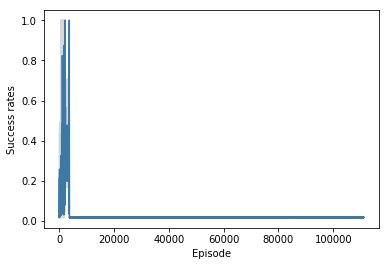

In [240]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

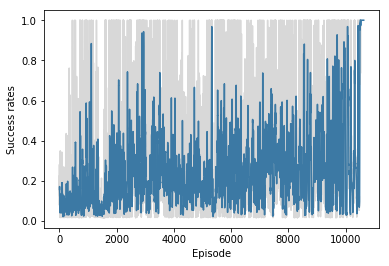

In [235]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

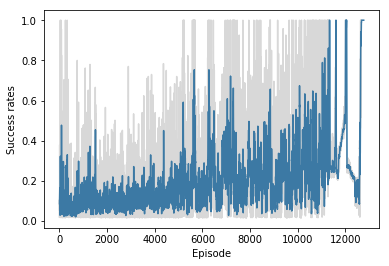

In [232]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

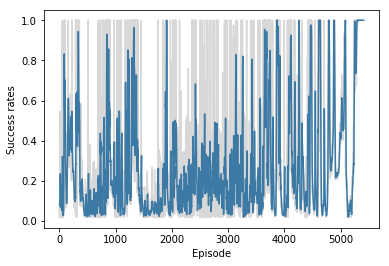

In [218]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Success rates')

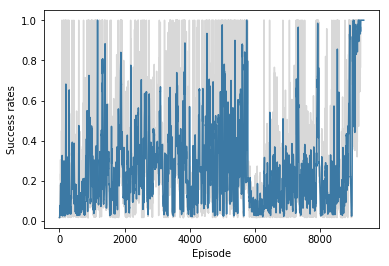

In [210]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

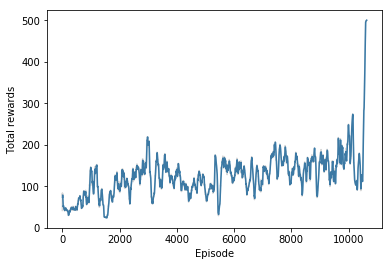

In [238]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

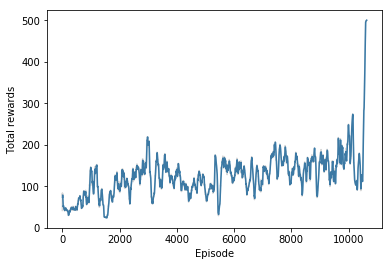

In [237]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

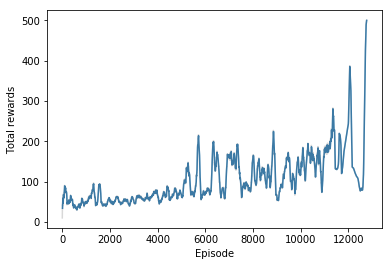

In [233]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

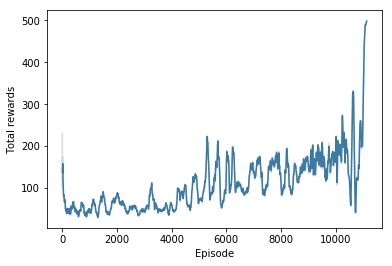

In [227]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

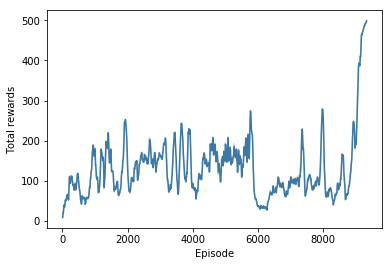

In [216]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

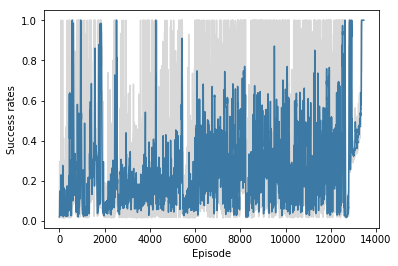

In [185]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

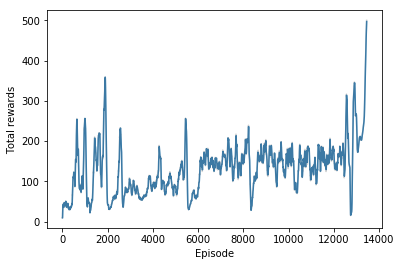

In [186]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Success rates')

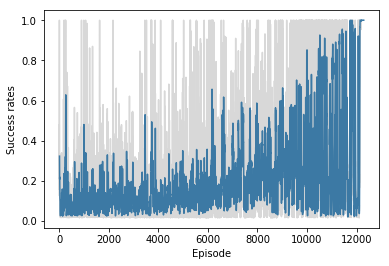

In [166]:
eps, arr = np.array(rates_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Success rates')

Text(0,0.5,'Total rewards')

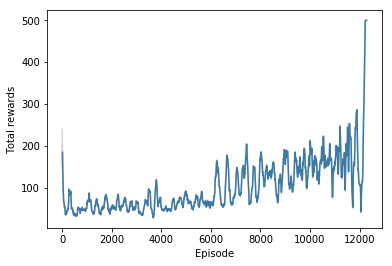

In [161]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

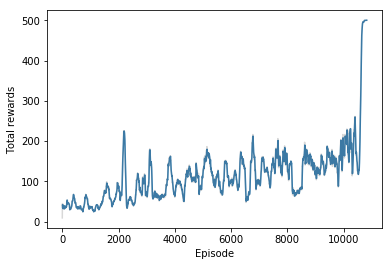

In [146]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

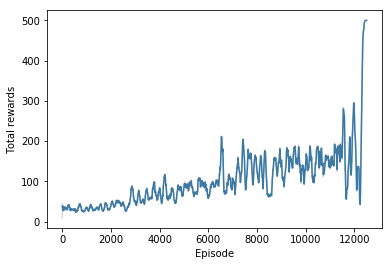

In [131]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

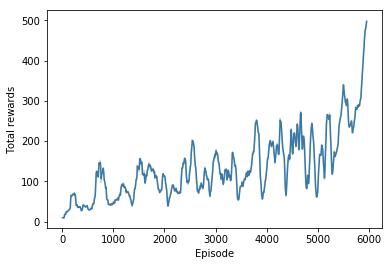

In [116]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

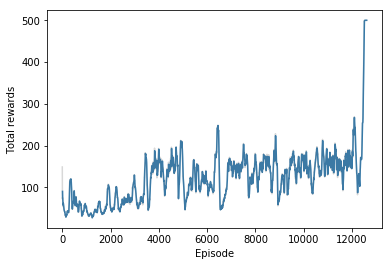

In [98]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

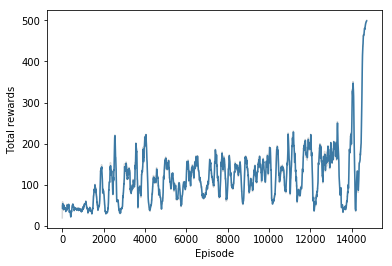

In [70]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

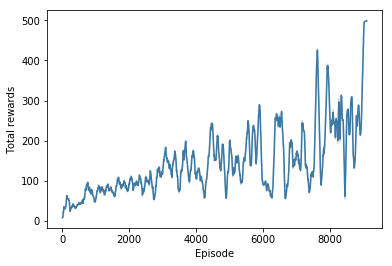

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

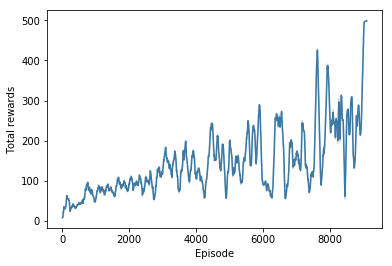

In [27]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

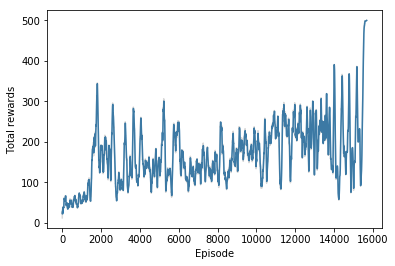

In [46]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

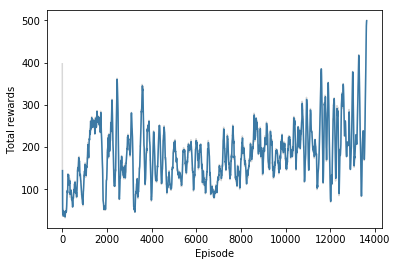

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

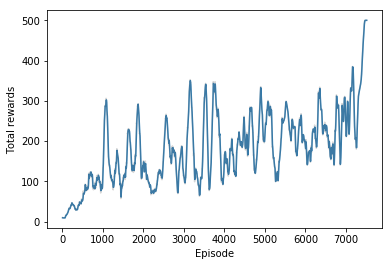

Text(0,0.5,'G losses')

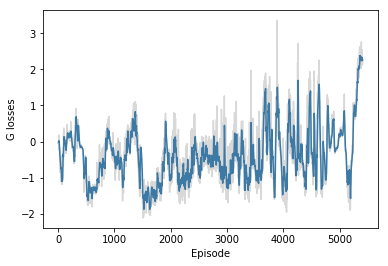

In [220]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

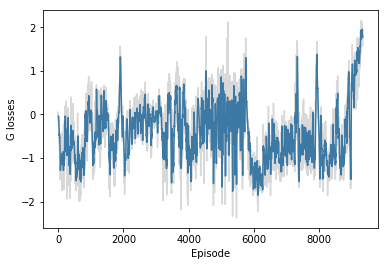

In [212]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

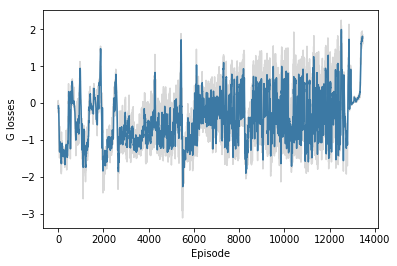

In [187]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

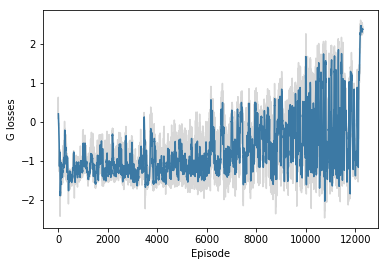

In [162]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

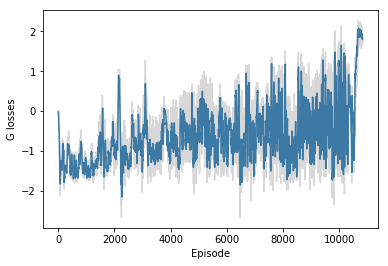

In [147]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

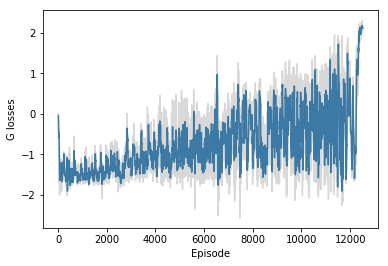

In [132]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

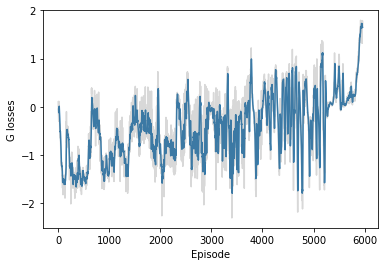

In [117]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

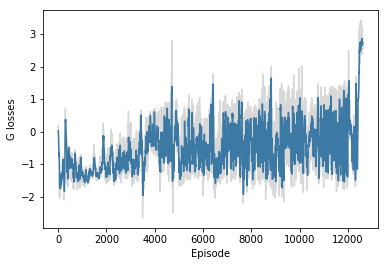

In [99]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

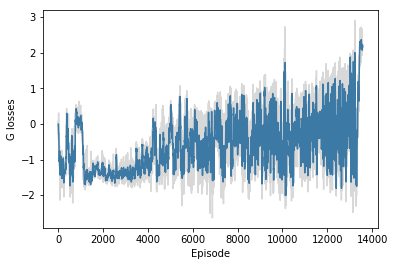

In [83]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

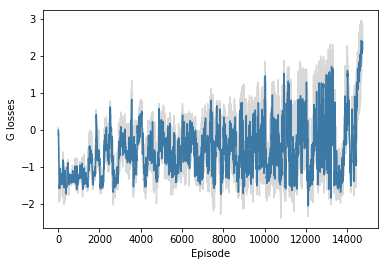

In [71]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

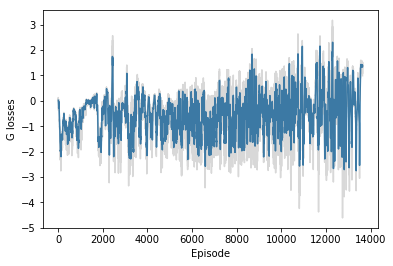

In [33]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'G losses')

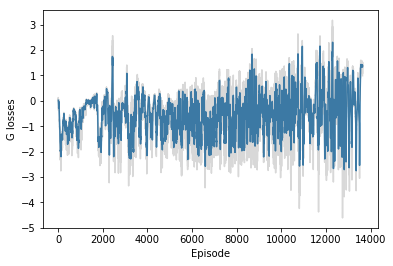

In [30]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

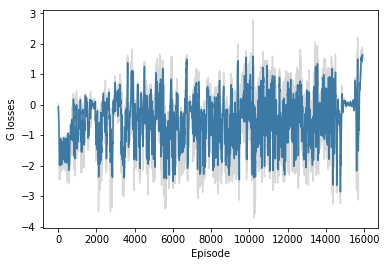
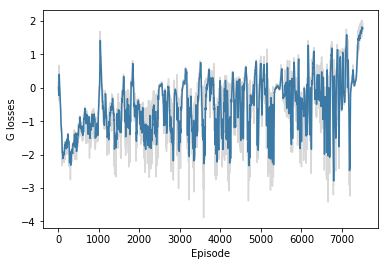

Text(0,0.5,'D losses')

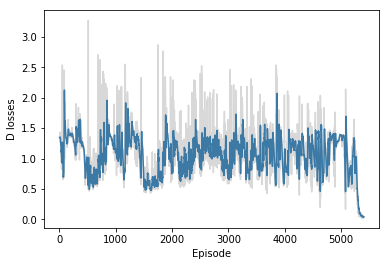

In [221]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

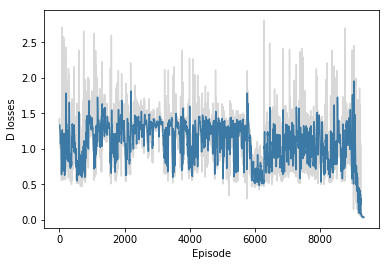

In [213]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

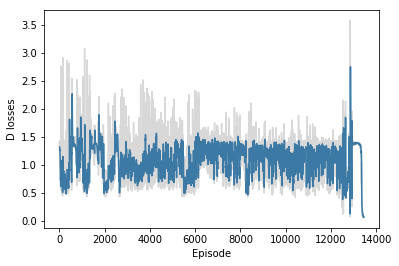

In [188]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

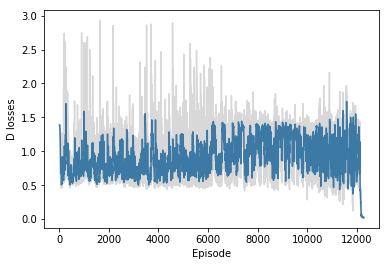

In [163]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

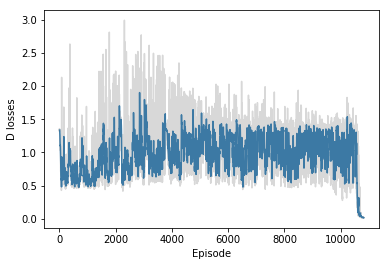

In [148]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

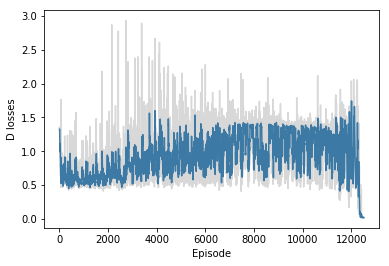

In [133]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

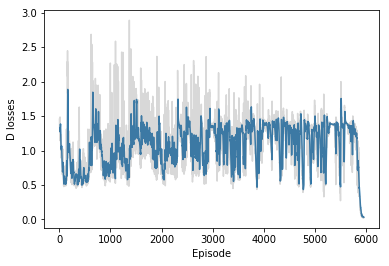

In [118]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

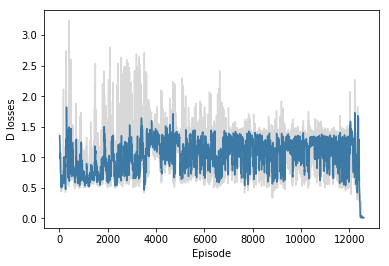

In [100]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

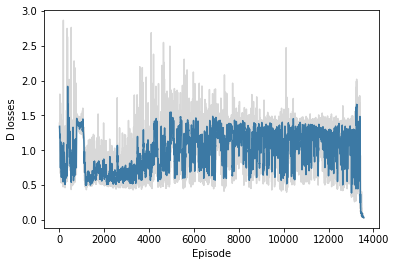

In [84]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

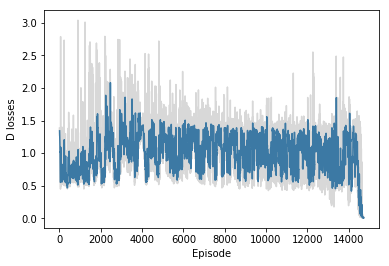

In [72]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

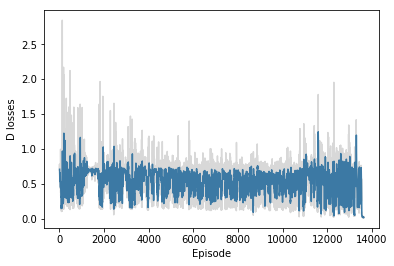

In [34]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

Text(0,0.5,'D losses')

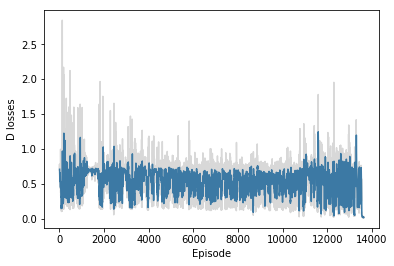

In [31]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

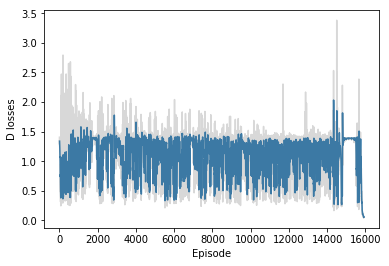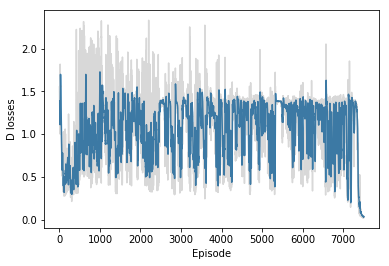

Text(0,0.5,'D losses R')

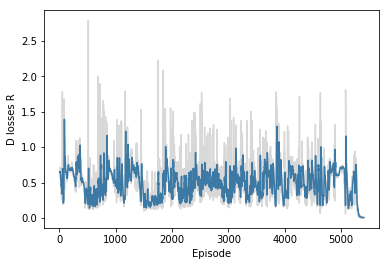

In [222]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

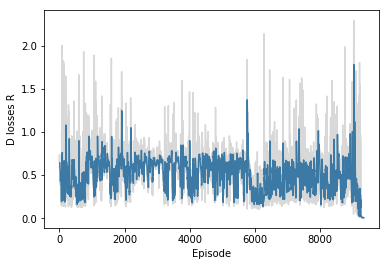

In [214]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

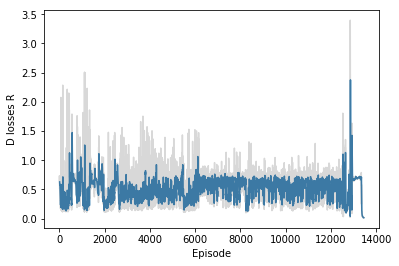

In [189]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

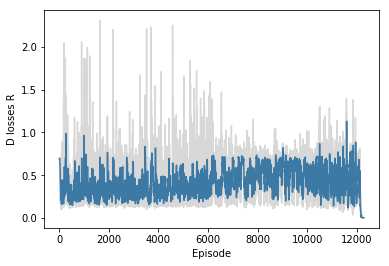

In [164]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

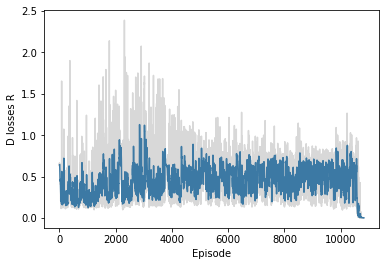

In [149]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

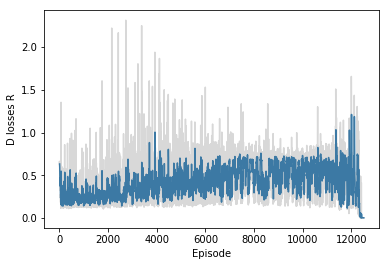

In [134]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

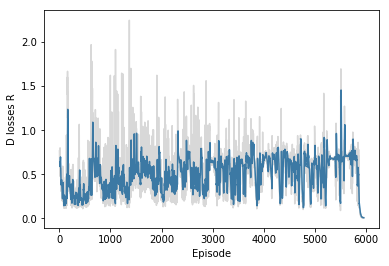

In [119]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

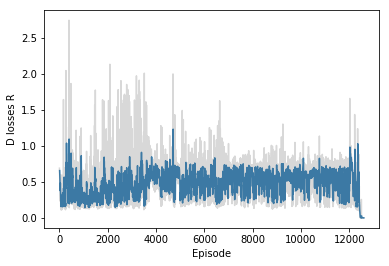

In [101]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

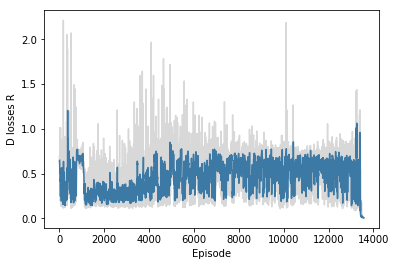

In [85]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

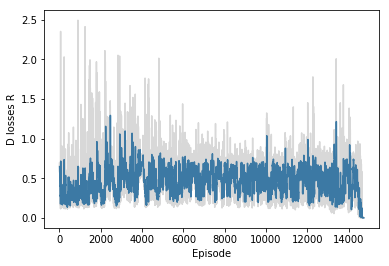

In [73]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

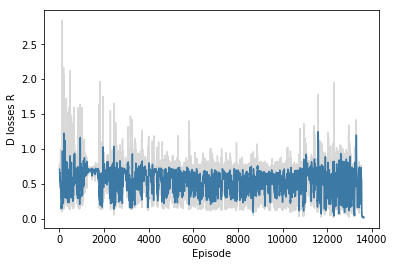

In [35]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses R')

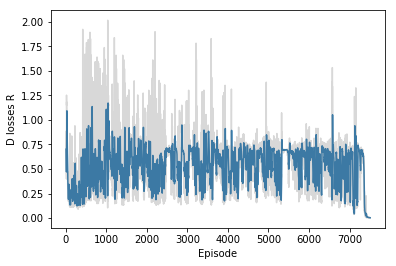

In [32]:
eps, arr = np.array(d_lossR_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses R')

Text(0,0.5,'D losses Q')

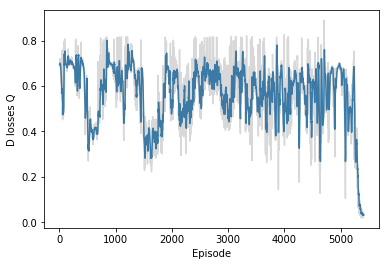

In [223]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

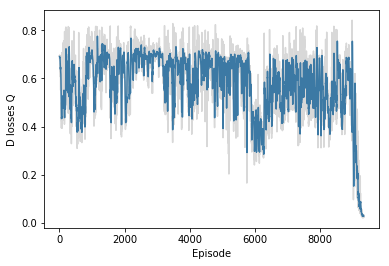

In [215]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

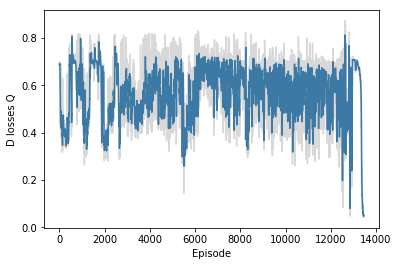

In [190]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

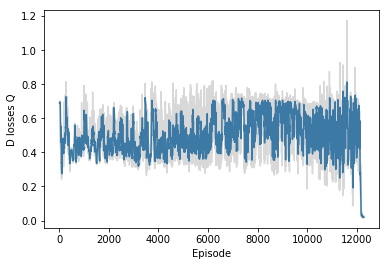

In [165]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

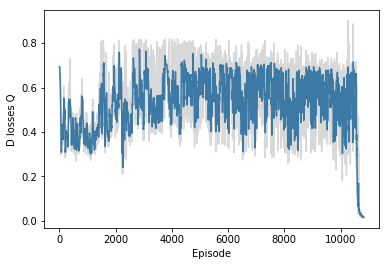

In [150]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

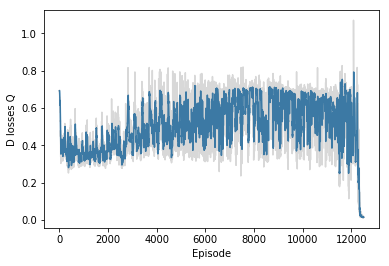

In [135]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

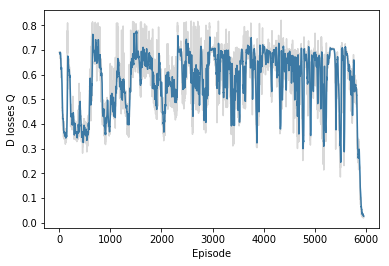

In [120]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

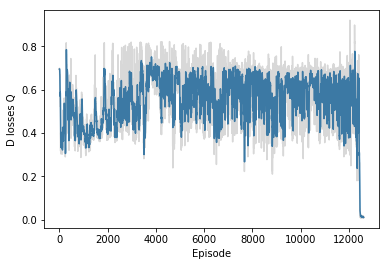

In [102]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

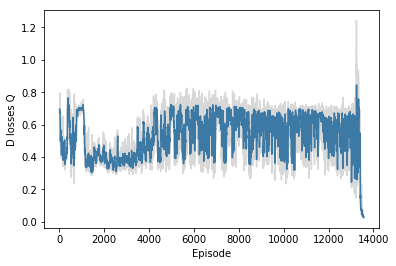

In [86]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

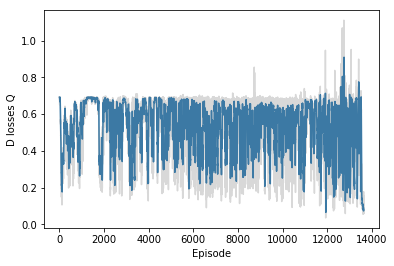

In [36]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

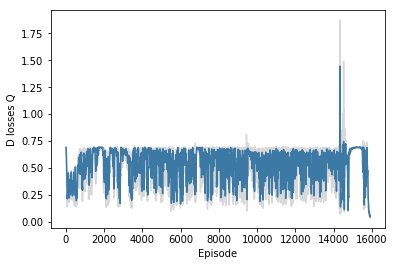

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

Text(0,0.5,'D losses Q')

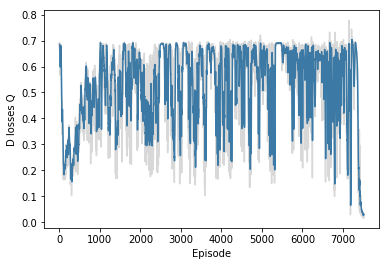

In [33]:
eps, arr = np.array(d_lossQ_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses Q')

## Testing

Let's checkout how our trained agent plays the game.

In [34]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(100):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        # if total_reward == 500:
        #     break
                
# Closing the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.